In [1]:
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'couplingSettings.set'
argv2 = r'modelPaths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2DFM/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR2DFM/
/home/ikeuchi/Share/GLOFRIM/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)


/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/PCR_Elbe/input30min/
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR2DFM/PCR


## create DFM model BMI object

In [6]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date)

/home/ikeuchi/Share/DFLOW-FM//dflowfm-1.1.267/lib/libdflowfm.so
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/DFM_Elbe/delta/
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR2DFM/DFM


## intitialize DFM model first to expose 1d coords

In [7]:
# initialize DFM to expose model coordinates via BMI
DFM_bmi.initialize()

## set coupling between PCR and DFM

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

Text(0.5,1,u'PCR coupled to DFM mask')

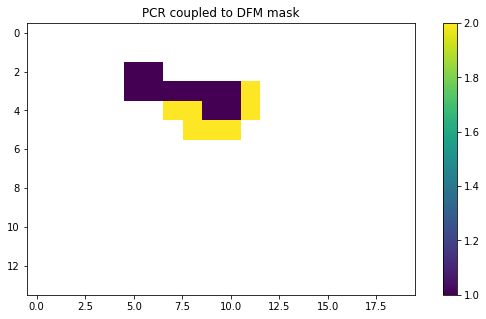

In [8]:
# get coupled dictionaries
PCR_bmi.couple_grid_to_1d(DFM_bmi)

fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(np.ma.masked_equal(PCR_bmi.coupled_mask, 0), interpolation='nearest')
plt.colorbar()
b.set_title('PCR coupled to DFM mask')

In [9]:
# initialize PCR to after editing ldd grid
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-04-24 07:01:40.542919
2018-04-24 07:01:40,908 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-04-24 07:01:40.542919
INFO: configuration.initialize_logging(): Logging output to /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-04-24T07:01:40.542919.log
2018-04-24 07:01:40,911 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-04-24T07:01:40.542919.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-04-24 07:01:40,933 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used

## run coupled PCR - DFM model

In [10]:
# run coupled model for 2 timesteps
def get_PCR_delta_vol():
    # coupled mask & downstream dictionary
    coupled_mask = PCR_bmi.coupled_mask
    downstream_dict = PCR_bmi.downstream_dict
    # PCR 2D runoff for coupled cells
    runoff = np.where(coupled_mask == 1,  PCR_bmi.get_var('runoff') * PCR_bmi.get_var('cellArea'), 0) # [m3/day] 
    #  PCR 2D discharge flowing into the coupled domain
    uc_rows, uc_cols = np.where(coupled_mask == 2)
    q_all = np.copy(PCR_bmi.get_var('discharge'))
    q_out  = np.zeros_like(q_all)
    # upstream discharge is now given to downstream cell 
    for r, c in zip(uc_rows, uc_cols):
        q_out[downstream_dict[(r, c)]] = q_all[r, c] 
    q_out = q_out * 86400.
    # obtain total flux
    tot_flux = runoff + q_out
    # convert flux to volume per day
    delta_vol = tot_flux * PCR_bmi.options['dt'] # [m3/day]
    return delta_vol 

DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
PCRidx = PCR_bmi.coupled_idx
PCRfrac = PCR_bmi.coupled_area_frac

def set_DFM_forcing():
    PCR_delta_vol = get_PCR_delta_vol() # 2d array [m3/day]
    print np.sum(PCR_delta_vol)
    DFM_depth_conservative = PCR_delta_vol[PCRidx] * PCRfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    zerorain = np.zeros_like(np.copy(DFM_bmi.get_var('rain')))
    DFM_bmi.set_var('rain', zerorain)
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)
    return PCR_delta_vol

In [11]:
tStart = datetime.now()
for i in range(timeSteps):
#for i in range(80):
    PCR_bmi.update()
    set_DFM_forcing()
    DFM_bmi.update()  

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-04-24 07:01:52,424 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-04-24 07:01:52,615 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-04-24 07:01:54,304 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1


3.21918e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
2018-04-24 07:01:58,314 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-02
2018-04-24 07:01:58,317 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
INFO: pcrglobwb.update(): updating model to time 2000-01-02
2018-04-24 07:01:58,526 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-02, timestep 2
2018-04-24 07:01:59,389 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-02, timestep 2


3.20307e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 172800.0, timestep 86400.0
2018-04-24 07:02:03,895 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 172800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-03
2018-04-24 07:02:03,899 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-03
INFO: pcrglobwb.update(): updating model to time 2000-01-03
2018-04-24 07:02:04,105 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-03, timestep 3
2018-04-24 07:02:04,980 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-03, timestep 3


3.07984e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 259200.0, timestep 86400.0
2018-04-24 07:02:11,352 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 259200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-04
2018-04-24 07:02:11,356 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-04
INFO: pcrglobwb.update(): updating model to time 2000-01-04
2018-04-24 07:02:11,570 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-04, timestep 4
2018-04-24 07:02:12,480 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-04, timestep 4


2.87354e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 345600.0, timestep 86400.0
2018-04-24 07:02:18,855 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 345600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-05
2018-04-24 07:02:18,859 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-05
INFO: pcrglobwb.update(): updating model to time 2000-01-05
2018-04-24 07:02:19,062 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-05, timestep 5
2018-04-24 07:02:19,949 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-05, timestep 5


2.64896e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 432000.0, timestep 86400.0
2018-04-24 07:02:25,837 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 432000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-06
2018-04-24 07:02:25,844 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-06
INFO: pcrglobwb.update(): updating model to time 2000-01-06
2018-04-24 07:02:26,043 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-06, timestep 6
2018-04-24 07:02:26,919 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-06, timestep 6


2.472e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 518400.0, timestep 86400.0
2018-04-24 07:02:32,635 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 518400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-07
2018-04-24 07:02:32,639 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-07
INFO: pcrglobwb.update(): updating model to time 2000-01-07
2018-04-24 07:02:32,857 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-07, timestep 7
2018-04-24 07:02:33,778 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-07, timestep 7


2.32815e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 604800.0, timestep 86400.0
2018-04-24 07:02:39,348 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 604800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-08
2018-04-24 07:02:39,354 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-08
INFO: pcrglobwb.update(): updating model to time 2000-01-08
2018-04-24 07:02:39,562 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-08, timestep 8
2018-04-24 07:02:40,445 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-08, timestep 8


2.19537e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
2018-04-24 07:02:45,929 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-09
2018-04-24 07:02:45,935 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-09
INFO: pcrglobwb.update(): updating model to time 2000-01-09
2018-04-24 07:02:46,160 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
2018-04-24 07:02:47,107 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9


2.16289e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 777600.0, timestep 86400.0
2018-04-24 07:02:52,642 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 777600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-10
2018-04-24 07:02:52,647 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-10
INFO: pcrglobwb.update(): updating model to time 2000-01-10
2018-04-24 07:02:52,853 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-10, timestep 10
2018-04-24 07:02:53,734 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-10, timestep 10


2.27518e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 864000.0, timestep 86400.0
2018-04-24 07:02:59,401 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 864000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-11
2018-04-24 07:02:59,407 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11
INFO: pcrglobwb.update(): updating model to time 2000-01-11
2018-04-24 07:02:59,622 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-04-24 07:03:00,575 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11


2.36698e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 950400.0, timestep 86400.0
2018-04-24 07:03:06,860 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 950400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-12
2018-04-24 07:03:06,865 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12
INFO: pcrglobwb.update(): updating model to time 2000-01-12
2018-04-24 07:03:07,061 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-12, timestep 12
2018-04-24 07:03:07,978 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-12, timestep 12


2.20416e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1036800.0, timestep 86400.0
2018-04-24 07:03:14,126 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1036800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-13
2018-04-24 07:03:14,130 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-13
INFO: pcrglobwb.update(): updating model to time 2000-01-13
2018-04-24 07:03:14,326 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-13, timestep 13
2018-04-24 07:03:15,232 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-13, timestep 13


1.93037e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1123200.0, timestep 86400.0
2018-04-24 07:03:21,298 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1123200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-14
2018-04-24 07:03:21,305 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-14
INFO: pcrglobwb.update(): updating model to time 2000-01-14
2018-04-24 07:03:21,526 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-14, timestep 14
2018-04-24 07:03:22,462 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-14, timestep 14


1.72183e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1209600.0, timestep 86400.0
2018-04-24 07:03:28,167 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1209600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-15
2018-04-24 07:03:28,169 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-15
INFO: pcrglobwb.update(): updating model to time 2000-01-15
2018-04-24 07:03:28,379 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-15, timestep 15
2018-04-24 07:03:29,279 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-15, timestep 15


1.6265e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1296000.0, timestep 86400.0
2018-04-24 07:03:34,720 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1296000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-16
2018-04-24 07:03:34,722 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-16
INFO: pcrglobwb.update(): updating model to time 2000-01-16
2018-04-24 07:03:34,914 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-16, timestep 16
2018-04-24 07:03:35,790 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-16, timestep 16


1.57506e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
2018-04-24 07:03:41,187 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-17
2018-04-24 07:03:41,192 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-17
INFO: pcrglobwb.update(): updating model to time 2000-01-17
2018-04-24 07:03:41,383 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17
2018-04-24 07:03:42,289 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17


1.55219e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1468800.0, timestep 86400.0
2018-04-24 07:03:47,971 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1468800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-18
2018-04-24 07:03:47,974 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-18
INFO: pcrglobwb.update(): updating model to time 2000-01-18
2018-04-24 07:03:48,175 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-18, timestep 18
2018-04-24 07:03:49,068 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-18, timestep 18


1.56432e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1555200.0, timestep 86400.0
2018-04-24 07:03:54,439 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1555200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-19
2018-04-24 07:03:54,444 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-19
INFO: pcrglobwb.update(): updating model to time 2000-01-19
2018-04-24 07:03:54,635 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-19, timestep 19
2018-04-24 07:03:55,512 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-19, timestep 19


1.54397e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1641600.0, timestep 86400.0
2018-04-24 07:04:01,073 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1641600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-20
2018-04-24 07:04:01,079 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-20
INFO: pcrglobwb.update(): updating model to time 2000-01-20
2018-04-24 07:04:01,276 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-20, timestep 20
2018-04-24 07:04:02,182 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-20, timestep 20


1.53782e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1728000.0, timestep 86400.0
2018-04-24 07:04:08,045 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1728000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-21
2018-04-24 07:04:08,051 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-21
INFO: pcrglobwb.update(): updating model to time 2000-01-21
2018-04-24 07:04:08,262 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
2018-04-24 07:04:09,145 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21


1.53739e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1814400.0, timestep 86400.0
2018-04-24 07:04:14,888 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1814400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-22
2018-04-24 07:04:14,892 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-22
INFO: pcrglobwb.update(): updating model to time 2000-01-22
2018-04-24 07:04:15,082 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-22, timestep 22
2018-04-24 07:04:15,975 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-22, timestep 22


1.5182e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1900800.0, timestep 86400.0
2018-04-24 07:04:21,304 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1900800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-23
2018-04-24 07:04:21,309 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-23
INFO: pcrglobwb.update(): updating model to time 2000-01-23
2018-04-24 07:04:21,502 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-23, timestep 23
2018-04-24 07:04:22,390 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-23, timestep 23


1.47686e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1987200.0, timestep 86400.0
2018-04-24 07:04:27,742 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1987200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-24
2018-04-24 07:04:27,747 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-24
INFO: pcrglobwb.update(): updating model to time 2000-01-24
2018-04-24 07:04:27,944 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
2018-04-24 07:04:28,835 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24


1.37647e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
2018-04-24 07:04:34,063 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-25
2018-04-24 07:04:34,069 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-25
INFO: pcrglobwb.update(): updating model to time 2000-01-25
2018-04-24 07:04:34,268 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-25, timestep 25
2018-04-24 07:04:35,152 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-25, timestep 25


1.16205e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2160000.0, timestep 86400.0
2018-04-24 07:04:39,617 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2160000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-26
2018-04-24 07:04:39,622 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-26
INFO: pcrglobwb.update(): updating model to time 2000-01-26
2018-04-24 07:04:39,819 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-26, timestep 26
2018-04-24 07:04:40,699 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-26, timestep 26


1.08706e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2246400.0, timestep 86400.0
2018-04-24 07:04:44,929 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2246400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-27
2018-04-24 07:04:44,935 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-27
INFO: pcrglobwb.update(): updating model to time 2000-01-27
2018-04-24 07:04:45,133 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-27, timestep 27
2018-04-24 07:04:46,036 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-27, timestep 27


1.0202e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2332800.0, timestep 86400.0
2018-04-24 07:04:50,045 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2332800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-28
2018-04-24 07:04:50,049 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-28
INFO: pcrglobwb.update(): updating model to time 2000-01-28
2018-04-24 07:04:50,244 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-28, timestep 28
2018-04-24 07:04:51,150 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-28, timestep 28


9.75592e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2419200.0, timestep 86400.0
2018-04-24 07:04:55,177 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2419200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-29
2018-04-24 07:04:55,183 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-29
INFO: pcrglobwb.update(): updating model to time 2000-01-29
2018-04-24 07:04:55,376 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-29, timestep 29
2018-04-24 07:04:56,251 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-29, timestep 29


1.30462e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2505600.0, timestep 86400.0
2018-04-24 07:05:00,406 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2505600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-30
2018-04-24 07:05:00,410 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-30
INFO: pcrglobwb.update(): updating model to time 2000-01-30
2018-04-24 07:05:00,613 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-30, timestep 30
2018-04-24 07:05:01,522 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-30, timestep 30


1.3976e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2592000.0, timestep 86400.0
2018-04-24 07:05:06,180 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2592000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-31
2018-04-24 07:05:06,186 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-31
INFO: pcrglobwb.update(): updating model to time 2000-01-31
2018-04-24 07:05:06,385 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31
2018-04-24 07:05:07,270 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31


1.48881e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2678400.0, timestep 86400.0
2018-04-24 07:05:12,534 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2678400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-01
2018-04-24 07:05:12,536 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
INFO: pcrglobwb.update(): updating model to time 2000-02-01
2018-04-24 07:05:12,831 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
2018-04-24 07:05:13,930 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32


1.48065e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
2018-04-24 07:05:18,829 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-02
2018-04-24 07:05:18,834 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-02
INFO: pcrglobwb.update(): updating model to time 2000-02-02
2018-04-24 07:05:19,017 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-02, timestep 33
2018-04-24 07:05:19,893 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-02, timestep 33


1.53695e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2851200.0, timestep 86400.0
2018-04-24 07:05:25,223 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2851200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-03
2018-04-24 07:05:25,227 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-03
INFO: pcrglobwb.update(): updating model to time 2000-02-03
2018-04-24 07:05:25,409 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-03, timestep 34
2018-04-24 07:05:26,279 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-03, timestep 34


1.36532e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2937600.0, timestep 86400.0
2018-04-24 07:05:30,918 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2937600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-04
2018-04-24 07:05:30,922 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-04
INFO: pcrglobwb.update(): updating model to time 2000-02-04
2018-04-24 07:05:31,117 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-04, timestep 35
2018-04-24 07:05:32,002 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-04, timestep 35


1.37697e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3024000.0, timestep 86400.0
2018-04-24 07:05:36,504 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3024000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-05
2018-04-24 07:05:36,509 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-05
INFO: pcrglobwb.update(): updating model to time 2000-02-05
2018-04-24 07:05:36,708 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-05, timestep 36
2018-04-24 07:05:37,603 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-05, timestep 36


1.24379e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3110400.0, timestep 86400.0
2018-04-24 07:05:41,877 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3110400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-06
2018-04-24 07:05:41,882 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-06
INFO: pcrglobwb.update(): updating model to time 2000-02-06
2018-04-24 07:05:42,078 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-06, timestep 37
2018-04-24 07:05:42,963 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-06, timestep 37


1.17734e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3196800.0, timestep 86400.0
2018-04-24 07:05:47,014 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3196800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-07
2018-04-24 07:05:47,019 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-07
INFO: pcrglobwb.update(): updating model to time 2000-02-07
2018-04-24 07:05:47,206 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-07, timestep 38
2018-04-24 07:05:48,110 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-07, timestep 38


1.16453e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3283200.0, timestep 86400.0
2018-04-24 07:05:52,338 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3283200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-08
2018-04-24 07:05:52,344 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-08
INFO: pcrglobwb.update(): updating model to time 2000-02-08
2018-04-24 07:05:52,552 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-08, timestep 39
2018-04-24 07:05:53,430 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-08, timestep 39


1.31836e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
2018-04-24 07:05:57,528 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-09
2018-04-24 07:05:57,535 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-09
INFO: pcrglobwb.update(): updating model to time 2000-02-09
2018-04-24 07:05:57,734 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
2018-04-24 07:05:58,628 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40


1.37376e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3456000.0, timestep 86400.0
2018-04-24 07:06:03,051 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3456000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-10
2018-04-24 07:06:03,056 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-10
INFO: pcrglobwb.update(): updating model to time 2000-02-10
2018-04-24 07:06:03,260 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41
2018-04-24 07:06:04,168 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41


1.3071e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3542400.0, timestep 86400.0
2018-04-24 07:06:08,309 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3542400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-11
2018-04-24 07:06:08,312 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-11
INFO: pcrglobwb.update(): updating model to time 2000-02-11
2018-04-24 07:06:08,514 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-11, timestep 42
2018-04-24 07:06:09,409 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-11, timestep 42


1.20434e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3628800.0, timestep 86400.0
2018-04-24 07:06:13,382 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3628800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-12
2018-04-24 07:06:13,386 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-12
INFO: pcrglobwb.update(): updating model to time 2000-02-12
2018-04-24 07:06:13,588 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-12, timestep 43
2018-04-24 07:06:14,470 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-12, timestep 43


1.11103e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3715200.0, timestep 86400.0
2018-04-24 07:06:18,358 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3715200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-13
2018-04-24 07:06:18,362 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-13
INFO: pcrglobwb.update(): updating model to time 2000-02-13
2018-04-24 07:06:18,557 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-13, timestep 44
2018-04-24 07:06:19,458 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-13, timestep 44


1.09321e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3801600.0, timestep 86400.0
2018-04-24 07:06:23,448 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3801600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-14
2018-04-24 07:06:23,454 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-14
INFO: pcrglobwb.update(): updating model to time 2000-02-14
2018-04-24 07:06:23,668 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-14, timestep 45
2018-04-24 07:06:24,574 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-14, timestep 45


1.09074e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3888000.0, timestep 86400.0
2018-04-24 07:06:28,703 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3888000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-15
2018-04-24 07:06:28,708 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-15
INFO: pcrglobwb.update(): updating model to time 2000-02-15
2018-04-24 07:06:28,900 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-15, timestep 46
2018-04-24 07:06:29,795 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-15, timestep 46


1.07243e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3974400.0, timestep 86400.0
2018-04-24 07:06:33,607 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3974400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-16
2018-04-24 07:06:33,613 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-16
INFO: pcrglobwb.update(): updating model to time 2000-02-16
2018-04-24 07:06:33,829 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-16, timestep 47
2018-04-24 07:06:34,745 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-16, timestep 47


1.20182e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
2018-04-24 07:06:38,804 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-17
2018-04-24 07:06:38,808 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-17
INFO: pcrglobwb.update(): updating model to time 2000-02-17
2018-04-24 07:06:39,014 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-17, timestep 48
2018-04-24 07:06:39,912 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-17, timestep 48


1.11797e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4147200.0, timestep 86400.0
2018-04-24 07:06:43,910 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4147200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-18
2018-04-24 07:06:43,915 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-18
INFO: pcrglobwb.update(): updating model to time 2000-02-18
2018-04-24 07:06:44,174 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-18, timestep 49
2018-04-24 07:06:45,050 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-18, timestep 49


1.09678e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4233600.0, timestep 86400.0
2018-04-24 07:06:49,166 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4233600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-19
2018-04-24 07:06:49,169 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-19
INFO: pcrglobwb.update(): updating model to time 2000-02-19
2018-04-24 07:06:49,371 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-19, timestep 50
2018-04-24 07:06:50,274 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-19, timestep 50


1.11753e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4320000.0, timestep 86400.0
2018-04-24 07:06:54,183 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4320000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-20
2018-04-24 07:06:54,188 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-20
INFO: pcrglobwb.update(): updating model to time 2000-02-20
2018-04-24 07:06:54,373 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51
2018-04-24 07:06:55,265 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51


1.11481e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4406400.0, timestep 86400.0
2018-04-24 07:06:59,173 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4406400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-21
2018-04-24 07:06:59,178 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-21
INFO: pcrglobwb.update(): updating model to time 2000-02-21
2018-04-24 07:06:59,388 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-21, timestep 52
2018-04-24 07:07:00,299 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-21, timestep 52


1.09634e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4492800.0, timestep 86400.0
2018-04-24 07:07:04,414 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4492800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-22
2018-04-24 07:07:04,420 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-22
INFO: pcrglobwb.update(): updating model to time 2000-02-22
2018-04-24 07:07:04,629 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-22, timestep 53
2018-04-24 07:07:05,516 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-22, timestep 53


1.04553e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4579200.0, timestep 86400.0
2018-04-24 07:07:09,263 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4579200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-23
2018-04-24 07:07:09,268 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-23
INFO: pcrglobwb.update(): updating model to time 2000-02-23
2018-04-24 07:07:09,460 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-23, timestep 54
2018-04-24 07:07:10,370 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-23, timestep 54


1.00261e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4665600.0, timestep 86400.0
2018-04-24 07:07:14,055 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4665600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-24
2018-04-24 07:07:14,058 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-24
INFO: pcrglobwb.update(): updating model to time 2000-02-24
2018-04-24 07:07:14,250 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
2018-04-24 07:07:15,131 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55


1.07745e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
2018-04-24 07:07:18,894 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-25
2018-04-24 07:07:18,900 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-25
INFO: pcrglobwb.update(): updating model to time 2000-02-25
2018-04-24 07:07:19,135 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-25, timestep 56
2018-04-24 07:07:20,042 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-25, timestep 56


1.1897e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4838400.0, timestep 86400.0
2018-04-24 07:07:24,091 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4838400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-26
2018-04-24 07:07:24,097 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-26
INFO: pcrglobwb.update(): updating model to time 2000-02-26
2018-04-24 07:07:24,311 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-26, timestep 57
2018-04-24 07:07:25,236 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-26, timestep 57


1.36793e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4924800.0, timestep 86400.0
2018-04-24 07:07:29,282 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4924800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-27
2018-04-24 07:07:29,287 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-27
INFO: pcrglobwb.update(): updating model to time 2000-02-27
2018-04-24 07:07:29,500 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-27, timestep 58
2018-04-24 07:07:30,391 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-27, timestep 58


1.3095e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5011200.0, timestep 86400.0
2018-04-24 07:07:34,557 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5011200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-28
2018-04-24 07:07:34,560 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-28
INFO: pcrglobwb.update(): updating model to time 2000-02-28
2018-04-24 07:07:34,766 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-28, timestep 59
2018-04-24 07:07:35,647 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-28, timestep 59


1.2393e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5097600.0, timestep 86400.0
2018-04-24 07:07:39,731 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5097600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-29
2018-04-24 07:07:39,735 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-29
INFO: pcrglobwb.update(): updating model to time 2000-02-29
2018-04-24 07:07:39,945 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-29, timestep 60
2018-04-24 07:07:40,862 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-29, timestep 60


1.16581e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5184000.0, timestep 86400.0
2018-04-24 07:07:44,866 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5184000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-01
2018-04-24 07:07:44,869 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-01
INFO: pcrglobwb.update(): updating model to time 2000-03-01
2018-04-24 07:07:45,064 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-01, timestep 61
2018-04-24 07:07:46,154 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-01, timestep 61


1.12941e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5270400.0, timestep 86400.0
2018-04-24 07:07:49,968 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5270400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-02
2018-04-24 07:07:49,974 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-02
INFO: pcrglobwb.update(): updating model to time 2000-03-02
2018-04-24 07:07:50,172 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-02, timestep 62
2018-04-24 07:07:51,050 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-02, timestep 62


1.12282e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5356800.0, timestep 86400.0
2018-04-24 07:07:54,919 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5356800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-03
2018-04-24 07:07:54,925 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-03
INFO: pcrglobwb.update(): updating model to time 2000-03-03
2018-04-24 07:07:55,129 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
2018-04-24 07:07:56,005 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63


1.14644e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
2018-04-24 07:07:59,880 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-04
2018-04-24 07:07:59,886 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-04
INFO: pcrglobwb.update(): updating model to time 2000-03-04
2018-04-24 07:08:00,081 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-04, timestep 64
2018-04-24 07:08:00,959 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-04, timestep 64


1.15868e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5529600.0, timestep 86400.0
2018-04-24 07:08:04,773 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5529600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-05
2018-04-24 07:08:04,777 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-05
INFO: pcrglobwb.update(): updating model to time 2000-03-05
2018-04-24 07:08:04,980 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-05, timestep 65
2018-04-24 07:08:05,861 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-05, timestep 65


1.19808e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5616000.0, timestep 86400.0
2018-04-24 07:08:09,863 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5616000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-06
2018-04-24 07:08:09,866 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-06
INFO: pcrglobwb.update(): updating model to time 2000-03-06
2018-04-24 07:08:10,065 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-06, timestep 66
2018-04-24 07:08:10,942 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-06, timestep 66


1.22339e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5702400.0, timestep 86400.0
2018-04-24 07:08:14,898 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5702400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-07
2018-04-24 07:08:14,900 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-07
INFO: pcrglobwb.update(): updating model to time 2000-03-07
2018-04-24 07:08:15,086 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-07, timestep 67
2018-04-24 07:08:15,963 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-07, timestep 67


1.22391e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5788800.0, timestep 86400.0
2018-04-24 07:08:19,758 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5788800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-08
2018-04-24 07:08:19,764 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-08
INFO: pcrglobwb.update(): updating model to time 2000-03-08
2018-04-24 07:08:19,958 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-08, timestep 68
2018-04-24 07:08:20,835 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-08, timestep 68


1.2336e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5875200.0, timestep 86400.0
2018-04-24 07:08:24,851 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5875200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-09
2018-04-24 07:08:24,857 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-09
INFO: pcrglobwb.update(): updating model to time 2000-03-09
2018-04-24 07:08:25,065 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-09, timestep 69
2018-04-24 07:08:25,976 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-09, timestep 69


1.40431e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5961600.0, timestep 86400.0
2018-04-24 07:08:29,923 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5961600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-10
2018-04-24 07:08:29,928 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-10
INFO: pcrglobwb.update(): updating model to time 2000-03-10
2018-04-24 07:08:30,127 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-10, timestep 70
2018-04-24 07:08:31,014 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-10, timestep 70


1.62893e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
2018-04-24 07:08:35,447 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-11
2018-04-24 07:08:35,453 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
INFO: pcrglobwb.update(): updating model to time 2000-03-11
2018-04-24 07:08:35,657 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
2018-04-24 07:08:36,543 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71


1.69589e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6134400.0, timestep 86400.0
2018-04-24 07:08:41,245 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6134400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-12
2018-04-24 07:08:41,251 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-12
INFO: pcrglobwb.update(): updating model to time 2000-03-12
2018-04-24 07:08:41,458 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-12, timestep 72
2018-04-24 07:08:42,379 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-12, timestep 72


1.72044e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6220800.0, timestep 86400.0
2018-04-24 07:08:47,009 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6220800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-13
2018-04-24 07:08:47,013 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-13
INFO: pcrglobwb.update(): updating model to time 2000-03-13
2018-04-24 07:08:47,209 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-13, timestep 73
2018-04-24 07:08:48,092 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-13, timestep 73


1.71571e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6307200.0, timestep 86400.0
2018-04-24 07:08:52,551 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6307200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-14
2018-04-24 07:08:52,557 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-14
INFO: pcrglobwb.update(): updating model to time 2000-03-14
2018-04-24 07:08:52,756 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-14, timestep 74
2018-04-24 07:08:53,636 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-14, timestep 74


1.67755e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6393600.0, timestep 86400.0
2018-04-24 07:08:58,099 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6393600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-15
2018-04-24 07:08:58,105 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-15
INFO: pcrglobwb.update(): updating model to time 2000-03-15
2018-04-24 07:08:58,307 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-15, timestep 75
2018-04-24 07:08:59,215 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-15, timestep 75


1.7038e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6480000.0, timestep 86400.0
2018-04-24 07:09:04,005 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6480000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-16
2018-04-24 07:09:04,007 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-16
INFO: pcrglobwb.update(): updating model to time 2000-03-16
2018-04-24 07:09:04,217 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-16, timestep 76
2018-04-24 07:09:05,126 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-16, timestep 76


1.72932e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6566400.0, timestep 86400.0
2018-04-24 07:09:09,730 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6566400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-17
2018-04-24 07:09:09,736 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-17
INFO: pcrglobwb.update(): updating model to time 2000-03-17
2018-04-24 07:09:09,937 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-17, timestep 77
2018-04-24 07:09:10,846 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-17, timestep 77


1.75428e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6652800.0, timestep 86400.0
2018-04-24 07:09:15,793 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6652800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-18
2018-04-24 07:09:15,799 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-18
INFO: pcrglobwb.update(): updating model to time 2000-03-18
2018-04-24 07:09:16,000 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-18, timestep 78
2018-04-24 07:09:16,883 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-18, timestep 78


1.7715e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
2018-04-24 07:09:21,862 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-19
2018-04-24 07:09:21,867 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-19
INFO: pcrglobwb.update(): updating model to time 2000-03-19
2018-04-24 07:09:22,078 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-19, timestep 79
2018-04-24 07:09:22,972 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-19, timestep 79


1.74487e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6825600.0, timestep 86400.0
2018-04-24 07:09:27,901 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6825600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-20
2018-04-24 07:09:27,906 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-20
INFO: pcrglobwb.update(): updating model to time 2000-03-20
2018-04-24 07:09:28,112 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-20, timestep 80
2018-04-24 07:09:29,010 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-20, timestep 80


1.70541e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6912000.0, timestep 86400.0
2018-04-24 07:09:33,835 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6912000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-21
2018-04-24 07:09:33,841 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-21
INFO: pcrglobwb.update(): updating model to time 2000-03-21
2018-04-24 07:09:34,045 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-21, timestep 81
2018-04-24 07:09:34,935 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-21, timestep 81


1.67908e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6998400.0, timestep 86400.0
2018-04-24 07:09:40,085 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6998400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-22
2018-04-24 07:09:40,091 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-22
INFO: pcrglobwb.update(): updating model to time 2000-03-22
2018-04-24 07:09:40,291 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-22, timestep 82
2018-04-24 07:09:41,181 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-22, timestep 82


1.66291e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7084800.0, timestep 86400.0
2018-04-24 07:09:45,718 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7084800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-23
2018-04-24 07:09:45,723 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-23
INFO: pcrglobwb.update(): updating model to time 2000-03-23
2018-04-24 07:09:45,933 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-23, timestep 83
2018-04-24 07:09:46,817 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-23, timestep 83


1.65567e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7171200.0, timestep 86400.0
2018-04-24 07:09:51,505 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7171200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-24
2018-04-24 07:09:51,511 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-24
INFO: pcrglobwb.update(): updating model to time 2000-03-24
2018-04-24 07:09:51,711 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-24, timestep 84
2018-04-24 07:09:52,598 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-24, timestep 84


1.65575e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7257600.0, timestep 86400.0
2018-04-24 07:09:57,302 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7257600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-25
2018-04-24 07:09:57,309 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-25
INFO: pcrglobwb.update(): updating model to time 2000-03-25
2018-04-24 07:09:57,521 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-25, timestep 85
2018-04-24 07:09:58,476 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-25, timestep 85


1.65497e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7344000.0, timestep 86400.0
2018-04-24 07:10:03,809 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7344000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-26
2018-04-24 07:10:03,816 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-26
INFO: pcrglobwb.update(): updating model to time 2000-03-26
2018-04-24 07:10:04,017 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
2018-04-24 07:10:04,916 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86


1.64587e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
2018-04-24 07:10:09,782 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-27
2018-04-24 07:10:09,789 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-27
INFO: pcrglobwb.update(): updating model to time 2000-03-27
2018-04-24 07:10:10,011 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-27, timestep 87
2018-04-24 07:10:10,977 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-27, timestep 87


1.64462e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7516800.0, timestep 86400.0
2018-04-24 07:10:15,881 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7516800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-28
2018-04-24 07:10:15,888 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-28
INFO: pcrglobwb.update(): updating model to time 2000-03-28
2018-04-24 07:10:16,140 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-28, timestep 88
2018-04-24 07:10:17,072 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-28, timestep 88


1.72934e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7603200.0, timestep 86400.0
2018-04-24 07:10:22,029 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7603200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-29
2018-04-24 07:10:22,036 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-29
INFO: pcrglobwb.update(): updating model to time 2000-03-29
2018-04-24 07:10:22,260 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-29, timestep 89
2018-04-24 07:10:23,182 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-29, timestep 89


1.83065e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7689600.0, timestep 86400.0
2018-04-24 07:10:28,102 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7689600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-30
2018-04-24 07:10:28,108 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-30
INFO: pcrglobwb.update(): updating model to time 2000-03-30
2018-04-24 07:10:28,318 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-30, timestep 90
2018-04-24 07:10:29,208 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-30, timestep 90


1.81121e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7776000.0, timestep 86400.0
2018-04-24 07:10:34,193 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7776000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-31
2018-04-24 07:10:34,198 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-31
INFO: pcrglobwb.update(): updating model to time 2000-03-31
2018-04-24 07:10:34,404 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-31, timestep 91
2018-04-24 07:10:35,293 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-31, timestep 91


1.80926e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7862400.0, timestep 86400.0
2018-04-24 07:10:40,189 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7862400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-01
2018-04-24 07:10:40,195 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-01
INFO: pcrglobwb.update(): updating model to time 2000-04-01
2018-04-24 07:10:40,399 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-01, timestep 92
2018-04-24 07:10:41,502 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-01, timestep 92


1.81135e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7948800.0, timestep 86400.0
2018-04-24 07:10:46,628 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7948800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-02
2018-04-24 07:10:46,634 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-02
INFO: pcrglobwb.update(): updating model to time 2000-04-02
2018-04-24 07:10:46,843 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-02, timestep 93
2018-04-24 07:10:47,754 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-02, timestep 93


1.76306e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8035200.0, timestep 86400.0
2018-04-24 07:10:52,719 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8035200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-03
2018-04-24 07:10:52,723 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-03
INFO: pcrglobwb.update(): updating model to time 2000-04-03
2018-04-24 07:10:52,927 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
2018-04-24 07:10:53,827 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94


1.71433e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
2018-04-24 07:10:59,079 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-04
2018-04-24 07:10:59,086 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-04
INFO: pcrglobwb.update(): updating model to time 2000-04-04
2018-04-24 07:10:59,298 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-04, timestep 95
2018-04-24 07:11:00,184 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-04, timestep 95


1.79988e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8208000.0, timestep 86400.0
2018-04-24 07:11:05,653 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8208000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-05
2018-04-24 07:11:05,655 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-05
INFO: pcrglobwb.update(): updating model to time 2000-04-05
2018-04-24 07:11:05,851 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-05, timestep 96
2018-04-24 07:11:06,763 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-05, timestep 96


1.73643e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8294400.0, timestep 86400.0
2018-04-24 07:11:12,700 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8294400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-06
2018-04-24 07:11:12,713 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-06
INFO: pcrglobwb.update(): updating model to time 2000-04-06
2018-04-24 07:11:12,972 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-06, timestep 97
2018-04-24 07:11:13,920 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-06, timestep 97


1.65881e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8380800.0, timestep 86400.0
2018-04-24 07:11:19,113 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8380800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-07
2018-04-24 07:11:19,114 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-07
INFO: pcrglobwb.update(): updating model to time 2000-04-07
2018-04-24 07:11:19,316 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-07, timestep 98
2018-04-24 07:11:20,201 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-07, timestep 98


1.62521e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8467200.0, timestep 86400.0
2018-04-24 07:11:25,172 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8467200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-08
2018-04-24 07:11:25,174 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-08
INFO: pcrglobwb.update(): updating model to time 2000-04-08
2018-04-24 07:11:25,368 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-08, timestep 99
2018-04-24 07:11:26,251 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-08, timestep 99


1.59797e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8553600.0, timestep 86400.0
2018-04-24 07:11:31,373 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8553600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-09
2018-04-24 07:11:31,378 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-09
INFO: pcrglobwb.update(): updating model to time 2000-04-09
2018-04-24 07:11:31,574 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-09, timestep 100
2018-04-24 07:11:32,467 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-09, timestep 100


1.56565e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8640000.0, timestep 86400.0
2018-04-24 07:11:37,452 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8640000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-10
2018-04-24 07:11:37,458 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-10
INFO: pcrglobwb.update(): updating model to time 2000-04-10
2018-04-24 07:11:37,664 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-10, timestep 101
2018-04-24 07:11:38,578 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-10, timestep 101


1.52824e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
2018-04-24 07:11:43,331 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-11
2018-04-24 07:11:43,336 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-11
INFO: pcrglobwb.update(): updating model to time 2000-04-11
2018-04-24 07:11:43,533 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
2018-04-24 07:11:44,434 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102


1.48682e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8812800.0, timestep 86400.0
2018-04-24 07:11:49,284 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8812800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-12
2018-04-24 07:11:49,290 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-12
INFO: pcrglobwb.update(): updating model to time 2000-04-12
2018-04-24 07:11:49,478 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-12, timestep 103
2018-04-24 07:11:50,366 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-12, timestep 103


1.73126e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8899200.0, timestep 86400.0
2018-04-24 07:11:55,297 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8899200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-13
2018-04-24 07:11:55,302 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-13
INFO: pcrglobwb.update(): updating model to time 2000-04-13
2018-04-24 07:11:55,501 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-13, timestep 104
2018-04-24 07:11:56,381 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-13, timestep 104


1.56527e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8985600.0, timestep 86400.0
2018-04-24 07:12:01,256 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8985600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-14
2018-04-24 07:12:01,261 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-14
INFO: pcrglobwb.update(): updating model to time 2000-04-14
2018-04-24 07:12:01,468 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-14, timestep 105
2018-04-24 07:12:02,361 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-14, timestep 105


1.42439e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9072000.0, timestep 86400.0
2018-04-24 07:12:07,146 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9072000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-15
2018-04-24 07:12:07,152 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-15
INFO: pcrglobwb.update(): updating model to time 2000-04-15
2018-04-24 07:12:07,360 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-15, timestep 106
2018-04-24 07:12:08,248 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-15, timestep 106


1.5356e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9158400.0, timestep 86400.0
2018-04-24 07:12:13,020 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9158400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-16
2018-04-24 07:12:13,025 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-16
INFO: pcrglobwb.update(): updating model to time 2000-04-16
2018-04-24 07:12:13,225 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-16, timestep 107
2018-04-24 07:12:14,134 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-16, timestep 107


1.40141e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9244800.0, timestep 86400.0
2018-04-24 07:12:18,831 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9244800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-17
2018-04-24 07:12:18,837 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-17
INFO: pcrglobwb.update(): updating model to time 2000-04-17
2018-04-24 07:12:19,037 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-17, timestep 108
2018-04-24 07:12:19,939 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-17, timestep 108


1.37723e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9331200.0, timestep 86400.0
2018-04-24 07:12:24,950 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9331200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-18
2018-04-24 07:12:24,962 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-18
INFO: pcrglobwb.update(): updating model to time 2000-04-18
2018-04-24 07:12:25,196 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-18, timestep 109
2018-04-24 07:12:26,175 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-18, timestep 109


1.36208e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
2018-04-24 07:12:31,032 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-19
2018-04-24 07:12:31,037 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-19
INFO: pcrglobwb.update(): updating model to time 2000-04-19
2018-04-24 07:12:31,257 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-19, timestep 110
2018-04-24 07:12:32,202 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-19, timestep 110


1.70148e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9504000.0, timestep 86400.0
2018-04-24 07:12:37,478 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9504000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-20
2018-04-24 07:12:37,480 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-20
INFO: pcrglobwb.update(): updating model to time 2000-04-20
2018-04-24 07:12:37,755 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-20, timestep 111
2018-04-24 07:12:38,676 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-20, timestep 111


1.49337e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9590400.0, timestep 86400.0
2018-04-24 07:12:44,110 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9590400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-21
2018-04-24 07:12:44,114 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-21
INFO: pcrglobwb.update(): updating model to time 2000-04-21
2018-04-24 07:12:44,350 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-21, timestep 112
2018-04-24 07:12:45,370 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-21, timestep 112


1.35233e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9676800.0, timestep 86400.0
2018-04-24 07:12:50,690 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9676800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-22
2018-04-24 07:12:50,695 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-22
INFO: pcrglobwb.update(): updating model to time 2000-04-22
2018-04-24 07:12:50,902 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-22, timestep 113
2018-04-24 07:12:51,846 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-22, timestep 113


1.30769e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9763200.0, timestep 86400.0
2018-04-24 07:12:56,539 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9763200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-23
2018-04-24 07:12:56,543 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-23
INFO: pcrglobwb.update(): updating model to time 2000-04-23
2018-04-24 07:12:56,755 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-23, timestep 114
2018-04-24 07:12:57,753 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-23, timestep 114


1.28796e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9849600.0, timestep 86400.0
2018-04-24 07:13:02,424 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9849600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-24
2018-04-24 07:13:02,430 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-24
INFO: pcrglobwb.update(): updating model to time 2000-04-24
2018-04-24 07:13:02,641 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-24, timestep 115
2018-04-24 07:13:03,628 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-24, timestep 115


1.52674e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9936000.0, timestep 86400.0
2018-04-24 07:13:08,566 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9936000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-25
2018-04-24 07:13:08,570 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-25
INFO: pcrglobwb.update(): updating model to time 2000-04-25
2018-04-24 07:13:08,792 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-25, timestep 116
2018-04-24 07:13:09,733 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-25, timestep 116


1.47827e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10022400.0, timestep 86400.0
2018-04-24 07:13:14,808 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10022400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-26
2018-04-24 07:13:14,812 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-26
INFO: pcrglobwb.update(): updating model to time 2000-04-26
2018-04-24 07:13:15,020 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
2018-04-24 07:13:15,918 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117


1.25101e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
2018-04-24 07:13:20,519 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-27
2018-04-24 07:13:20,526 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-27
INFO: pcrglobwb.update(): updating model to time 2000-04-27
2018-04-24 07:13:20,740 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-27, timestep 118
2018-04-24 07:13:21,676 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-27, timestep 118


1.08094e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10195200.0, timestep 86400.0
2018-04-24 07:13:26,007 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10195200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-28
2018-04-24 07:13:26,016 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-28
INFO: pcrglobwb.update(): updating model to time 2000-04-28
2018-04-24 07:13:26,256 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-28, timestep 119
2018-04-24 07:13:27,197 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-28, timestep 119


1.00422e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10281600.0, timestep 86400.0
2018-04-24 07:13:31,263 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10281600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-29
2018-04-24 07:13:31,266 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-29
INFO: pcrglobwb.update(): updating model to time 2000-04-29
2018-04-24 07:13:31,471 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-29, timestep 120
2018-04-24 07:13:32,421 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-29, timestep 120


9.46505e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10368000.0, timestep 86400.0
2018-04-24 07:13:36,420 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10368000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-30
2018-04-24 07:13:36,421 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-30
INFO: pcrglobwb.update(): updating model to time 2000-04-30
2018-04-24 07:13:36,660 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-30, timestep 121
2018-04-24 07:13:37,601 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-30, timestep 121


9.0173e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10454400.0, timestep 86400.0
2018-04-24 07:13:41,563 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10454400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-01
2018-04-24 07:13:41,570 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-01
INFO: pcrglobwb.update(): updating model to time 2000-05-01
2018-04-24 07:13:41,787 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-01, timestep 122
2018-04-24 07:13:42,923 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-01, timestep 122


8.67248e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10540800.0, timestep 86400.0
2018-04-24 07:13:46,711 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10540800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-02
2018-04-24 07:13:46,717 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-02
INFO: pcrglobwb.update(): updating model to time 2000-05-02
2018-04-24 07:13:46,929 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-02, timestep 123
2018-04-24 07:13:47,823 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-02, timestep 123


8.26346e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10627200.0, timestep 86400.0
2018-04-24 07:13:51,491 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10627200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-03
2018-04-24 07:13:51,499 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-03
INFO: pcrglobwb.update(): updating model to time 2000-05-03
2018-04-24 07:13:51,741 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-03, timestep 124
2018-04-24 07:13:52,679 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-03, timestep 124


7.68825e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10713600.0, timestep 86400.0
2018-04-24 07:13:56,418 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10713600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-04
2018-04-24 07:13:56,424 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-04
INFO: pcrglobwb.update(): updating model to time 2000-05-04
2018-04-24 07:13:56,643 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
2018-04-24 07:13:57,549 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125


7.17487e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
2018-04-24 07:14:01,419 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-05
2018-04-24 07:14:01,422 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-05
INFO: pcrglobwb.update(): updating model to time 2000-05-05
2018-04-24 07:14:01,642 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-05, timestep 126
2018-04-24 07:14:02,559 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-05, timestep 126


6.74337e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10886400.0, timestep 86400.0
2018-04-24 07:14:06,356 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10886400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-06
2018-04-24 07:14:06,360 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-06
INFO: pcrglobwb.update(): updating model to time 2000-05-06
2018-04-24 07:14:06,569 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-06, timestep 127
2018-04-24 07:14:07,482 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-06, timestep 127


6.33997e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10972800.0, timestep 86400.0
2018-04-24 07:14:11,628 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10972800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-07
2018-04-24 07:14:11,633 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-07
INFO: pcrglobwb.update(): updating model to time 2000-05-07
2018-04-24 07:14:11,840 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-07, timestep 128
2018-04-24 07:14:12,760 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-07, timestep 128


6.03968e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11059200.0, timestep 86400.0
2018-04-24 07:14:16,785 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11059200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-08
2018-04-24 07:14:16,791 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-08
INFO: pcrglobwb.update(): updating model to time 2000-05-08
2018-04-24 07:14:17,000 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-08, timestep 129
2018-04-24 07:14:17,911 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-08, timestep 129


5.71823e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11145600.0, timestep 86400.0
2018-04-24 07:14:22,173 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11145600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-09
2018-04-24 07:14:22,178 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-09
INFO: pcrglobwb.update(): updating model to time 2000-05-09
2018-04-24 07:14:22,409 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-09, timestep 130
2018-04-24 07:14:23,375 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-09, timestep 130


5.49282e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11232000.0, timestep 86400.0
2018-04-24 07:14:27,352 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11232000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-10
2018-04-24 07:14:27,358 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-10
INFO: pcrglobwb.update(): updating model to time 2000-05-10
2018-04-24 07:14:27,568 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-10, timestep 131
2018-04-24 07:14:28,592 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-10, timestep 131


5.63091e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11318400.0, timestep 86400.0
2018-04-24 07:14:32,521 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11318400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-11
2018-04-24 07:14:32,525 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-11
INFO: pcrglobwb.update(): updating model to time 2000-05-11
2018-04-24 07:14:32,749 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-11, timestep 132
2018-04-24 07:14:33,805 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-11, timestep 132


5.8177e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
2018-04-24 07:14:37,922 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-12
2018-04-24 07:14:37,927 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-12
INFO: pcrglobwb.update(): updating model to time 2000-05-12
2018-04-24 07:14:38,138 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
2018-04-24 07:14:39,051 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133


5.77445e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11491200.0, timestep 86400.0
2018-04-24 07:14:42,833 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11491200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-13
2018-04-24 07:14:42,839 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-13
INFO: pcrglobwb.update(): updating model to time 2000-05-13
2018-04-24 07:14:43,057 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-13, timestep 134
2018-04-24 07:14:43,975 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-13, timestep 134


5.49738e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11577600.0, timestep 86400.0
2018-04-24 07:14:47,651 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11577600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-14
2018-04-24 07:14:47,654 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-14
INFO: pcrglobwb.update(): updating model to time 2000-05-14
2018-04-24 07:14:47,852 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-14, timestep 135
2018-04-24 07:14:48,756 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-14, timestep 135


5.1242e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11664000.0, timestep 86400.0
2018-04-24 07:14:52,718 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11664000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-15
2018-04-24 07:14:52,724 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-15
INFO: pcrglobwb.update(): updating model to time 2000-05-15
2018-04-24 07:14:52,931 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-15, timestep 136
2018-04-24 07:14:53,835 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-15, timestep 136


4.70195e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11750400.0, timestep 86400.0
2018-04-24 07:14:57,544 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11750400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-16
2018-04-24 07:14:57,549 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-16
INFO: pcrglobwb.update(): updating model to time 2000-05-16
2018-04-24 07:14:57,750 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-16, timestep 137
2018-04-24 07:14:58,665 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-16, timestep 137


4.2671e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11836800.0, timestep 86400.0
2018-04-24 07:15:02,551 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11836800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-17
2018-04-24 07:15:02,554 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-17
INFO: pcrglobwb.update(): updating model to time 2000-05-17
2018-04-24 07:15:02,762 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-17, timestep 138
2018-04-24 07:15:03,663 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-17, timestep 138


5.68611e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11923200.0, timestep 86400.0
2018-04-24 07:15:07,505 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11923200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-18
2018-04-24 07:15:07,509 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-18
INFO: pcrglobwb.update(): updating model to time 2000-05-18
2018-04-24 07:15:07,713 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-18, timestep 139
2018-04-24 07:15:08,638 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-18, timestep 139


4.90768e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12009600.0, timestep 86400.0
2018-04-24 07:15:12,456 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12009600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-19
2018-04-24 07:15:12,462 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-19
INFO: pcrglobwb.update(): updating model to time 2000-05-19
2018-04-24 07:15:12,676 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-19, timestep 140
2018-04-24 07:15:13,589 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-19, timestep 140


5.72669e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
2018-04-24 07:15:17,671 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-20
2018-04-24 07:15:17,678 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-20
INFO: pcrglobwb.update(): updating model to time 2000-05-20
2018-04-24 07:15:17,908 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
2018-04-24 07:15:18,834 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141


1.10134e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12182400.0, timestep 86400.0
2018-04-24 07:15:22,901 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12182400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-21
2018-04-24 07:15:22,905 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-21
INFO: pcrglobwb.update(): updating model to time 2000-05-21
2018-04-24 07:15:23,110 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-21, timestep 142
2018-04-24 07:15:24,034 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-21, timestep 142


8.12838e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12268800.0, timestep 86400.0
2018-04-24 07:15:28,038 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12268800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-22
2018-04-24 07:15:28,044 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-22
INFO: pcrglobwb.update(): updating model to time 2000-05-22
2018-04-24 07:15:28,255 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-22, timestep 143
2018-04-24 07:15:29,171 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-22, timestep 143


9.49782e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12355200.0, timestep 86400.0
2018-04-24 07:15:33,187 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12355200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-23
2018-04-24 07:15:33,192 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-23
INFO: pcrglobwb.update(): updating model to time 2000-05-23
2018-04-24 07:15:33,395 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-23, timestep 144
2018-04-24 07:15:34,336 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-23, timestep 144


9.22402e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12441600.0, timestep 86400.0
2018-04-24 07:15:38,294 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12441600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-24
2018-04-24 07:15:38,299 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-24
INFO: pcrglobwb.update(): updating model to time 2000-05-24
2018-04-24 07:15:38,499 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-24, timestep 145
2018-04-24 07:15:39,442 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-24, timestep 145


7.23203e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12528000.0, timestep 86400.0
2018-04-24 07:15:43,292 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12528000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-25
2018-04-24 07:15:43,294 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-25
INFO: pcrglobwb.update(): updating model to time 2000-05-25
2018-04-24 07:15:43,495 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-25, timestep 146
2018-04-24 07:15:44,400 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-25, timestep 146


6.7965e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12614400.0, timestep 86400.0
2018-04-24 07:15:48,644 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12614400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-26
2018-04-24 07:15:48,646 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-26
INFO: pcrglobwb.update(): updating model to time 2000-05-26
2018-04-24 07:15:48,840 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-26, timestep 147
2018-04-24 07:15:49,747 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-26, timestep 147


4.77891e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12700800.0, timestep 86400.0
2018-04-24 07:15:53,911 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12700800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-27
2018-04-24 07:15:53,913 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-27
INFO: pcrglobwb.update(): updating model to time 2000-05-27
2018-04-24 07:15:54,117 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
2018-04-24 07:15:55,012 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148


4.11331e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
2018-04-24 07:15:57,747 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-28
2018-04-24 07:15:57,752 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-28
INFO: pcrglobwb.update(): updating model to time 2000-05-28
2018-04-24 07:15:57,945 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-28, timestep 149
2018-04-24 07:15:58,794 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-28, timestep 149


3.75391e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12873600.0, timestep 86400.0
2018-04-24 07:16:01,300 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12873600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-29
2018-04-24 07:16:01,304 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-29
INFO: pcrglobwb.update(): updating model to time 2000-05-29
2018-04-24 07:16:01,513 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-29, timestep 150
2018-04-24 07:16:02,412 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-29, timestep 150


3.79378e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12960000.0, timestep 86400.0
2018-04-24 07:16:04,931 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12960000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-30
2018-04-24 07:16:04,937 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-30
INFO: pcrglobwb.update(): updating model to time 2000-05-30
2018-04-24 07:16:05,149 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-30, timestep 151
2018-04-24 07:16:06,054 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-30, timestep 151


3.97813e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13046400.0, timestep 86400.0
2018-04-24 07:16:08,586 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13046400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-31
2018-04-24 07:16:08,593 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-31
INFO: pcrglobwb.update(): updating model to time 2000-05-31
2018-04-24 07:16:08,798 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-31, timestep 152
2018-04-24 07:16:09,695 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-31, timestep 152


3.95004e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13132800.0, timestep 86400.0
2018-04-24 07:16:12,483 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13132800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-01
2018-04-24 07:16:12,490 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-01
INFO: pcrglobwb.update(): updating model to time 2000-06-01
2018-04-24 07:16:12,707 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-01, timestep 153
2018-04-24 07:16:13,835 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-01, timestep 153


3.95452e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13219200.0, timestep 86400.0
2018-04-24 07:16:16,335 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13219200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-02
2018-04-24 07:16:16,339 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-02
INFO: pcrglobwb.update(): updating model to time 2000-06-02
2018-04-24 07:16:16,554 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-02, timestep 154
2018-04-24 07:16:17,454 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-02, timestep 154


4.03323e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13305600.0, timestep 86400.0
2018-04-24 07:16:19,960 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13305600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-03
2018-04-24 07:16:19,966 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-03
INFO: pcrglobwb.update(): updating model to time 2000-06-03
2018-04-24 07:16:20,186 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-03, timestep 155
2018-04-24 07:16:21,110 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-03, timestep 155


4.06814e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13392000.0, timestep 86400.0
2018-04-24 07:16:23,745 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13392000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-04
2018-04-24 07:16:23,750 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-04
INFO: pcrglobwb.update(): updating model to time 2000-06-04
2018-04-24 07:16:23,994 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
2018-04-24 07:16:24,890 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156


4.60476e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13478400.0, timestep 86400.0
2018-04-24 07:16:27,435 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13478400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-05
2018-04-24 07:16:27,439 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-05
INFO: pcrglobwb.update(): updating model to time 2000-06-05
2018-04-24 07:16:27,646 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-05, timestep 157
2018-04-24 07:16:28,563 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-05, timestep 157


1.0243e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13564800.0, timestep 86400.0
2018-04-24 07:16:32,286 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13564800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-06
2018-04-24 07:16:32,292 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-06
INFO: pcrglobwb.update(): updating model to time 2000-06-06
2018-04-24 07:16:32,507 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-06, timestep 158
2018-04-24 07:16:33,437 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-06, timestep 158


7.13444e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13651200.0, timestep 86400.0
2018-04-24 07:16:38,157 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13651200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-07
2018-04-24 07:16:38,164 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-07
INFO: pcrglobwb.update(): updating model to time 2000-06-07
2018-04-24 07:16:38,423 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-07, timestep 159
2018-04-24 07:16:39,347 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-07, timestep 159


4.94987e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13737600.0, timestep 86400.0
2018-04-24 07:16:42,422 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13737600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-08
2018-04-24 07:16:42,427 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-08
INFO: pcrglobwb.update(): updating model to time 2000-06-08
2018-04-24 07:16:42,639 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-08, timestep 160
2018-04-24 07:16:43,547 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-08, timestep 160


5.27526e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13824000.0, timestep 86400.0
2018-04-24 07:16:46,100 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13824000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-09
2018-04-24 07:16:46,106 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-09
INFO: pcrglobwb.update(): updating model to time 2000-06-09
2018-04-24 07:16:46,307 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-09, timestep 161
2018-04-24 07:16:47,222 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-09, timestep 161


5.00743e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13910400.0, timestep 86400.0
2018-04-24 07:16:49,850 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13910400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-10
2018-04-24 07:16:49,853 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-10
INFO: pcrglobwb.update(): updating model to time 2000-06-10
2018-04-24 07:16:50,054 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-10, timestep 162
2018-04-24 07:16:50,954 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-10, timestep 162


4.60241e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13996800.0, timestep 86400.0
2018-04-24 07:16:53,489 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13996800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-11
2018-04-24 07:16:53,493 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-11
INFO: pcrglobwb.update(): updating model to time 2000-06-11
2018-04-24 07:16:53,701 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-11, timestep 163
2018-04-24 07:16:54,592 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-11, timestep 163


5.61822e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
2018-04-24 07:16:57,156 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-12
2018-04-24 07:16:57,161 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-12
INFO: pcrglobwb.update(): updating model to time 2000-06-12
2018-04-24 07:16:57,366 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
2018-04-24 07:16:58,277 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164


5.7759e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14169600.0, timestep 86400.0
2018-04-24 07:17:00,923 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14169600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-13
2018-04-24 07:17:00,929 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-13
INFO: pcrglobwb.update(): updating model to time 2000-06-13
2018-04-24 07:17:01,136 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-13, timestep 165
2018-04-24 07:17:02,048 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-13, timestep 165


5.39017e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14256000.0, timestep 86400.0
2018-04-24 07:17:04,691 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14256000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-14
2018-04-24 07:17:04,697 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-14
INFO: pcrglobwb.update(): updating model to time 2000-06-14
2018-04-24 07:17:04,892 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-14, timestep 166
2018-04-24 07:17:05,809 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-14, timestep 166


4.84877e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14342400.0, timestep 86400.0
2018-04-24 07:17:10,192 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14342400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-15
2018-04-24 07:17:10,196 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-15
INFO: pcrglobwb.update(): updating model to time 2000-06-15
2018-04-24 07:17:10,412 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-15, timestep 167
2018-04-24 07:17:11,344 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-15, timestep 167


5.2371e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14428800.0, timestep 86400.0
2018-04-24 07:17:15,357 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14428800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-16
2018-04-24 07:17:15,363 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-16
INFO: pcrglobwb.update(): updating model to time 2000-06-16
2018-04-24 07:17:15,569 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-16, timestep 168
2018-04-24 07:17:16,481 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-16, timestep 168


5.22679e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14515200.0, timestep 86400.0
2018-04-24 07:17:20,470 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14515200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-17
2018-04-24 07:17:20,476 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-17
INFO: pcrglobwb.update(): updating model to time 2000-06-17
2018-04-24 07:17:20,678 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-17, timestep 169
2018-04-24 07:17:21,610 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-17, timestep 169


5.19374e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14601600.0, timestep 86400.0
2018-04-24 07:17:25,447 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14601600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-18
2018-04-24 07:17:25,450 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-18
INFO: pcrglobwb.update(): updating model to time 2000-06-18
2018-04-24 07:17:25,682 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-18, timestep 170
2018-04-24 07:17:26,605 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-18, timestep 170


4.99707e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14688000.0, timestep 86400.0
2018-04-24 07:17:30,388 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14688000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-19
2018-04-24 07:17:30,394 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-19
INFO: pcrglobwb.update(): updating model to time 2000-06-19
2018-04-24 07:17:30,630 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-19, timestep 171
2018-04-24 07:17:31,574 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-19, timestep 171


4.62308e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
2018-04-24 07:17:35,112 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-20
2018-04-24 07:17:35,119 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-20
INFO: pcrglobwb.update(): updating model to time 2000-06-20
2018-04-24 07:17:35,341 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-20, timestep 172
2018-04-24 07:17:36,269 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-20, timestep 172


4.18878e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14860800.0, timestep 86400.0
2018-04-24 07:17:39,689 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14860800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-21
2018-04-24 07:17:39,695 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-21
INFO: pcrglobwb.update(): updating model to time 2000-06-21
2018-04-24 07:17:39,900 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-21, timestep 173
2018-04-24 07:17:40,835 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-21, timestep 173


3.77683e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14947200.0, timestep 86400.0
2018-04-24 07:17:44,410 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14947200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-22
2018-04-24 07:17:44,412 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-22
INFO: pcrglobwb.update(): updating model to time 2000-06-22
2018-04-24 07:17:44,610 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-22, timestep 174
2018-04-24 07:17:45,509 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-22, timestep 174


4.60741e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15033600.0, timestep 86400.0
2018-04-24 07:17:49,043 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15033600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-23
2018-04-24 07:17:49,050 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-23
INFO: pcrglobwb.update(): updating model to time 2000-06-23
2018-04-24 07:17:49,259 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-23, timestep 175
2018-04-24 07:17:50,167 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-23, timestep 175


3.49063e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15120000.0, timestep 86400.0
2018-04-24 07:17:53,919 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15120000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-24
2018-04-24 07:17:53,924 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-24
INFO: pcrglobwb.update(): updating model to time 2000-06-24
2018-04-24 07:17:54,132 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-24, timestep 176
2018-04-24 07:17:55,061 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-24, timestep 176


8.82921e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15206400.0, timestep 86400.0
2018-04-24 07:17:59,403 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15206400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-25
2018-04-24 07:17:59,409 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-25
INFO: pcrglobwb.update(): updating model to time 2000-06-25
2018-04-24 07:17:59,624 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-25, timestep 177
2018-04-24 07:18:00,535 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-25, timestep 177


7.88421e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15292800.0, timestep 86400.0
2018-04-24 07:18:05,060 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15292800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-26
2018-04-24 07:18:05,064 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-26
INFO: pcrglobwb.update(): updating model to time 2000-06-26
2018-04-24 07:18:05,272 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-26, timestep 178
2018-04-24 07:18:06,184 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-26, timestep 178


6.40388e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15379200.0, timestep 86400.0
2018-04-24 07:18:11,012 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15379200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-27
2018-04-24 07:18:11,018 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-27
INFO: pcrglobwb.update(): updating model to time 2000-06-27
2018-04-24 07:18:11,238 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
2018-04-24 07:18:12,152 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179


5.91651e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
2018-04-24 07:18:17,067 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-04-24 07:18:17,073 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-28
INFO: pcrglobwb.update(): updating model to time 2000-06-28
2018-04-24 07:18:17,286 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180
2018-04-24 07:18:18,226 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180


5.31427e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15552000.0, timestep 86400.0
2018-04-24 07:18:22,775 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15552000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-29
2018-04-24 07:18:22,782 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-29
INFO: pcrglobwb.update(): updating model to time 2000-06-29
2018-04-24 07:18:22,997 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-29, timestep 181
2018-04-24 07:18:23,911 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-29, timestep 181


4.695e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15638400.0, timestep 86400.0
2018-04-24 07:18:28,051 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15638400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-30
2018-04-24 07:18:28,054 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-30
INFO: pcrglobwb.update(): updating model to time 2000-06-30
2018-04-24 07:18:28,255 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-30, timestep 182
2018-04-24 07:18:29,186 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-30, timestep 182


4.13078e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15724800.0, timestep 86400.0
2018-04-24 07:18:33,360 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15724800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-01
2018-04-24 07:18:33,363 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-01
INFO: pcrglobwb.update(): updating model to time 2000-07-01
2018-04-24 07:18:33,583 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-01, timestep 183
2018-04-24 07:18:34,731 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-01, timestep 183


3.65177e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15811200.0, timestep 86400.0
2018-04-24 07:18:38,797 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15811200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-02
2018-04-24 07:18:38,799 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-02
INFO: pcrglobwb.update(): updating model to time 2000-07-02
2018-04-24 07:18:39,017 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-02, timestep 184
2018-04-24 07:18:40,016 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-02, timestep 184


3.32325e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15897600.0, timestep 86400.0
2018-04-24 07:18:44,390 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15897600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-03
2018-04-24 07:18:44,392 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-03
INFO: pcrglobwb.update(): updating model to time 2000-07-03
2018-04-24 07:18:44,609 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-03, timestep 185
2018-04-24 07:18:45,531 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-03, timestep 185


3.49102e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15984000.0, timestep 86400.0
2018-04-24 07:18:48,975 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15984000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-04
2018-04-24 07:18:48,977 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-04
INFO: pcrglobwb.update(): updating model to time 2000-07-04
2018-04-24 07:18:49,193 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-04, timestep 186
2018-04-24 07:18:50,095 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-04, timestep 186


4.38499e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16070400.0, timestep 86400.0
2018-04-24 07:18:53,606 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16070400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-05
2018-04-24 07:18:53,613 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-05
INFO: pcrglobwb.update(): updating model to time 2000-07-05
2018-04-24 07:18:53,842 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
2018-04-24 07:18:54,757 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187


4.75527e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
2018-04-24 07:18:58,231 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-06
2018-04-24 07:18:58,234 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-06
INFO: pcrglobwb.update(): updating model to time 2000-07-06
2018-04-24 07:18:58,450 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-06, timestep 188
2018-04-24 07:18:59,366 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-06, timestep 188


5.17268e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16243200.0, timestep 86400.0
2018-04-24 07:19:02,640 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16243200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-07
2018-04-24 07:19:02,644 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-07
INFO: pcrglobwb.update(): updating model to time 2000-07-07
2018-04-24 07:19:02,855 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-07, timestep 189
2018-04-24 07:19:03,802 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-07, timestep 189


5.24375e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16329600.0, timestep 86400.0
2018-04-24 07:19:07,285 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16329600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-08
2018-04-24 07:19:07,289 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-08
INFO: pcrglobwb.update(): updating model to time 2000-07-08
2018-04-24 07:19:07,504 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190
2018-04-24 07:19:08,438 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190


5.48308e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16416000.0, timestep 86400.0
2018-04-24 07:19:11,881 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16416000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-09
2018-04-24 07:19:11,888 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-09
INFO: pcrglobwb.update(): updating model to time 2000-07-09
2018-04-24 07:19:12,094 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-09, timestep 191
2018-04-24 07:19:13,090 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-09, timestep 191


5.71928e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16502400.0, timestep 86400.0
2018-04-24 07:19:16,479 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16502400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-10
2018-04-24 07:19:16,486 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-10
INFO: pcrglobwb.update(): updating model to time 2000-07-10
2018-04-24 07:19:16,713 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-10, timestep 192
2018-04-24 07:19:17,625 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-10, timestep 192


5.83962e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16588800.0, timestep 86400.0
2018-04-24 07:19:21,255 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16588800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-11
2018-04-24 07:19:21,257 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-11
INFO: pcrglobwb.update(): updating model to time 2000-07-11
2018-04-24 07:19:21,461 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-11, timestep 193
2018-04-24 07:19:22,409 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-11, timestep 193


5.44391e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16675200.0, timestep 86400.0
2018-04-24 07:19:25,562 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16675200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-12
2018-04-24 07:19:25,568 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-12
INFO: pcrglobwb.update(): updating model to time 2000-07-12
2018-04-24 07:19:25,768 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-12, timestep 194
2018-04-24 07:19:26,722 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-12, timestep 194


5.22187e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
2018-04-24 07:19:30,137 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-13
2018-04-24 07:19:30,141 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-13
INFO: pcrglobwb.update(): updating model to time 2000-07-13
2018-04-24 07:19:30,351 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
2018-04-24 07:19:31,305 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195


5.04769e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16848000.0, timestep 86400.0
2018-04-24 07:19:34,866 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16848000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-14
2018-04-24 07:19:34,873 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-14
INFO: pcrglobwb.update(): updating model to time 2000-07-14
2018-04-24 07:19:35,097 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-14, timestep 196
2018-04-24 07:19:36,021 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-14, timestep 196


5.69752e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16934400.0, timestep 86400.0
2018-04-24 07:19:39,118 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16934400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-15
2018-04-24 07:19:39,121 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-15
INFO: pcrglobwb.update(): updating model to time 2000-07-15
2018-04-24 07:19:39,341 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-15, timestep 197
2018-04-24 07:19:40,254 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-15, timestep 197


5.35866e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17020800.0, timestep 86400.0
2018-04-24 07:19:43,409 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17020800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-16
2018-04-24 07:19:43,414 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-16
INFO: pcrglobwb.update(): updating model to time 2000-07-16
2018-04-24 07:19:43,618 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-16, timestep 198
2018-04-24 07:19:44,522 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-16, timestep 198


5.33455e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17107200.0, timestep 86400.0
2018-04-24 07:19:47,624 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17107200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-17
2018-04-24 07:19:47,631 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-17
INFO: pcrglobwb.update(): updating model to time 2000-07-17
2018-04-24 07:19:47,845 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-17, timestep 199
2018-04-24 07:19:48,745 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-17, timestep 199


5.24002e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17193600.0, timestep 86400.0
2018-04-24 07:19:51,933 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17193600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-18
2018-04-24 07:19:51,939 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-18
INFO: pcrglobwb.update(): updating model to time 2000-07-18
2018-04-24 07:19:52,146 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-18, timestep 200
2018-04-24 07:19:53,073 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-18, timestep 200


5.11692e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17280000.0, timestep 86400.0
2018-04-24 07:19:56,108 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17280000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-19
2018-04-24 07:19:56,115 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-19
INFO: pcrglobwb.update(): updating model to time 2000-07-19
2018-04-24 07:19:56,348 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-19, timestep 201
2018-04-24 07:19:57,298 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-19, timestep 201


5.06198e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17366400.0, timestep 86400.0
2018-04-24 07:20:00,372 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17366400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-20
2018-04-24 07:20:00,379 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-20
INFO: pcrglobwb.update(): updating model to time 2000-07-20
2018-04-24 07:20:00,614 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-20, timestep 202
2018-04-24 07:20:01,607 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-20, timestep 202


5.00107e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
2018-04-24 07:20:04,698 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-21
2018-04-24 07:20:04,704 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-21
INFO: pcrglobwb.update(): updating model to time 2000-07-21
2018-04-24 07:20:04,932 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-21, timestep 203
2018-04-24 07:20:05,890 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-21, timestep 203


4.93854e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17539200.0, timestep 86400.0
2018-04-24 07:20:08,925 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17539200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-22
2018-04-24 07:20:08,929 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-22
INFO: pcrglobwb.update(): updating model to time 2000-07-22
2018-04-24 07:20:09,139 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-22, timestep 204
2018-04-24 07:20:10,048 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-22, timestep 204


5.06539e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17625600.0, timestep 86400.0
2018-04-24 07:20:13,463 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17625600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-23
2018-04-24 07:20:13,468 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-23
INFO: pcrglobwb.update(): updating model to time 2000-07-23
2018-04-24 07:20:13,689 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-23, timestep 205
2018-04-24 07:20:14,623 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-23, timestep 205


4.99121e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17712000.0, timestep 86400.0
2018-04-24 07:20:17,538 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17712000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-24
2018-04-24 07:20:17,544 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-24
INFO: pcrglobwb.update(): updating model to time 2000-07-24
2018-04-24 07:20:17,777 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-24, timestep 206
2018-04-24 07:20:18,693 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-24, timestep 206


4.91678e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17798400.0, timestep 86400.0
2018-04-24 07:20:21,502 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17798400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-25
2018-04-24 07:20:21,507 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-25
INFO: pcrglobwb.update(): updating model to time 2000-07-25
2018-04-24 07:20:21,722 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-25, timestep 207
2018-04-24 07:20:22,667 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-25, timestep 207


6.17868e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17884800.0, timestep 86400.0
2018-04-24 07:20:25,661 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17884800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-26
2018-04-24 07:20:25,667 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-26
INFO: pcrglobwb.update(): updating model to time 2000-07-26
2018-04-24 07:20:25,889 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-26, timestep 208
2018-04-24 07:20:26,851 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-26, timestep 208


5.4505e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17971200.0, timestep 86400.0
2018-04-24 07:20:30,044 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17971200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-27
2018-04-24 07:20:30,050 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-27
INFO: pcrglobwb.update(): updating model to time 2000-07-27
2018-04-24 07:20:30,249 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-27, timestep 209
2018-04-24 07:20:31,197 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-27, timestep 209


5.35612e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18057600.0, timestep 86400.0
2018-04-24 07:20:34,392 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18057600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-28
2018-04-24 07:20:34,399 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-28
INFO: pcrglobwb.update(): updating model to time 2000-07-28
2018-04-24 07:20:34,624 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
2018-04-24 07:20:35,585 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210


8.68025e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
2018-04-24 07:20:39,066 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-29
2018-04-24 07:20:39,073 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-29
INFO: pcrglobwb.update(): updating model to time 2000-07-29
2018-04-24 07:20:39,292 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-29, timestep 211
2018-04-24 07:20:40,189 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-29, timestep 211


8.0696e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18230400.0, timestep 86400.0
2018-04-24 07:20:44,290 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18230400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-30
2018-04-24 07:20:44,295 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-30
INFO: pcrglobwb.update(): updating model to time 2000-07-30
2018-04-24 07:20:44,515 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-30, timestep 212
2018-04-24 07:20:45,449 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-30, timestep 212


7.00293e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18316800.0, timestep 86400.0
2018-04-24 07:20:49,898 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18316800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-31
2018-04-24 07:20:49,904 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-31
INFO: pcrglobwb.update(): updating model to time 2000-07-31
2018-04-24 07:20:50,129 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-31, timestep 213
2018-04-24 07:20:51,050 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-31, timestep 213


6.60045e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18403200.0, timestep 86400.0
2018-04-24 07:20:55,461 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18403200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-01
2018-04-24 07:20:55,465 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-01
INFO: pcrglobwb.update(): updating model to time 2000-08-01
2018-04-24 07:20:55,702 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-01, timestep 214
2018-04-24 07:20:56,843 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-01, timestep 214


5.91372e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18489600.0, timestep 86400.0
2018-04-24 07:21:01,069 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18489600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-02
2018-04-24 07:21:01,075 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-02
INFO: pcrglobwb.update(): updating model to time 2000-08-02
2018-04-24 07:21:01,310 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-02, timestep 215
2018-04-24 07:21:02,239 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-02, timestep 215


9.22669e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18576000.0, timestep 86400.0
2018-04-24 07:21:06,515 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18576000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-03
2018-04-24 07:21:06,521 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-03
INFO: pcrglobwb.update(): updating model to time 2000-08-03
2018-04-24 07:21:06,738 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-03, timestep 216
2018-04-24 07:21:07,681 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-03, timestep 216


1.09093e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18662400.0, timestep 86400.0
2018-04-24 07:21:11,871 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18662400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-04
2018-04-24 07:21:11,878 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-04
INFO: pcrglobwb.update(): updating model to time 2000-08-04
2018-04-24 07:21:12,113 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-04, timestep 217
2018-04-24 07:21:13,090 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-04, timestep 217


1.08127e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18748800.0, timestep 86400.0
2018-04-24 07:21:17,286 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18748800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-05
2018-04-24 07:21:17,293 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-05
INFO: pcrglobwb.update(): updating model to time 2000-08-05
2018-04-24 07:21:17,523 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
2018-04-24 07:21:18,451 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218


8.65561e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
2018-04-24 07:21:22,915 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-06
2018-04-24 07:21:22,921 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-06
INFO: pcrglobwb.update(): updating model to time 2000-08-06
2018-04-24 07:21:23,154 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-06, timestep 219
2018-04-24 07:21:24,095 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-06, timestep 219


7.13823e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18921600.0, timestep 86400.0
2018-04-24 07:21:27,928 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18921600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-07
2018-04-24 07:21:27,929 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-07
INFO: pcrglobwb.update(): updating model to time 2000-08-07
2018-04-24 07:21:28,146 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-07, timestep 220
2018-04-24 07:21:29,059 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-07, timestep 220


6.0704e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19008000.0, timestep 86400.0
2018-04-24 07:21:33,304 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19008000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-08
2018-04-24 07:21:33,305 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-08
INFO: pcrglobwb.update(): updating model to time 2000-08-08
2018-04-24 07:21:33,528 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-08, timestep 221
2018-04-24 07:21:34,443 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-08, timestep 221


5.4413e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19094400.0, timestep 86400.0
2018-04-24 07:21:38,728 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19094400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-09
2018-04-24 07:21:38,732 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-09
INFO: pcrglobwb.update(): updating model to time 2000-08-09
2018-04-24 07:21:38,942 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-09, timestep 222
2018-04-24 07:21:39,872 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-09, timestep 222


5.05653e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19180800.0, timestep 86400.0
2018-04-24 07:21:44,145 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19180800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-10
2018-04-24 07:21:44,151 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-10
INFO: pcrglobwb.update(): updating model to time 2000-08-10
2018-04-24 07:21:44,363 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-10, timestep 223
2018-04-24 07:21:45,277 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-10, timestep 223


4.8582e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19267200.0, timestep 86400.0
2018-04-24 07:21:49,169 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19267200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-11
2018-04-24 07:21:49,175 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-11
INFO: pcrglobwb.update(): updating model to time 2000-08-11
2018-04-24 07:21:49,392 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-11, timestep 224
2018-04-24 07:21:50,320 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-11, timestep 224


4.68151e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19353600.0, timestep 86400.0
2018-04-24 07:21:53,931 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19353600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-12
2018-04-24 07:21:53,935 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-12
INFO: pcrglobwb.update(): updating model to time 2000-08-12
2018-04-24 07:21:54,161 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-12, timestep 225
2018-04-24 07:21:55,075 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-12, timestep 225


4.34101e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
2018-04-24 07:21:58,653 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-13
2018-04-24 07:21:58,657 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-13
INFO: pcrglobwb.update(): updating model to time 2000-08-13
2018-04-24 07:21:58,867 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
2018-04-24 07:21:59,797 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226


3.91206e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19526400.0, timestep 86400.0
2018-04-24 07:22:03,372 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19526400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-14
2018-04-24 07:22:03,376 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-14
INFO: pcrglobwb.update(): updating model to time 2000-08-14
2018-04-24 07:22:03,605 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-14, timestep 227
2018-04-24 07:22:04,550 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-14, timestep 227


3.67831e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19612800.0, timestep 86400.0
2018-04-24 07:22:08,048 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19612800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-15
2018-04-24 07:22:08,052 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-15
INFO: pcrglobwb.update(): updating model to time 2000-08-15
2018-04-24 07:22:08,276 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-15, timestep 228
2018-04-24 07:22:09,226 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-15, timestep 228


3.69746e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19699200.0, timestep 86400.0
2018-04-24 07:22:12,788 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19699200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-16
2018-04-24 07:22:12,792 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-16
INFO: pcrglobwb.update(): updating model to time 2000-08-16
2018-04-24 07:22:13,123 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-16, timestep 229
2018-04-24 07:22:14,089 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-16, timestep 229


3.53214e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19785600.0, timestep 86400.0
2018-04-24 07:22:17,450 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19785600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-17
2018-04-24 07:22:17,456 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-17
INFO: pcrglobwb.update(): updating model to time 2000-08-17
2018-04-24 07:22:17,669 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-17, timestep 230
2018-04-24 07:22:18,634 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-17, timestep 230


5.07504e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19872000.0, timestep 86400.0
2018-04-24 07:22:22,274 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19872000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-18
2018-04-24 07:22:22,280 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-18
INFO: pcrglobwb.update(): updating model to time 2000-08-18
2018-04-24 07:22:22,488 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-18, timestep 231
2018-04-24 07:22:23,512 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-18, timestep 231


3.7267e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19958400.0, timestep 86400.0
2018-04-24 07:22:27,324 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19958400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-19
2018-04-24 07:22:27,328 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-19
INFO: pcrglobwb.update(): updating model to time 2000-08-19
2018-04-24 07:22:27,545 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-19, timestep 232
2018-04-24 07:22:28,526 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-19, timestep 232


6.22147e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20044800.0, timestep 86400.0
2018-04-24 07:22:32,780 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20044800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-20
2018-04-24 07:22:32,786 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-20
INFO: pcrglobwb.update(): updating model to time 2000-08-20
2018-04-24 07:22:32,992 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-20, timestep 233
2018-04-24 07:22:33,905 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-20, timestep 233


6.4488e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
2018-04-24 07:22:37,244 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-21
2018-04-24 07:22:37,250 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-21
INFO: pcrglobwb.update(): updating model to time 2000-08-21
2018-04-24 07:22:37,457 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-21, timestep 234
2018-04-24 07:22:38,375 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-21, timestep 234


1.20069e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20217600.0, timestep 86400.0
2018-04-24 07:22:41,968 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20217600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-22
2018-04-24 07:22:41,972 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-22
INFO: pcrglobwb.update(): updating model to time 2000-08-22
2018-04-24 07:22:42,180 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-22, timestep 235
2018-04-24 07:22:43,101 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-22, timestep 235


9.65192e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20304000.0, timestep 86400.0
2018-04-24 07:22:45,994 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20304000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-23
2018-04-24 07:22:46,000 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-23
INFO: pcrglobwb.update(): updating model to time 2000-08-23
2018-04-24 07:22:46,212 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-23, timestep 236
2018-04-24 07:22:47,145 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-23, timestep 236


8.94165e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20390400.0, timestep 86400.0
2018-04-24 07:22:49,942 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20390400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-24
2018-04-24 07:22:49,944 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-24
INFO: pcrglobwb.update(): updating model to time 2000-08-24
2018-04-24 07:22:50,140 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-24, timestep 237
2018-04-24 07:22:51,058 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-24, timestep 237


7.55522e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20476800.0, timestep 86400.0
2018-04-24 07:22:54,005 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20476800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-25
2018-04-24 07:22:54,012 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-25
INFO: pcrglobwb.update(): updating model to time 2000-08-25
2018-04-24 07:22:54,236 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-25, timestep 238
2018-04-24 07:22:55,194 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-25, timestep 238


6.36094e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20563200.0, timestep 86400.0
2018-04-24 07:22:58,548 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20563200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-26
2018-04-24 07:22:58,554 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-26
INFO: pcrglobwb.update(): updating model to time 2000-08-26
2018-04-24 07:22:58,768 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-26, timestep 239
2018-04-24 07:22:59,748 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-26, timestep 239


5.63249e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20649600.0, timestep 86400.0
2018-04-24 07:23:02,446 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20649600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-27
2018-04-24 07:23:02,453 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-27
INFO: pcrglobwb.update(): updating model to time 2000-08-27
2018-04-24 07:23:02,692 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-27, timestep 240
2018-04-24 07:23:03,673 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-27, timestep 240


5.25793e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20736000.0, timestep 86400.0
2018-04-24 07:23:06,303 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20736000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-28
2018-04-24 07:23:06,309 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-28
INFO: pcrglobwb.update(): updating model to time 2000-08-28
2018-04-24 07:23:06,534 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
2018-04-24 07:23:07,498 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241


5.27582e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
2018-04-24 07:23:11,924 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-29
2018-04-24 07:23:11,930 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-29
INFO: pcrglobwb.update(): updating model to time 2000-08-29
2018-04-24 07:23:12,151 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-29, timestep 242
2018-04-24 07:23:13,114 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-29, timestep 242


4.95615e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20908800.0, timestep 86400.0
2018-04-24 07:23:17,443 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20908800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-30
2018-04-24 07:23:17,447 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-30
INFO: pcrglobwb.update(): updating model to time 2000-08-30
2018-04-24 07:23:17,667 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-30, timestep 243
2018-04-24 07:23:18,595 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-30, timestep 243


4.76259e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20995200.0, timestep 86400.0
2018-04-24 07:23:22,654 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20995200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-31
2018-04-24 07:23:22,661 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-31
INFO: pcrglobwb.update(): updating model to time 2000-08-31
2018-04-24 07:23:22,874 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-31, timestep 244
2018-04-24 07:23:23,799 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-31, timestep 244


4.76059e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21081600.0, timestep 86400.0
2018-04-24 07:23:27,998 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21081600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-01
2018-04-24 07:23:28,002 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-01
INFO: pcrglobwb.update(): updating model to time 2000-09-01
2018-04-24 07:23:28,215 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-01, timestep 245
2018-04-24 07:23:29,399 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-01, timestep 245


5.06007e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21168000.0, timestep 86400.0
2018-04-24 07:23:33,065 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21168000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-02
2018-04-24 07:23:33,068 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-02
INFO: pcrglobwb.update(): updating model to time 2000-09-02
2018-04-24 07:23:33,280 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-02, timestep 246
2018-04-24 07:23:34,229 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-02, timestep 246


7.91506e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21254400.0, timestep 86400.0
2018-04-24 07:23:38,462 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21254400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-03
2018-04-24 07:23:38,465 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-03
INFO: pcrglobwb.update(): updating model to time 2000-09-03
2018-04-24 07:23:38,668 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-03, timestep 247
2018-04-24 07:23:39,580 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-03, timestep 247


9.41388e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21340800.0, timestep 86400.0
2018-04-24 07:23:43,945 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21340800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-04
2018-04-24 07:23:43,950 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-04
INFO: pcrglobwb.update(): updating model to time 2000-09-04
2018-04-24 07:23:44,168 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-04, timestep 248
2018-04-24 07:23:45,112 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-04, timestep 248


9.12213e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21427200.0, timestep 86400.0
2018-04-24 07:23:49,855 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21427200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-05
2018-04-24 07:23:49,859 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
INFO: pcrglobwb.update(): updating model to time 2000-09-05
2018-04-24 07:23:50,084 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
2018-04-24 07:23:51,031 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249


8.87593e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
2018-04-24 07:23:55,619 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-06
2018-04-24 07:23:55,621 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-06
INFO: pcrglobwb.update(): updating model to time 2000-09-06
2018-04-24 07:23:55,838 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-06, timestep 250
2018-04-24 07:23:56,749 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-06, timestep 250


1.04325e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21600000.0, timestep 86400.0
2018-04-24 07:24:01,172 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21600000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-07
2018-04-24 07:24:01,177 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-07
INFO: pcrglobwb.update(): updating model to time 2000-09-07
2018-04-24 07:24:01,397 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-07, timestep 251
2018-04-24 07:24:02,320 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-07, timestep 251


8.09894e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21686400.0, timestep 86400.0
2018-04-24 07:24:06,915 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21686400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-08
2018-04-24 07:24:06,922 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-08
INFO: pcrglobwb.update(): updating model to time 2000-09-08
2018-04-24 07:24:07,157 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-08, timestep 252
2018-04-24 07:24:08,156 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-08, timestep 252


7.79982e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21772800.0, timestep 86400.0
2018-04-24 07:24:13,264 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21772800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-09
2018-04-24 07:24:13,271 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-09
INFO: pcrglobwb.update(): updating model to time 2000-09-09
2018-04-24 07:24:13,537 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-09, timestep 253
2018-04-24 07:24:14,523 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-09, timestep 253


7.36702e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21859200.0, timestep 86400.0
2018-04-24 07:24:19,097 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21859200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-10
2018-04-24 07:24:19,103 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-10
INFO: pcrglobwb.update(): updating model to time 2000-09-10
2018-04-24 07:24:19,328 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-10, timestep 254
2018-04-24 07:24:20,296 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-10, timestep 254


6.51071e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21945600.0, timestep 86400.0
2018-04-24 07:24:25,406 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21945600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-11
2018-04-24 07:24:25,412 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-11
INFO: pcrglobwb.update(): updating model to time 2000-09-11
2018-04-24 07:24:25,629 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-11, timestep 255
2018-04-24 07:24:26,544 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-11, timestep 255


5.9205e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22032000.0, timestep 86400.0
2018-04-24 07:24:30,925 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22032000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-12
2018-04-24 07:24:30,932 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-12
INFO: pcrglobwb.update(): updating model to time 2000-09-12
2018-04-24 07:24:31,198 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-12, timestep 256
2018-04-24 07:24:32,127 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-12, timestep 256


5.53066e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
2018-04-24 07:24:36,814 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-13
2018-04-24 07:24:36,820 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-13
INFO: pcrglobwb.update(): updating model to time 2000-09-13
2018-04-24 07:24:37,119 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
2018-04-24 07:24:38,146 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257


5.27379e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22204800.0, timestep 86400.0
2018-04-24 07:24:44,587 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22204800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-14
2018-04-24 07:24:44,590 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-14
INFO: pcrglobwb.update(): updating model to time 2000-09-14
2018-04-24 07:24:44,792 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-14, timestep 258
2018-04-24 07:24:45,706 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-14, timestep 258


5.12448e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22291200.0, timestep 86400.0
2018-04-24 07:24:49,646 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22291200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-15
2018-04-24 07:24:49,649 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-15
INFO: pcrglobwb.update(): updating model to time 2000-09-15
2018-04-24 07:24:49,873 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-15, timestep 259
2018-04-24 07:24:50,783 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-15, timestep 259


4.96726e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22377600.0, timestep 86400.0
2018-04-24 07:24:54,710 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22377600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-16
2018-04-24 07:24:54,716 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-16
INFO: pcrglobwb.update(): updating model to time 2000-09-16
2018-04-24 07:24:54,965 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-16, timestep 260
2018-04-24 07:24:55,928 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-16, timestep 260


6.38512e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22464000.0, timestep 86400.0
2018-04-24 07:25:00,095 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22464000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-17
2018-04-24 07:25:00,102 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-17
INFO: pcrglobwb.update(): updating model to time 2000-09-17
2018-04-24 07:25:00,343 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-17, timestep 261
2018-04-24 07:25:01,307 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-17, timestep 261


5.36726e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22550400.0, timestep 86400.0
2018-04-24 07:25:05,732 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22550400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-18
2018-04-24 07:25:05,737 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-18
INFO: pcrglobwb.update(): updating model to time 2000-09-18
2018-04-24 07:25:05,953 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-18, timestep 262
2018-04-24 07:25:06,883 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-18, timestep 262


5.47442e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22636800.0, timestep 86400.0
2018-04-24 07:25:11,181 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22636800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-19
2018-04-24 07:25:11,188 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-19
INFO: pcrglobwb.update(): updating model to time 2000-09-19
2018-04-24 07:25:11,397 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-19, timestep 263
2018-04-24 07:25:12,305 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-19, timestep 263


5.13158e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22723200.0, timestep 86400.0
2018-04-24 07:25:16,551 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22723200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-20
2018-04-24 07:25:16,557 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-20
INFO: pcrglobwb.update(): updating model to time 2000-09-20
2018-04-24 07:25:16,770 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-20, timestep 264
2018-04-24 07:25:17,690 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-20, timestep 264


4.50553e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
2018-04-24 07:25:21,639 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-21
2018-04-24 07:25:21,645 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-21
INFO: pcrglobwb.update(): updating model to time 2000-09-21
2018-04-24 07:25:21,849 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-21, timestep 265
2018-04-24 07:25:22,776 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-21, timestep 265


4.17341e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22896000.0, timestep 86400.0
2018-04-24 07:25:26,832 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22896000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-22
2018-04-24 07:25:26,838 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-22
INFO: pcrglobwb.update(): updating model to time 2000-09-22
2018-04-24 07:25:27,062 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-22, timestep 266
2018-04-24 07:25:27,996 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-22, timestep 266


4.10555e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22982400.0, timestep 86400.0
2018-04-24 07:25:32,043 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22982400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-23
2018-04-24 07:25:32,047 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-23
INFO: pcrglobwb.update(): updating model to time 2000-09-23
2018-04-24 07:25:32,249 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-23, timestep 267
2018-04-24 07:25:33,161 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-23, timestep 267


4.32641e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23068800.0, timestep 86400.0
2018-04-24 07:25:36,997 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23068800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-24
2018-04-24 07:25:36,999 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-24
INFO: pcrglobwb.update(): updating model to time 2000-09-24
2018-04-24 07:25:37,208 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-24, timestep 268
2018-04-24 07:25:38,150 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-24, timestep 268


4.58694e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23155200.0, timestep 86400.0
2018-04-24 07:25:41,801 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23155200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-25
2018-04-24 07:25:41,807 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-25
INFO: pcrglobwb.update(): updating model to time 2000-09-25
2018-04-24 07:25:42,021 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-25, timestep 269
2018-04-24 07:25:42,923 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-25, timestep 269


4.81063e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23241600.0, timestep 86400.0
2018-04-24 07:25:46,823 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23241600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-26
2018-04-24 07:25:46,825 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-26
INFO: pcrglobwb.update(): updating model to time 2000-09-26
2018-04-24 07:25:47,052 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-26, timestep 270
2018-04-24 07:25:47,992 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-26, timestep 270


4.71673e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23328000.0, timestep 86400.0
2018-04-24 07:25:51,652 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23328000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-27
2018-04-24 07:25:51,658 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-27
INFO: pcrglobwb.update(): updating model to time 2000-09-27
2018-04-24 07:25:51,876 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-27, timestep 271
2018-04-24 07:25:52,813 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-27, timestep 271


5.17131e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23414400.0, timestep 86400.0
2018-04-24 07:25:56,846 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23414400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-28
2018-04-24 07:25:56,850 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-28
INFO: pcrglobwb.update(): updating model to time 2000-09-28
2018-04-24 07:25:57,078 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
2018-04-24 07:25:57,997 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272


4.34447e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
2018-04-24 07:26:02,064 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-29
2018-04-24 07:26:02,066 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-29
INFO: pcrglobwb.update(): updating model to time 2000-09-29
2018-04-24 07:26:02,291 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-29, timestep 273
2018-04-24 07:26:03,241 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-29, timestep 273


4.07724e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23587200.0, timestep 86400.0
2018-04-24 07:26:08,236 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23587200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-30
2018-04-24 07:26:08,270 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-30
INFO: pcrglobwb.update(): updating model to time 2000-09-30
2018-04-24 07:26:08,561 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-30, timestep 274
2018-04-24 07:26:09,793 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-30, timestep 274


3.87467e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23673600.0, timestep 86400.0
2018-04-24 07:26:15,550 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23673600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-01
2018-04-24 07:26:15,553 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-01
INFO: pcrglobwb.update(): updating model to time 2000-10-01
2018-04-24 07:26:15,757 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-01, timestep 275
2018-04-24 07:26:16,901 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-01, timestep 275


3.73401e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23760000.0, timestep 86400.0
2018-04-24 07:26:20,701 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23760000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-02
2018-04-24 07:26:20,707 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-02
INFO: pcrglobwb.update(): updating model to time 2000-10-02
2018-04-24 07:26:20,934 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-02, timestep 276
2018-04-24 07:26:21,854 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-02, timestep 276


6.75288e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23846400.0, timestep 86400.0
2018-04-24 07:26:26,044 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23846400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-03
2018-04-24 07:26:26,047 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-03
INFO: pcrglobwb.update(): updating model to time 2000-10-03
2018-04-24 07:26:26,271 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-03, timestep 277
2018-04-24 07:26:27,189 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-03, timestep 277


6.24203e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23932800.0, timestep 86400.0
2018-04-24 07:26:31,577 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23932800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-04
2018-04-24 07:26:31,581 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-04
INFO: pcrglobwb.update(): updating model to time 2000-10-04
2018-04-24 07:26:31,804 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-04, timestep 278
2018-04-24 07:26:32,746 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-04, timestep 278


5.93175e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24019200.0, timestep 86400.0
2018-04-24 07:26:36,873 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24019200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-05
2018-04-24 07:26:36,879 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-05
INFO: pcrglobwb.update(): updating model to time 2000-10-05
2018-04-24 07:26:37,107 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-05, timestep 279
2018-04-24 07:26:38,051 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-05, timestep 279


6.18741e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24105600.0, timestep 86400.0
2018-04-24 07:26:42,659 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24105600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-06
2018-04-24 07:26:42,664 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-06
INFO: pcrglobwb.update(): updating model to time 2000-10-06
2018-04-24 07:26:42,890 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
2018-04-24 07:26:43,899 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280


7.25714e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
2018-04-24 07:26:48,602 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-07
2018-04-24 07:26:48,605 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-07
INFO: pcrglobwb.update(): updating model to time 2000-10-07
2018-04-24 07:26:48,878 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-07, timestep 281
2018-04-24 07:26:49,875 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-07, timestep 281


7.58358e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24278400.0, timestep 86400.0
2018-04-24 07:26:55,667 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24278400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-08
2018-04-24 07:26:55,671 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-08
INFO: pcrglobwb.update(): updating model to time 2000-10-08
2018-04-24 07:26:55,886 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-08, timestep 282
2018-04-24 07:26:56,876 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-08, timestep 282


9.1085e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24364800.0, timestep 86400.0
2018-04-24 07:27:00,436 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24364800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-09
2018-04-24 07:27:00,439 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-09
INFO: pcrglobwb.update(): updating model to time 2000-10-09
2018-04-24 07:27:00,654 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-09, timestep 283
2018-04-24 07:27:01,571 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-09, timestep 283


8.74702e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24451200.0, timestep 86400.0
2018-04-24 07:27:05,233 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24451200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-10
2018-04-24 07:27:05,236 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-10
INFO: pcrglobwb.update(): updating model to time 2000-10-10
2018-04-24 07:27:05,455 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-10, timestep 284
2018-04-24 07:27:06,365 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-10, timestep 284


7.71164e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24537600.0, timestep 86400.0
2018-04-24 07:27:09,877 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24537600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-11
2018-04-24 07:27:09,881 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-11
INFO: pcrglobwb.update(): updating model to time 2000-10-11
2018-04-24 07:27:10,107 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-11, timestep 285
2018-04-24 07:27:11,058 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-11, timestep 285


6.77899e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24624000.0, timestep 86400.0
2018-04-24 07:27:14,765 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24624000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-12
2018-04-24 07:27:14,769 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-12
INFO: pcrglobwb.update(): updating model to time 2000-10-12
2018-04-24 07:27:14,989 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-12, timestep 286
2018-04-24 07:27:15,893 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-12, timestep 286


6.03814e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24710400.0, timestep 86400.0
2018-04-24 07:27:19,598 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24710400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-13
2018-04-24 07:27:19,605 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-13
INFO: pcrglobwb.update(): updating model to time 2000-10-13
2018-04-24 07:27:19,823 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-13, timestep 287
2018-04-24 07:27:20,732 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-13, timestep 287


5.77921e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
2018-04-24 07:27:24,508 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-14
2018-04-24 07:27:24,515 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-14
INFO: pcrglobwb.update(): updating model to time 2000-10-14
2018-04-24 07:27:24,741 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
2018-04-24 07:27:25,663 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288


5.69742e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24883200.0, timestep 86400.0
2018-04-24 07:27:29,483 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24883200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-15
2018-04-24 07:27:29,490 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-15
INFO: pcrglobwb.update(): updating model to time 2000-10-15
2018-04-24 07:27:29,717 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-15, timestep 289
2018-04-24 07:27:30,642 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-15, timestep 289


5.45289e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24969600.0, timestep 86400.0
2018-04-24 07:27:34,770 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24969600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-16
2018-04-24 07:27:34,774 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-16
INFO: pcrglobwb.update(): updating model to time 2000-10-16
2018-04-24 07:27:34,984 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-16, timestep 290
2018-04-24 07:27:35,918 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-16, timestep 290


5.34357e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25056000.0, timestep 86400.0
2018-04-24 07:27:39,994 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25056000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-17
2018-04-24 07:27:40,001 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-17
INFO: pcrglobwb.update(): updating model to time 2000-10-17
2018-04-24 07:27:40,242 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-17, timestep 291
2018-04-24 07:27:41,207 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-17, timestep 291


5.30149e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25142400.0, timestep 86400.0
2018-04-24 07:27:45,432 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25142400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-18
2018-04-24 07:27:45,440 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-18
INFO: pcrglobwb.update(): updating model to time 2000-10-18
2018-04-24 07:27:45,682 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-18, timestep 292
2018-04-24 07:27:46,693 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-18, timestep 292


5.27548e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25228800.0, timestep 86400.0
2018-04-24 07:27:52,985 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25228800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-19
2018-04-24 07:27:52,991 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-19
INFO: pcrglobwb.update(): updating model to time 2000-10-19
2018-04-24 07:27:53,221 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-19, timestep 293
2018-04-24 07:27:54,166 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-19, timestep 293


5.26204e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25315200.0, timestep 86400.0
2018-04-24 07:27:57,978 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25315200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-20
2018-04-24 07:27:57,982 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-20
INFO: pcrglobwb.update(): updating model to time 2000-10-20
2018-04-24 07:27:58,186 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-20, timestep 294
2018-04-24 07:27:59,144 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-20, timestep 294


5.24985e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25401600.0, timestep 86400.0
2018-04-24 07:28:03,062 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25401600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-21
2018-04-24 07:28:03,065 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-21
INFO: pcrglobwb.update(): updating model to time 2000-10-21
2018-04-24 07:28:03,297 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-21, timestep 295
2018-04-24 07:28:04,244 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-21, timestep 295


5.23288e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
2018-04-24 07:28:07,966 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-22
2018-04-24 07:28:07,972 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-22
INFO: pcrglobwb.update(): updating model to time 2000-10-22
2018-04-24 07:28:08,186 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296
2018-04-24 07:28:09,117 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296


5.20423e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25574400.0, timestep 86400.0
2018-04-24 07:28:13,401 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25574400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-23
2018-04-24 07:28:13,405 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-23
INFO: pcrglobwb.update(): updating model to time 2000-10-23
2018-04-24 07:28:13,616 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-23, timestep 297
2018-04-24 07:28:14,549 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-23, timestep 297


5.17505e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25660800.0, timestep 86400.0
2018-04-24 07:28:18,323 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25660800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-24
2018-04-24 07:28:18,329 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-24
INFO: pcrglobwb.update(): updating model to time 2000-10-24
2018-04-24 07:28:18,545 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-24, timestep 298
2018-04-24 07:28:19,458 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-24, timestep 298


5.18466e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25747200.0, timestep 86400.0
2018-04-24 07:28:23,135 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25747200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-25
2018-04-24 07:28:23,141 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-25
INFO: pcrglobwb.update(): updating model to time 2000-10-25
2018-04-24 07:28:23,364 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-25, timestep 299
2018-04-24 07:28:24,290 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-25, timestep 299


5.09847e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25833600.0, timestep 86400.0
2018-04-24 07:28:27,758 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25833600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-26
2018-04-24 07:28:27,764 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-26
INFO: pcrglobwb.update(): updating model to time 2000-10-26
2018-04-24 07:28:27,976 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-26, timestep 300
2018-04-24 07:28:28,900 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-26, timestep 300


5.05681e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25920000.0, timestep 86400.0
2018-04-24 07:28:32,578 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25920000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-27
2018-04-24 07:28:32,584 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-27
INFO: pcrglobwb.update(): updating model to time 2000-10-27
2018-04-24 07:28:32,805 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-27, timestep 301
2018-04-24 07:28:33,711 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-27, timestep 301


5.15119e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26006400.0, timestep 86400.0
2018-04-24 07:28:37,471 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26006400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-28
2018-04-24 07:28:37,474 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-28
INFO: pcrglobwb.update(): updating model to time 2000-10-28
2018-04-24 07:28:37,700 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-28, timestep 302
2018-04-24 07:28:38,637 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-28, timestep 302


5.41213e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26092800.0, timestep 86400.0
2018-04-24 07:28:42,252 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26092800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-29
2018-04-24 07:28:42,255 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-29
INFO: pcrglobwb.update(): updating model to time 2000-10-29
2018-04-24 07:28:42,472 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
2018-04-24 07:28:43,401 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303


5.23118e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
2018-04-24 07:28:47,209 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-30
2018-04-24 07:28:47,212 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-30
INFO: pcrglobwb.update(): updating model to time 2000-10-30
2018-04-24 07:28:47,449 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-30, timestep 304
2018-04-24 07:28:48,396 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-30, timestep 304


5.07781e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26265600.0, timestep 86400.0
2018-04-24 07:28:52,065 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26265600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-31
2018-04-24 07:28:52,071 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-31
INFO: pcrglobwb.update(): updating model to time 2000-10-31
2018-04-24 07:28:52,301 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-31, timestep 305
2018-04-24 07:28:53,223 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-31, timestep 305


4.59326e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26352000.0, timestep 86400.0
2018-04-24 07:28:56,826 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26352000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-01
2018-04-24 07:28:56,830 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-01
INFO: pcrglobwb.update(): updating model to time 2000-11-01
2018-04-24 07:28:57,058 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-01, timestep 306
2018-04-24 07:28:58,220 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-01, timestep 306


4.29941e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26438400.0, timestep 86400.0
2018-04-24 07:29:02,192 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26438400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-02
2018-04-24 07:29:02,196 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-02
INFO: pcrglobwb.update(): updating model to time 2000-11-02
2018-04-24 07:29:02,429 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-02, timestep 307
2018-04-24 07:29:03,364 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-02, timestep 307


4.16738e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26524800.0, timestep 86400.0
2018-04-24 07:29:07,237 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26524800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-03
2018-04-24 07:29:07,244 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-03
INFO: pcrglobwb.update(): updating model to time 2000-11-03
2018-04-24 07:29:07,499 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-03, timestep 308
2018-04-24 07:29:08,501 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-03, timestep 308


7.52756e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26611200.0, timestep 86400.0
2018-04-24 07:29:12,691 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26611200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-04
2018-04-24 07:29:12,696 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-04
INFO: pcrglobwb.update(): updating model to time 2000-11-04
2018-04-24 07:29:12,970 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-04, timestep 309
2018-04-24 07:29:14,001 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-04, timestep 309


5.3927e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26697600.0, timestep 86400.0
2018-04-24 07:29:20,520 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26697600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-05
2018-04-24 07:29:20,523 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-05
INFO: pcrglobwb.update(): updating model to time 2000-11-05
2018-04-24 07:29:20,737 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-05, timestep 310
2018-04-24 07:29:21,660 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-05, timestep 310


4.72204e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26784000.0, timestep 86400.0
2018-04-24 07:29:26,062 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26784000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-06
2018-04-24 07:29:26,068 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-06
INFO: pcrglobwb.update(): updating model to time 2000-11-06
2018-04-24 07:29:26,281 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
2018-04-24 07:29:27,217 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311


5.16968e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26870400.0, timestep 86400.0
2018-04-24 07:29:31,352 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26870400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-07
2018-04-24 07:29:31,354 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-07
INFO: pcrglobwb.update(): updating model to time 2000-11-07
2018-04-24 07:29:31,557 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-07, timestep 312
2018-04-24 07:29:32,463 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-07, timestep 312


5.10673e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26956800.0, timestep 86400.0
2018-04-24 07:29:36,440 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26956800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-08
2018-04-24 07:29:36,446 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-08
INFO: pcrglobwb.update(): updating model to time 2000-11-08
2018-04-24 07:29:36,676 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-08, timestep 313
2018-04-24 07:29:37,620 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-08, timestep 313


4.88717e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27043200.0, timestep 86400.0
2018-04-24 07:29:41,522 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27043200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-09
2018-04-24 07:29:41,529 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-09
INFO: pcrglobwb.update(): updating model to time 2000-11-09
2018-04-24 07:29:41,734 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-09, timestep 314
2018-04-24 07:29:42,682 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-09, timestep 314


4.89416e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27129600.0, timestep 86400.0
2018-04-24 07:29:46,967 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27129600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-10
2018-04-24 07:29:46,973 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-10
INFO: pcrglobwb.update(): updating model to time 2000-11-10
2018-04-24 07:29:47,208 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-10, timestep 315
2018-04-24 07:29:48,131 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-10, timestep 315


4.9804e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27216000.0, timestep 86400.0
2018-04-24 07:29:52,143 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27216000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-11
2018-04-24 07:29:52,147 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-11
INFO: pcrglobwb.update(): updating model to time 2000-11-11
2018-04-24 07:29:52,366 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-11, timestep 316
2018-04-24 07:29:53,290 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-11, timestep 316


5.02691e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27302400.0, timestep 86400.0
2018-04-24 07:29:57,128 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27302400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-12
2018-04-24 07:29:57,134 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-12
INFO: pcrglobwb.update(): updating model to time 2000-11-12
2018-04-24 07:29:57,340 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-12, timestep 317
2018-04-24 07:29:58,254 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-12, timestep 317


5.01753e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27388800.0, timestep 86400.0
2018-04-24 07:30:02,135 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27388800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-13
2018-04-24 07:30:02,138 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-13
INFO: pcrglobwb.update(): updating model to time 2000-11-13
2018-04-24 07:30:02,353 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-13, timestep 318
2018-04-24 07:30:03,284 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-13, timestep 318


5.64412e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
2018-04-24 07:30:07,053 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-14
2018-04-24 07:30:07,057 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-14
INFO: pcrglobwb.update(): updating model to time 2000-11-14
2018-04-24 07:30:07,267 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
2018-04-24 07:30:08,207 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319


6.71368e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27561600.0, timestep 86400.0
2018-04-24 07:30:12,504 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27561600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-15
2018-04-24 07:30:12,511 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-15
INFO: pcrglobwb.update(): updating model to time 2000-11-15
2018-04-24 07:30:12,782 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-15, timestep 320
2018-04-24 07:30:13,749 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-15, timestep 320


6.52557e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27648000.0, timestep 86400.0
2018-04-24 07:30:17,886 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27648000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-16
2018-04-24 07:30:17,888 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-16
INFO: pcrglobwb.update(): updating model to time 2000-11-16
2018-04-24 07:30:18,103 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-16, timestep 321
2018-04-24 07:30:19,029 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-16, timestep 321


6.07946e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27734400.0, timestep 86400.0
2018-04-24 07:30:23,153 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27734400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-17
2018-04-24 07:30:23,155 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-17
INFO: pcrglobwb.update(): updating model to time 2000-11-17
2018-04-24 07:30:23,383 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-17, timestep 322
2018-04-24 07:30:24,322 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-17, timestep 322


6.23903e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27820800.0, timestep 86400.0
2018-04-24 07:30:28,407 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27820800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-18
2018-04-24 07:30:28,412 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-18
INFO: pcrglobwb.update(): updating model to time 2000-11-18
2018-04-24 07:30:28,644 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-18, timestep 323
2018-04-24 07:30:29,570 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-18, timestep 323


6.6521e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27907200.0, timestep 86400.0
2018-04-24 07:30:33,572 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27907200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-19
2018-04-24 07:30:33,578 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-19
INFO: pcrglobwb.update(): updating model to time 2000-11-19
2018-04-24 07:30:33,800 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-19, timestep 324
2018-04-24 07:30:34,732 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-19, timestep 324


6.45985e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27993600.0, timestep 86400.0
2018-04-24 07:30:38,758 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27993600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-20
2018-04-24 07:30:38,763 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-20
INFO: pcrglobwb.update(): updating model to time 2000-11-20
2018-04-24 07:30:38,972 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-20, timestep 325
2018-04-24 07:30:39,893 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-20, timestep 325


6.32098e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28080000.0, timestep 86400.0
2018-04-24 07:30:43,629 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28080000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-21
2018-04-24 07:30:43,633 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-21
INFO: pcrglobwb.update(): updating model to time 2000-11-21
2018-04-24 07:30:43,849 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-21, timestep 326
2018-04-24 07:30:44,791 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-21, timestep 326


6.31191e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
2018-04-24 07:30:48,640 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-22
2018-04-24 07:30:48,646 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-22
INFO: pcrglobwb.update(): updating model to time 2000-11-22
2018-04-24 07:30:48,856 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327
2018-04-24 07:30:49,776 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327


6.64068e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28252800.0, timestep 86400.0
2018-04-24 07:30:53,609 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28252800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-23
2018-04-24 07:30:53,615 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-23
INFO: pcrglobwb.update(): updating model to time 2000-11-23
2018-04-24 07:30:53,836 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-23, timestep 328
2018-04-24 07:30:54,748 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-23, timestep 328


6.53703e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28339200.0, timestep 86400.0
2018-04-24 07:30:58,668 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28339200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-24
2018-04-24 07:30:58,674 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-24
INFO: pcrglobwb.update(): updating model to time 2000-11-24
2018-04-24 07:30:58,897 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-24, timestep 329
2018-04-24 07:30:59,818 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-24, timestep 329


6.45659e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28425600.0, timestep 86400.0
2018-04-24 07:31:04,059 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28425600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-25
2018-04-24 07:31:04,065 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-25
INFO: pcrglobwb.update(): updating model to time 2000-11-25
2018-04-24 07:31:04,310 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-25, timestep 330
2018-04-24 07:31:05,260 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-25, timestep 330


6.48775e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28512000.0, timestep 86400.0
2018-04-24 07:31:09,573 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28512000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-26
2018-04-24 07:31:09,577 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-26
INFO: pcrglobwb.update(): updating model to time 2000-11-26
2018-04-24 07:31:09,790 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-26, timestep 331
2018-04-24 07:31:10,794 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-26, timestep 331


6.59791e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28598400.0, timestep 86400.0
2018-04-24 07:31:15,283 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28598400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-27
2018-04-24 07:31:15,289 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-27
INFO: pcrglobwb.update(): updating model to time 2000-11-27
2018-04-24 07:31:15,518 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-27, timestep 332
2018-04-24 07:31:16,490 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-27, timestep 332


6.79967e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28684800.0, timestep 86400.0
2018-04-24 07:31:22,496 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28684800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-28
2018-04-24 07:31:22,503 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-28
INFO: pcrglobwb.update(): updating model to time 2000-11-28
2018-04-24 07:31:22,784 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-28, timestep 333
2018-04-24 07:31:23,945 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-28, timestep 333


7.41606e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28771200.0, timestep 86400.0
2018-04-24 07:31:28,333 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28771200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-29
2018-04-24 07:31:28,339 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-29
INFO: pcrglobwb.update(): updating model to time 2000-11-29
2018-04-24 07:31:28,545 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
2018-04-24 07:31:29,466 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334


7.51769e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
2018-04-24 07:31:33,377 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-30
2018-04-24 07:31:33,381 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-30
INFO: pcrglobwb.update(): updating model to time 2000-11-30
2018-04-24 07:31:33,600 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-30, timestep 335
2018-04-24 07:31:34,518 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-30, timestep 335


7.3942e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28944000.0, timestep 86400.0
2018-04-24 07:31:38,601 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28944000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-01
2018-04-24 07:31:38,608 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-01
INFO: pcrglobwb.update(): updating model to time 2000-12-01
2018-04-24 07:31:38,827 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-01, timestep 336
2018-04-24 07:31:40,002 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-01, timestep 336


7.35401e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29030400.0, timestep 86400.0
2018-04-24 07:31:44,192 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29030400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-02
2018-04-24 07:31:44,198 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-02
INFO: pcrglobwb.update(): updating model to time 2000-12-02
2018-04-24 07:31:44,415 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-02, timestep 337
2018-04-24 07:31:45,358 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-02, timestep 337


7.3729e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29116800.0, timestep 86400.0
2018-04-24 07:31:49,530 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29116800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-03
2018-04-24 07:31:49,535 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-03
INFO: pcrglobwb.update(): updating model to time 2000-12-03
2018-04-24 07:31:49,756 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-03, timestep 338
2018-04-24 07:31:50,662 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-03, timestep 338


7.39592e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29203200.0, timestep 86400.0
2018-04-24 07:31:54,933 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29203200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-04
2018-04-24 07:31:54,940 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-04
INFO: pcrglobwb.update(): updating model to time 2000-12-04
2018-04-24 07:31:55,174 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-04, timestep 339
2018-04-24 07:31:56,092 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-04, timestep 339


7.39366e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29289600.0, timestep 86400.0
2018-04-24 07:32:00,339 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29289600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-05
2018-04-24 07:32:00,345 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-05
INFO: pcrglobwb.update(): updating model to time 2000-12-05
2018-04-24 07:32:00,555 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-05, timestep 340
2018-04-24 07:32:01,505 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-05, timestep 340


7.35073e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29376000.0, timestep 86400.0
2018-04-24 07:32:05,627 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29376000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-06
2018-04-24 07:32:05,633 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-06
INFO: pcrglobwb.update(): updating model to time 2000-12-06
2018-04-24 07:32:05,852 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-06, timestep 341
2018-04-24 07:32:06,790 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-06, timestep 341


7.2834e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29462400.0, timestep 86400.0
2018-04-24 07:32:11,548 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29462400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-07
2018-04-24 07:32:11,552 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-07
INFO: pcrglobwb.update(): updating model to time 2000-12-07
2018-04-24 07:32:11,774 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
2018-04-24 07:32:12,700 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342


7.1858e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
2018-04-24 07:32:16,780 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-08
2018-04-24 07:32:16,785 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-08
INFO: pcrglobwb.update(): updating model to time 2000-12-08
2018-04-24 07:32:16,989 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-08, timestep 343
2018-04-24 07:32:17,918 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-08, timestep 343


7.06359e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29635200.0, timestep 86400.0
2018-04-24 07:32:22,108 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29635200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-09
2018-04-24 07:32:22,113 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-09
INFO: pcrglobwb.update(): updating model to time 2000-12-09
2018-04-24 07:32:22,336 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-09, timestep 344
2018-04-24 07:32:23,270 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-09, timestep 344


6.93002e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29721600.0, timestep 86400.0
2018-04-24 07:32:27,250 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29721600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-10
2018-04-24 07:32:27,256 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-10
INFO: pcrglobwb.update(): updating model to time 2000-12-10
2018-04-24 07:32:27,474 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-10, timestep 345
2018-04-24 07:32:28,402 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-10, timestep 345


7.05852e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29808000.0, timestep 86400.0
2018-04-24 07:32:32,461 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29808000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-11
2018-04-24 07:32:32,467 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-11
INFO: pcrglobwb.update(): updating model to time 2000-12-11
2018-04-24 07:32:32,695 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-11, timestep 346
2018-04-24 07:32:33,625 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-11, timestep 346


6.90177e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29894400.0, timestep 86400.0
2018-04-24 07:32:37,847 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29894400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-12
2018-04-24 07:32:37,854 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-12
INFO: pcrglobwb.update(): updating model to time 2000-12-12
2018-04-24 07:32:38,081 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-12, timestep 347
2018-04-24 07:32:39,025 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-12, timestep 347


1.00749e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29980800.0, timestep 86400.0
2018-04-24 07:32:43,022 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29980800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-13
2018-04-24 07:32:43,029 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-13
INFO: pcrglobwb.update(): updating model to time 2000-12-13
2018-04-24 07:32:43,268 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-13, timestep 348
2018-04-24 07:32:44,204 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-13, timestep 348


7.74767e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30067200.0, timestep 86400.0
2018-04-24 07:32:48,535 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30067200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-14
2018-04-24 07:32:48,539 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-14
INFO: pcrglobwb.update(): updating model to time 2000-12-14
2018-04-24 07:32:48,769 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-14, timestep 349
2018-04-24 07:32:49,702 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-14, timestep 349


7.30627e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
2018-04-24 07:32:54,007 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-15
2018-04-24 07:32:54,009 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-15
INFO: pcrglobwb.update(): updating model to time 2000-12-15
2018-04-24 07:32:54,223 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
2018-04-24 07:32:55,141 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350


7.44975e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30240000.0, timestep 86400.0
2018-04-24 07:32:59,383 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30240000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-16
2018-04-24 07:32:59,389 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-16
INFO: pcrglobwb.update(): updating model to time 2000-12-16
2018-04-24 07:32:59,610 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-16, timestep 351
2018-04-24 07:33:00,537 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-16, timestep 351


8.40022e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30326400.0, timestep 86400.0
2018-04-24 07:33:04,737 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30326400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-17
2018-04-24 07:33:04,742 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-17
INFO: pcrglobwb.update(): updating model to time 2000-12-17
2018-04-24 07:33:04,967 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-17, timestep 352
2018-04-24 07:33:05,890 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-17, timestep 352


8.0057e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30412800.0, timestep 86400.0
2018-04-24 07:33:10,482 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30412800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-18
2018-04-24 07:33:10,488 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-18
INFO: pcrglobwb.update(): updating model to time 2000-12-18
2018-04-24 07:33:10,707 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-18, timestep 353
2018-04-24 07:33:11,631 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-18, timestep 353


8.31273e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30499200.0, timestep 86400.0
2018-04-24 07:33:16,057 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30499200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-19
2018-04-24 07:33:16,064 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-19
INFO: pcrglobwb.update(): updating model to time 2000-12-19
2018-04-24 07:33:16,302 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-19, timestep 354
2018-04-24 07:33:17,257 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-19, timestep 354


8.54052e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30585600.0, timestep 86400.0
2018-04-24 07:33:21,650 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30585600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-20
2018-04-24 07:33:21,656 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-20
INFO: pcrglobwb.update(): updating model to time 2000-12-20
2018-04-24 07:33:21,871 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-20, timestep 355
2018-04-24 07:33:22,826 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-20, timestep 355


8.65212e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30672000.0, timestep 86400.0
2018-04-24 07:33:27,221 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30672000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-21
2018-04-24 07:33:27,227 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-21
INFO: pcrglobwb.update(): updating model to time 2000-12-21
2018-04-24 07:33:27,431 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-21, timestep 356
2018-04-24 07:33:28,355 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-21, timestep 356


8.70022e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30758400.0, timestep 86400.0
2018-04-24 07:33:32,769 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30758400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-22
2018-04-24 07:33:32,776 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-22
INFO: pcrglobwb.update(): updating model to time 2000-12-22
2018-04-24 07:33:32,985 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-22, timestep 357
2018-04-24 07:33:33,910 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-22, timestep 357


8.72394e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
2018-04-24 07:33:38,422 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-23
2018-04-24 07:33:38,429 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-04-24 07:33:38,640 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-23, timestep 358
2018-04-24 07:33:39,578 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-23, timestep 358


8.74196e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30931200.0, timestep 86400.0
2018-04-24 07:33:44,028 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30931200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-24
2018-04-24 07:33:44,034 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-24
INFO: pcrglobwb.update(): updating model to time 2000-12-24
2018-04-24 07:33:44,271 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-24, timestep 359
2018-04-24 07:33:45,216 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-24, timestep 359


8.7347e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31017600.0, timestep 86400.0
2018-04-24 07:33:49,739 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31017600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-25
2018-04-24 07:33:49,746 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-25
INFO: pcrglobwb.update(): updating model to time 2000-12-25
2018-04-24 07:33:49,953 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-25, timestep 360
2018-04-24 07:33:50,873 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-25, timestep 360


8.69289e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31104000.0, timestep 86400.0
2018-04-24 07:33:55,143 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31104000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-26
2018-04-24 07:33:55,147 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-26
INFO: pcrglobwb.update(): updating model to time 2000-12-26
2018-04-24 07:33:55,364 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-26, timestep 361
2018-04-24 07:33:56,280 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-26, timestep 361


8.62379e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31190400.0, timestep 86400.0
2018-04-24 07:34:00,779 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31190400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-27
2018-04-24 07:34:00,785 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-27
INFO: pcrglobwb.update(): updating model to time 2000-12-27
2018-04-24 07:34:01,004 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-27, timestep 362
2018-04-24 07:34:01,962 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-27, timestep 362


8.52094e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31276800.0, timestep 86400.0
2018-04-24 07:34:06,390 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31276800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-28
2018-04-24 07:34:06,395 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-28
INFO: pcrglobwb.update(): updating model to time 2000-12-28
2018-04-24 07:34:06,616 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-28, timestep 363
2018-04-24 07:34:07,562 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-28, timestep 363


8.40686e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31363200.0, timestep 86400.0
2018-04-24 07:34:12,555 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31363200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-29
2018-04-24 07:34:12,557 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-29
INFO: pcrglobwb.update(): updating model to time 2000-12-29
2018-04-24 07:34:12,766 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-29, timestep 364
2018-04-24 07:34:13,714 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-29, timestep 364


8.30961e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31449600.0, timestep 86400.0
2018-04-24 07:34:18,055 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31449600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-30
2018-04-24 07:34:18,061 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-30
INFO: pcrglobwb.update(): updating model to time 2000-12-30
2018-04-24 07:34:18,270 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
2018-04-24 07:34:19,199 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365


8.20958e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
2018-04-24 07:34:23,463 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-31
2018-04-24 07:34:23,469 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-31
INFO: pcrglobwb.update(): updating model to time 2000-12-31
2018-04-24 07:34:23,699 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-31
INFO: pcrglobwb.report(): The following waterBalance checks assume fracWat = 0 for all cells (not including surface water bodies).
2018-04-24 07:34:24,819 model INFO The following waterBalance checks assume fracWat = 0 for all cells (not including surface water bodies).
INFO: pcrglobwb.report(): Total area = 1.491359e+05 km2
2018-04-24 07:34:24,822 model INFO Total area = 1.491359e+05 km2
INFO: pcrglobwb.report(): Delta total storage days 1 to 366 

INFO: pcrglobwb.report(): Accumulated actTranspiUpp days 1 to 366 in 2000 = 2.168564e+01 km3 = 1.454085e+02 mm
2018-04-24 07:34:24,949 model INFO Accumulated actTranspiUpp days 1 to 366 in 2000 = 2.168564e+01 km3 = 1.454085e+02 mm
INFO: pcrglobwb.report(): Accumulated actTranspiLow days 1 to 366 in 2000 = 1.200467e+01 km3 = 8.049481e+01 mm
2018-04-24 07:34:24,953 model INFO Accumulated actTranspiLow days 1 to 366 in 2000 = 1.200467e+01 km3 = 8.049481e+01 mm
INFO: pcrglobwb.report(): Accumulated netPercUpp days 1 to 366 in 2000 = 3.990396e+01 km3 = 2.675677e+02 mm
2018-04-24 07:34:24,955 model INFO Accumulated netPercUpp days 1 to 366 in 2000 = 3.990396e+01 km3 = 2.675677e+02 mm
INFO: pcrglobwb.report(): Accumulated waterBalance days 1 to 366 in 2000 = -2.286765e-06 km3 = -1.533342e-05 mm
2018-04-24 07:34:24,959 model INFO Accumulated waterBalance days 1 to 366 in 2000 = -2.286765e-06 km3 = -1.533342e-05 mm
INFO: pcrglobwb.report(): Accumulated absWaterBalance days 1 to 366 in 2000 = 1.

8.07945e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31622400.0, timestep 86400.0
2018-04-24 07:34:29,486 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31622400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-01
2018-04-24 07:34:29,489 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-01
INFO: pcrglobwb.update(): updating model to time 2001-01-01
2018-04-24 07:34:29,721 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-01, timestep 367
2018-04-24 07:34:31,531 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-01, timestep 367


7.94119e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31708800.0, timestep 86400.0
2018-04-24 07:34:35,698 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31708800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-02
2018-04-24 07:34:35,704 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-02
INFO: pcrglobwb.update(): updating model to time 2001-01-02
2018-04-24 07:34:35,929 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-02, timestep 368
2018-04-24 07:34:36,909 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-02, timestep 368


1.04483e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31795200.0, timestep 86400.0
2018-04-24 07:34:41,198 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31795200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-03
2018-04-24 07:34:41,201 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-03
INFO: pcrglobwb.update(): updating model to time 2001-01-03
2018-04-24 07:34:41,418 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-03, timestep 369
2018-04-24 07:34:42,357 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-03, timestep 369


1.34237e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31881600.0, timestep 86400.0
2018-04-24 07:34:46,750 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31881600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-04
2018-04-24 07:34:46,756 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-04
INFO: pcrglobwb.update(): updating model to time 2001-01-04
2018-04-24 07:34:46,976 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-04, timestep 370
2018-04-24 07:34:47,910 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-04, timestep 370


1.22932e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31968000.0, timestep 86400.0
2018-04-24 07:34:52,177 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31968000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-05
2018-04-24 07:34:52,181 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-05
INFO: pcrglobwb.update(): updating model to time 2001-01-05
2018-04-24 07:34:52,422 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-05, timestep 371
2018-04-24 07:34:53,351 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-05, timestep 371


1.09357e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32054400.0, timestep 86400.0
2018-04-24 07:34:57,659 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32054400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-06
2018-04-24 07:34:57,663 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-06
INFO: pcrglobwb.update(): updating model to time 2001-01-06
2018-04-24 07:34:57,901 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-06, timestep 372
2018-04-24 07:34:58,844 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-06, timestep 372


1.0046e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32140800.0, timestep 86400.0
2018-04-24 07:35:02,985 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32140800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-07
2018-04-24 07:35:02,991 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-07
INFO: pcrglobwb.update(): updating model to time 2001-01-07
2018-04-24 07:35:03,212 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-07, timestep 373
2018-04-24 07:35:04,142 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-07, timestep 373


9.90539e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32227200.0, timestep 86400.0
2018-04-24 07:35:08,369 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32227200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-08
2018-04-24 07:35:08,376 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-08
INFO: pcrglobwb.update(): updating model to time 2001-01-08
2018-04-24 07:35:08,586 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-08, timestep 374
2018-04-24 07:35:09,509 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-08, timestep 374


1.00424e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32313600.0, timestep 86400.0
2018-04-24 07:35:13,666 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32313600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-09
2018-04-24 07:35:13,672 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-09
INFO: pcrglobwb.update(): updating model to time 2001-01-09
2018-04-24 07:35:13,878 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-09, timestep 375
2018-04-24 07:35:14,798 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-09, timestep 375


1.04045e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32400000.0, timestep 86400.0
2018-04-24 07:35:19,269 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32400000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-10
2018-04-24 07:35:19,276 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-10
INFO: pcrglobwb.update(): updating model to time 2001-01-10
2018-04-24 07:35:19,502 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-10, timestep 376
2018-04-24 07:35:20,430 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-10, timestep 376


1.12318e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32486400.0, timestep 86400.0
2018-04-24 07:35:25,015 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32486400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-11
2018-04-24 07:35:25,022 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-11
INFO: pcrglobwb.update(): updating model to time 2001-01-11
2018-04-24 07:35:25,249 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-11, timestep 377
2018-04-24 07:35:26,171 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-11, timestep 377


1.19989e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32572800.0, timestep 86400.0
2018-04-24 07:35:30,438 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32572800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-12
2018-04-24 07:35:30,445 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-12
INFO: pcrglobwb.update(): updating model to time 2001-01-12
2018-04-24 07:35:30,666 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-12, timestep 378
2018-04-24 07:35:31,603 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-12, timestep 378


1.19377e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32659200.0, timestep 86400.0
2018-04-24 07:35:35,984 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32659200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-13
2018-04-24 07:35:35,987 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-13
INFO: pcrglobwb.update(): updating model to time 2001-01-13
2018-04-24 07:35:36,210 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-13, timestep 379
2018-04-24 07:35:37,149 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-13, timestep 379


1.14591e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32745600.0, timestep 86400.0
2018-04-24 07:35:41,224 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32745600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-14
2018-04-24 07:35:41,226 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-14
INFO: pcrglobwb.update(): updating model to time 2001-01-14
2018-04-24 07:35:41,440 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-14, timestep 380
2018-04-24 07:35:42,364 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-14, timestep 380


1.10167e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32832000.0, timestep 86400.0
2018-04-24 07:35:46,532 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32832000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-15
2018-04-24 07:35:46,537 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-15
INFO: pcrglobwb.update(): updating model to time 2001-01-15
2018-04-24 07:35:46,751 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-15, timestep 381
2018-04-24 07:35:47,689 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-15, timestep 381


1.07187e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32918400.0, timestep 86400.0
2018-04-24 07:35:51,891 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32918400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-16
2018-04-24 07:35:51,895 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-16
INFO: pcrglobwb.update(): updating model to time 2001-01-16
2018-04-24 07:35:52,104 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-16, timestep 382
2018-04-24 07:35:53,035 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-16, timestep 382


1.05773e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33004800.0, timestep 86400.0
2018-04-24 07:35:57,338 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33004800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-17
2018-04-24 07:35:57,344 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-17
INFO: pcrglobwb.update(): updating model to time 2001-01-17
2018-04-24 07:35:57,566 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-17, timestep 383
2018-04-24 07:35:58,576 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-17, timestep 383


1.05067e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33091200.0, timestep 86400.0
2018-04-24 07:36:04,379 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33091200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-18
2018-04-24 07:36:04,385 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-18
INFO: pcrglobwb.update(): updating model to time 2001-01-18
2018-04-24 07:36:04,616 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-18, timestep 384
2018-04-24 07:36:06,033 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-18, timestep 384


1.0447e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33177600.0, timestep 86400.0
2018-04-24 07:36:11,232 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33177600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-19
2018-04-24 07:36:11,236 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-19
INFO: pcrglobwb.update(): updating model to time 2001-01-19
2018-04-24 07:36:11,459 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-19, timestep 385
2018-04-24 07:36:12,428 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-19, timestep 385


1.03527e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33264000.0, timestep 86400.0
2018-04-24 07:36:16,567 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33264000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-20
2018-04-24 07:36:16,570 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-20
INFO: pcrglobwb.update(): updating model to time 2001-01-20
2018-04-24 07:36:16,812 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-20, timestep 386
2018-04-24 07:36:17,813 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-20, timestep 386


1.02121e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33350400.0, timestep 86400.0
2018-04-24 07:36:22,004 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33350400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-21
2018-04-24 07:36:22,012 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-21
INFO: pcrglobwb.update(): updating model to time 2001-01-21
2018-04-24 07:36:22,235 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-21, timestep 387
2018-04-24 07:36:23,229 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-21, timestep 387


1.00305e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33436800.0, timestep 86400.0
2018-04-24 07:36:28,220 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33436800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-22
2018-04-24 07:36:28,226 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-22
INFO: pcrglobwb.update(): updating model to time 2001-01-22
2018-04-24 07:36:28,459 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-22, timestep 388
2018-04-24 07:36:29,438 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-22, timestep 388


9.83719e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33523200.0, timestep 86400.0
2018-04-24 07:36:34,086 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33523200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-23
2018-04-24 07:36:34,093 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-23
INFO: pcrglobwb.update(): updating model to time 2001-01-23
2018-04-24 07:36:34,370 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-23, timestep 389
2018-04-24 07:36:35,514 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-23, timestep 389


9.63126e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33609600.0, timestep 86400.0
2018-04-24 07:36:39,997 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33609600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-24
2018-04-24 07:36:40,000 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-24
INFO: pcrglobwb.update(): updating model to time 2001-01-24
2018-04-24 07:36:40,205 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-24, timestep 390
2018-04-24 07:36:41,117 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-24, timestep 390


9.47507e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33696000.0, timestep 86400.0
2018-04-24 07:36:44,908 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33696000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-25
2018-04-24 07:36:44,914 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-25
INFO: pcrglobwb.update(): updating model to time 2001-01-25
2018-04-24 07:36:45,126 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-25, timestep 391
2018-04-24 07:36:46,044 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-25, timestep 391


9.94439e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33782400.0, timestep 86400.0
2018-04-24 07:36:49,698 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33782400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-26
2018-04-24 07:36:49,704 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-26
INFO: pcrglobwb.update(): updating model to time 2001-01-26
2018-04-24 07:36:49,914 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-26, timestep 392
2018-04-24 07:36:50,833 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-26, timestep 392


1.04145e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33868800.0, timestep 86400.0
2018-04-24 07:36:54,726 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33868800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-27
2018-04-24 07:36:54,730 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-27
INFO: pcrglobwb.update(): updating model to time 2001-01-27
2018-04-24 07:36:54,955 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-27, timestep 393
2018-04-24 07:36:55,912 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-27, timestep 393


1.03331e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 33955200.0, timestep 86400.0
2018-04-24 07:36:59,815 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33955200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-28
2018-04-24 07:36:59,819 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-28
INFO: pcrglobwb.update(): updating model to time 2001-01-28
2018-04-24 07:37:00,044 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-28, timestep 394
2018-04-24 07:37:00,995 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-28, timestep 394


9.99926e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34041600.0, timestep 86400.0
2018-04-24 07:37:04,757 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34041600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-29
2018-04-24 07:37:04,763 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-29
INFO: pcrglobwb.update(): updating model to time 2001-01-29
2018-04-24 07:37:04,987 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-29, timestep 395
2018-04-24 07:37:05,897 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-29, timestep 395


9.64559e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34128000.0, timestep 86400.0
2018-04-24 07:37:09,793 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34128000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-30
2018-04-24 07:37:09,798 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-30
INFO: pcrglobwb.update(): updating model to time 2001-01-30
2018-04-24 07:37:10,039 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
2018-04-24 07:37:10,979 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396


9.43214e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34214400.0, timestep 86400.0
2018-04-24 07:37:15,107 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34214400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-31
2018-04-24 07:37:15,113 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-31
INFO: pcrglobwb.update(): updating model to time 2001-01-31
2018-04-24 07:37:15,339 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-31, timestep 397
2018-04-24 07:37:16,263 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-31, timestep 397


9.30149e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34300800.0, timestep 86400.0
2018-04-24 07:37:20,213 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34300800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-01
2018-04-24 07:37:20,218 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-01
INFO: pcrglobwb.update(): updating model to time 2001-02-01
2018-04-24 07:37:20,441 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-01, timestep 398
2018-04-24 07:37:21,594 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-01, timestep 398


9.22816e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34387200.0, timestep 86400.0
2018-04-24 07:37:25,874 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34387200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-02
2018-04-24 07:37:25,877 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-02
INFO: pcrglobwb.update(): updating model to time 2001-02-02
2018-04-24 07:37:26,096 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-02, timestep 399
2018-04-24 07:37:27,036 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-02, timestep 399


9.19994e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34473600.0, timestep 86400.0
2018-04-24 07:37:30,800 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34473600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-03
2018-04-24 07:37:30,804 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-03
INFO: pcrglobwb.update(): updating model to time 2001-02-03
2018-04-24 07:37:31,025 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-03, timestep 400
2018-04-24 07:37:31,974 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-03, timestep 400


9.22085e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34560000.0, timestep 86400.0
2018-04-24 07:37:35,969 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34560000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-04
2018-04-24 07:37:35,973 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-04
INFO: pcrglobwb.update(): updating model to time 2001-02-04
2018-04-24 07:37:36,204 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-04, timestep 401
2018-04-24 07:37:37,155 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-04, timestep 401


9.24031e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34646400.0, timestep 86400.0
2018-04-24 07:37:41,056 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34646400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-05
2018-04-24 07:37:41,062 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-05
INFO: pcrglobwb.update(): updating model to time 2001-02-05
2018-04-24 07:37:41,290 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-05, timestep 402
2018-04-24 07:37:42,213 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-05, timestep 402


1.14769e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34732800.0, timestep 86400.0
2018-04-24 07:37:46,001 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34732800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-06
2018-04-24 07:37:46,007 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-06
INFO: pcrglobwb.update(): updating model to time 2001-02-06
2018-04-24 07:37:46,228 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-06, timestep 403
2018-04-24 07:37:47,149 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-06, timestep 403


1.62412e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34819200.0, timestep 86400.0
2018-04-24 07:37:51,369 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34819200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-07
2018-04-24 07:37:51,375 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-07
INFO: pcrglobwb.update(): updating model to time 2001-02-07
2018-04-24 07:37:51,594 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-07, timestep 404
2018-04-24 07:37:52,512 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-07, timestep 404


1.3073e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34905600.0, timestep 86400.0
2018-04-24 07:37:57,063 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34905600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-08
2018-04-24 07:37:57,068 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-08
INFO: pcrglobwb.update(): updating model to time 2001-02-08
2018-04-24 07:37:57,288 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-08, timestep 405
2018-04-24 07:37:58,218 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-08, timestep 405


1.24317e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34992000.0, timestep 86400.0
2018-04-24 07:38:02,366 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34992000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-09
2018-04-24 07:38:02,370 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-09
INFO: pcrglobwb.update(): updating model to time 2001-02-09
2018-04-24 07:38:02,586 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-09, timestep 406
2018-04-24 07:38:03,505 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-09, timestep 406


1.20266e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35078400.0, timestep 86400.0
2018-04-24 07:38:07,419 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35078400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-10
2018-04-24 07:38:07,425 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-10
INFO: pcrglobwb.update(): updating model to time 2001-02-10
2018-04-24 07:38:07,652 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-10, timestep 407
2018-04-24 07:38:08,589 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-10, timestep 407


1.1857e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35164800.0, timestep 86400.0
2018-04-24 07:38:13,116 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35164800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-11
2018-04-24 07:38:13,118 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-11
INFO: pcrglobwb.update(): updating model to time 2001-02-11
2018-04-24 07:38:13,328 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-11, timestep 408
2018-04-24 07:38:14,253 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-11, timestep 408


1.18738e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35251200.0, timestep 86400.0
2018-04-24 07:38:18,280 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35251200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-12
2018-04-24 07:38:18,282 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-12
INFO: pcrglobwb.update(): updating model to time 2001-02-12
2018-04-24 07:38:18,490 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-12, timestep 409
2018-04-24 07:38:19,406 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-12, timestep 409


1.1952e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35337600.0, timestep 86400.0
2018-04-24 07:38:23,372 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35337600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-13
2018-04-24 07:38:23,374 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-13
INFO: pcrglobwb.update(): updating model to time 2001-02-13
2018-04-24 07:38:23,588 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-13, timestep 410
2018-04-24 07:38:24,534 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-13, timestep 410


1.20147e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35424000.0, timestep 86400.0
2018-04-24 07:38:28,550 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35424000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-14
2018-04-24 07:38:28,556 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-14
INFO: pcrglobwb.update(): updating model to time 2001-02-14
2018-04-24 07:38:28,774 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-14, timestep 411
2018-04-24 07:38:29,696 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-14, timestep 411


1.20559e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35510400.0, timestep 86400.0
2018-04-24 07:38:33,680 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35510400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-15
2018-04-24 07:38:33,686 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-15
INFO: pcrglobwb.update(): updating model to time 2001-02-15
2018-04-24 07:38:33,896 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-15, timestep 412
2018-04-24 07:38:34,822 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-15, timestep 412


1.19922e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35596800.0, timestep 86400.0
2018-04-24 07:38:38,802 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35596800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-16
2018-04-24 07:38:38,805 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-16
INFO: pcrglobwb.update(): updating model to time 2001-02-16
2018-04-24 07:38:39,015 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-16, timestep 413
2018-04-24 07:38:39,941 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-16, timestep 413


1.18287e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35683200.0, timestep 86400.0
2018-04-24 07:38:43,903 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35683200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-17
2018-04-24 07:38:43,906 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-17
INFO: pcrglobwb.update(): updating model to time 2001-02-17
2018-04-24 07:38:44,130 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-17, timestep 414
2018-04-24 07:38:45,065 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-17, timestep 414


1.15848e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35769600.0, timestep 86400.0
2018-04-24 07:38:49,097 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35769600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-18
2018-04-24 07:38:49,100 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-18
INFO: pcrglobwb.update(): updating model to time 2001-02-18
2018-04-24 07:38:49,319 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-18, timestep 415
2018-04-24 07:38:50,245 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-18, timestep 415


1.13351e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35856000.0, timestep 86400.0
2018-04-24 07:38:54,219 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35856000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-19
2018-04-24 07:38:54,225 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-19
INFO: pcrglobwb.update(): updating model to time 2001-02-19
2018-04-24 07:38:54,457 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-19, timestep 416
2018-04-24 07:38:55,381 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-19, timestep 416


1.10973e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35942400.0, timestep 86400.0
2018-04-24 07:38:59,351 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35942400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-20
2018-04-24 07:38:59,354 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-20
INFO: pcrglobwb.update(): updating model to time 2001-02-20
2018-04-24 07:38:59,572 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-20, timestep 417
2018-04-24 07:39:00,493 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-20, timestep 417


1.08416e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36028800.0, timestep 86400.0
2018-04-24 07:39:04,594 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36028800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-21
2018-04-24 07:39:04,598 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-21
INFO: pcrglobwb.update(): updating model to time 2001-02-21
2018-04-24 07:39:04,807 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-21, timestep 418
2018-04-24 07:39:05,763 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-21, timestep 418


1.06054e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36115200.0, timestep 86400.0
2018-04-24 07:39:09,597 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36115200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-22
2018-04-24 07:39:09,601 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-22
INFO: pcrglobwb.update(): updating model to time 2001-02-22
2018-04-24 07:39:09,813 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-22, timestep 419
2018-04-24 07:39:10,738 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-22, timestep 419


1.05051e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36201600.0, timestep 86400.0
2018-04-24 07:39:14,721 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36201600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-23
2018-04-24 07:39:14,725 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-23
INFO: pcrglobwb.update(): updating model to time 2001-02-23
2018-04-24 07:39:14,942 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-23, timestep 420
2018-04-24 07:39:15,857 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-23, timestep 420


1.02792e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36288000.0, timestep 86400.0
2018-04-24 07:39:19,836 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36288000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-24
2018-04-24 07:39:19,838 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-24
INFO: pcrglobwb.update(): updating model to time 2001-02-24
2018-04-24 07:39:20,065 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-24, timestep 421
2018-04-24 07:39:20,984 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-24, timestep 421


1.0117e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36374400.0, timestep 86400.0
2018-04-24 07:39:25,067 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36374400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-25
2018-04-24 07:39:25,069 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-25
INFO: pcrglobwb.update(): updating model to time 2001-02-25
2018-04-24 07:39:25,274 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-25, timestep 422
2018-04-24 07:39:26,196 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-25, timestep 422


9.97686e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36460800.0, timestep 86400.0
2018-04-24 07:39:30,021 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36460800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-26
2018-04-24 07:39:30,023 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-26
INFO: pcrglobwb.update(): updating model to time 2001-02-26
2018-04-24 07:39:30,227 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-26, timestep 423
2018-04-24 07:39:31,142 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-26, timestep 423


9.85345e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36547200.0, timestep 86400.0
2018-04-24 07:39:34,777 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36547200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-27
2018-04-24 07:39:34,781 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-27
INFO: pcrglobwb.update(): updating model to time 2001-02-27
2018-04-24 07:39:34,999 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-27, timestep 424
2018-04-24 07:39:35,970 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-27, timestep 424


9.7681e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36633600.0, timestep 86400.0
2018-04-24 07:39:40,225 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36633600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-28
2018-04-24 07:39:40,227 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-28
INFO: pcrglobwb.update(): updating model to time 2001-02-28
2018-04-24 07:39:40,509 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-28, timestep 425
2018-04-24 07:39:41,635 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-28, timestep 425


9.69824e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36720000.0, timestep 86400.0
2018-04-24 07:39:46,786 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36720000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-01
2018-04-24 07:39:46,790 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-01
INFO: pcrglobwb.update(): updating model to time 2001-03-01
2018-04-24 07:39:47,059 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-01, timestep 426
2018-04-24 07:39:48,329 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-01, timestep 426


9.64456e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36806400.0, timestep 86400.0
2018-04-24 07:39:52,273 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36806400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-02
2018-04-24 07:39:52,275 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-02
INFO: pcrglobwb.update(): updating model to time 2001-03-02
2018-04-24 07:39:52,498 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-02, timestep 427
2018-04-24 07:39:53,437 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-02, timestep 427


9.57902e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36892800.0, timestep 86400.0
2018-04-24 07:39:57,227 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36892800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-03
2018-04-24 07:39:57,233 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-03
INFO: pcrglobwb.update(): updating model to time 2001-03-03
2018-04-24 07:39:57,450 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-03, timestep 428
2018-04-24 07:39:58,378 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-03, timestep 428


9.42409e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36979200.0, timestep 86400.0
2018-04-24 07:40:02,321 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36979200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-04
2018-04-24 07:40:02,326 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-04
INFO: pcrglobwb.update(): updating model to time 2001-03-04
2018-04-24 07:40:02,566 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-04, timestep 429
2018-04-24 07:40:03,482 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-04, timestep 429


9.36576e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37065600.0, timestep 86400.0
2018-04-24 07:40:07,371 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37065600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-05
2018-04-24 07:40:07,378 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-05
INFO: pcrglobwb.update(): updating model to time 2001-03-05
2018-04-24 07:40:07,602 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-05, timestep 430
2018-04-24 07:40:08,541 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-05, timestep 430


9.49843e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37152000.0, timestep 86400.0
2018-04-24 07:40:12,884 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37152000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-06
2018-04-24 07:40:12,893 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-06
INFO: pcrglobwb.update(): updating model to time 2001-03-06
2018-04-24 07:40:13,185 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-06, timestep 431
2018-04-24 07:40:14,122 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-06, timestep 431


9.47264e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37238400.0, timestep 86400.0
2018-04-24 07:40:17,912 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37238400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-07
2018-04-24 07:40:17,918 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-07
INFO: pcrglobwb.update(): updating model to time 2001-03-07
2018-04-24 07:40:18,142 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-07, timestep 432
2018-04-24 07:40:19,073 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-07, timestep 432


9.36562e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37324800.0, timestep 86400.0
2018-04-24 07:40:22,773 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37324800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-08
2018-04-24 07:40:22,779 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-08
INFO: pcrglobwb.update(): updating model to time 2001-03-08
2018-04-24 07:40:23,001 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-08, timestep 433
2018-04-24 07:40:23,952 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-08, timestep 433


9.29842e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37411200.0, timestep 86400.0
2018-04-24 07:40:27,844 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37411200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-09
2018-04-24 07:40:27,851 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-09
INFO: pcrglobwb.update(): updating model to time 2001-03-09
2018-04-24 07:40:28,078 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-09, timestep 434
2018-04-24 07:40:29,003 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-09, timestep 434


9.26093e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37497600.0, timestep 86400.0
2018-04-24 07:40:32,787 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37497600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-10
2018-04-24 07:40:32,793 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-10
INFO: pcrglobwb.update(): updating model to time 2001-03-10
2018-04-24 07:40:33,012 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-10, timestep 435
2018-04-24 07:40:33,934 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-10, timestep 435


9.22532e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37584000.0, timestep 86400.0
2018-04-24 07:40:37,556 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37584000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-11
2018-04-24 07:40:37,561 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-11
INFO: pcrglobwb.update(): updating model to time 2001-03-11
2018-04-24 07:40:37,787 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-11, timestep 436
2018-04-24 07:40:38,712 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-11, timestep 436


9.18993e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37670400.0, timestep 86400.0
2018-04-24 07:40:42,444 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37670400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-12
2018-04-24 07:40:42,448 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-12
INFO: pcrglobwb.update(): updating model to time 2001-03-12
2018-04-24 07:40:42,673 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-12, timestep 437
2018-04-24 07:40:43,599 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-12, timestep 437


9.45318e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37756800.0, timestep 86400.0
2018-04-24 07:40:47,294 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37756800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-13
2018-04-24 07:40:47,300 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-13
INFO: pcrglobwb.update(): updating model to time 2001-03-13
2018-04-24 07:40:47,522 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-13, timestep 438
2018-04-24 07:40:48,446 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-13, timestep 438


1.06345e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37843200.0, timestep 86400.0
2018-04-24 07:40:52,097 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37843200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-14
2018-04-24 07:40:52,102 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-14
INFO: pcrglobwb.update(): updating model to time 2001-03-14
2018-04-24 07:40:52,333 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-14, timestep 439
2018-04-24 07:40:53,270 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-14, timestep 439


1.07552e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37929600.0, timestep 86400.0
2018-04-24 07:40:57,071 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37929600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-15
2018-04-24 07:40:57,073 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-15
INFO: pcrglobwb.update(): updating model to time 2001-03-15
2018-04-24 07:40:57,291 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-15, timestep 440
2018-04-24 07:40:58,219 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-15, timestep 440


1.03068e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38016000.0, timestep 86400.0
2018-04-24 07:41:01,941 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38016000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-16
2018-04-24 07:41:01,947 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-16
INFO: pcrglobwb.update(): updating model to time 2001-03-16
2018-04-24 07:41:02,157 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-16, timestep 441
2018-04-24 07:41:02,999 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-16, timestep 441


1.00785e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38102400.0, timestep 86400.0
2018-04-24 07:41:06,653 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38102400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-17
2018-04-24 07:41:06,659 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-17
INFO: pcrglobwb.update(): updating model to time 2001-03-17
2018-04-24 07:41:06,877 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-17, timestep 442
2018-04-24 07:41:07,741 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-17, timestep 442


1.0406e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38188800.0, timestep 86400.0
2018-04-24 07:41:11,358 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38188800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-18
2018-04-24 07:41:11,364 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-18
INFO: pcrglobwb.update(): updating model to time 2001-03-18
2018-04-24 07:41:11,580 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-18, timestep 443
2018-04-24 07:41:12,438 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-18, timestep 443


1.25038e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38275200.0, timestep 86400.0
2018-04-24 07:41:16,310 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38275200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-19
2018-04-24 07:41:16,316 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-19
INFO: pcrglobwb.update(): updating model to time 2001-03-19
2018-04-24 07:41:16,529 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-19, timestep 444
2018-04-24 07:41:17,374 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-19, timestep 444


1.38487e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38361600.0, timestep 86400.0
2018-04-24 07:41:21,818 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38361600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-20
2018-04-24 07:41:21,821 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-20
INFO: pcrglobwb.update(): updating model to time 2001-03-20
2018-04-24 07:41:22,030 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-20, timestep 445
2018-04-24 07:41:22,875 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-20, timestep 445


1.23783e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38448000.0, timestep 86400.0
2018-04-24 07:41:27,142 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38448000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-21
2018-04-24 07:41:27,148 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-21
INFO: pcrglobwb.update(): updating model to time 2001-03-21
2018-04-24 07:41:27,365 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-21, timestep 446
2018-04-24 07:41:28,294 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-21, timestep 446


1.22926e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38534400.0, timestep 86400.0
2018-04-24 07:41:32,381 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38534400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-22
2018-04-24 07:41:32,387 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-22
INFO: pcrglobwb.update(): updating model to time 2001-03-22
2018-04-24 07:41:32,599 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-22, timestep 447
2018-04-24 07:41:33,524 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-22, timestep 447


1.25716e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38620800.0, timestep 86400.0
2018-04-24 07:41:37,489 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38620800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-23
2018-04-24 07:41:37,506 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-23
INFO: pcrglobwb.update(): updating model to time 2001-03-23
2018-04-24 07:41:37,719 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-23, timestep 448
2018-04-24 07:41:38,653 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-23, timestep 448


1.37827e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38707200.0, timestep 86400.0
2018-04-24 07:41:42,952 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38707200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-24
2018-04-24 07:41:42,956 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-24
INFO: pcrglobwb.update(): updating model to time 2001-03-24
2018-04-24 07:41:43,181 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-24, timestep 449
2018-04-24 07:41:44,102 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-24, timestep 449


1.53227e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38793600.0, timestep 86400.0
2018-04-24 07:41:48,565 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38793600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-25
2018-04-24 07:41:48,571 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-25
INFO: pcrglobwb.update(): updating model to time 2001-03-25
2018-04-24 07:41:48,785 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-25, timestep 450
2018-04-24 07:41:49,710 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-25, timestep 450


1.6769e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38880000.0, timestep 86400.0
2018-04-24 07:41:54,747 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38880000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-26
2018-04-24 07:41:54,753 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-26
INFO: pcrglobwb.update(): updating model to time 2001-03-26
2018-04-24 07:41:54,970 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-26, timestep 451
2018-04-24 07:41:55,903 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-26, timestep 451


1.98294e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38966400.0, timestep 86400.0
2018-04-24 07:42:01,338 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38966400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-27
2018-04-24 07:42:01,344 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-27
INFO: pcrglobwb.update(): updating model to time 2001-03-27
2018-04-24 07:42:01,551 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-27, timestep 452
2018-04-24 07:42:02,502 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-27, timestep 452


1.96323e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39052800.0, timestep 86400.0
2018-04-24 07:42:08,205 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39052800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-28
2018-04-24 07:42:08,210 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-28
INFO: pcrglobwb.update(): updating model to time 2001-03-28
2018-04-24 07:42:08,437 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-28, timestep 453
2018-04-24 07:42:09,368 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-28, timestep 453


1.84873e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39139200.0, timestep 86400.0
2018-04-24 07:42:15,945 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39139200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-29
2018-04-24 07:42:15,948 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-29
INFO: pcrglobwb.update(): updating model to time 2001-03-29
2018-04-24 07:42:16,229 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-29, timestep 454
2018-04-24 07:42:17,223 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-29, timestep 454


1.75294e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39225600.0, timestep 86400.0
2018-04-24 07:42:24,736 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39225600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-30
2018-04-24 07:42:24,739 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-30
INFO: pcrglobwb.update(): updating model to time 2001-03-30
2018-04-24 07:42:24,958 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-30, timestep 455
2018-04-24 07:42:25,878 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-30, timestep 455


1.71128e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39312000.0, timestep 86400.0
2018-04-24 07:42:30,836 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39312000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-31
2018-04-24 07:42:30,842 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-31
INFO: pcrglobwb.update(): updating model to time 2001-03-31
2018-04-24 07:42:31,063 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-31, timestep 456
2018-04-24 07:42:32,027 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-31, timestep 456


1.68263e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39398400.0, timestep 86400.0
2018-04-24 07:42:37,312 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39398400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-01
2018-04-24 07:42:37,318 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-01
INFO: pcrglobwb.update(): updating model to time 2001-04-01
2018-04-24 07:42:37,553 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-01, timestep 457
2018-04-24 07:42:38,738 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-01, timestep 457


1.67391e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39484800.0, timestep 86400.0
2018-04-24 07:42:43,745 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39484800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-02
2018-04-24 07:42:43,752 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-02
INFO: pcrglobwb.update(): updating model to time 2001-04-02
2018-04-24 07:42:43,975 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-02, timestep 458
2018-04-24 07:42:44,899 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-02, timestep 458


1.66769e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39571200.0, timestep 86400.0
2018-04-24 07:42:49,998 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39571200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-03
2018-04-24 07:42:50,004 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-03
INFO: pcrglobwb.update(): updating model to time 2001-04-03
2018-04-24 07:42:50,226 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-03, timestep 459
2018-04-24 07:42:51,151 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-03, timestep 459


1.65119e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39657600.0, timestep 86400.0
2018-04-24 07:42:56,004 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39657600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-04
2018-04-24 07:42:56,008 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-04
INFO: pcrglobwb.update(): updating model to time 2001-04-04
2018-04-24 07:42:56,230 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-04, timestep 460
2018-04-24 07:42:57,163 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-04, timestep 460


1.61792e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39744000.0, timestep 86400.0
2018-04-24 07:43:02,073 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39744000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-05
2018-04-24 07:43:02,077 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-05
INFO: pcrglobwb.update(): updating model to time 2001-04-05
2018-04-24 07:43:02,325 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-05, timestep 461
2018-04-24 07:43:03,285 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-05, timestep 461


1.57429e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39830400.0, timestep 86400.0
2018-04-24 07:43:08,504 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39830400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-06
2018-04-24 07:43:08,511 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-06
INFO: pcrglobwb.update(): updating model to time 2001-04-06
2018-04-24 07:43:08,757 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-06, timestep 462
2018-04-24 07:43:09,771 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-06, timestep 462


1.5573e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39916800.0, timestep 86400.0
2018-04-24 07:43:16,574 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39916800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-07
2018-04-24 07:43:16,581 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-07
INFO: pcrglobwb.update(): updating model to time 2001-04-07
2018-04-24 07:43:16,907 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-07, timestep 463
2018-04-24 07:43:17,969 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-07, timestep 463


1.49718e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40003200.0, timestep 86400.0
2018-04-24 07:43:23,635 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40003200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-08
2018-04-24 07:43:23,637 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-08
INFO: pcrglobwb.update(): updating model to time 2001-04-08
2018-04-24 07:43:23,950 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-08, timestep 464
2018-04-24 07:43:25,013 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-08, timestep 464


1.48975e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40089600.0, timestep 86400.0
2018-04-24 07:43:30,599 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40089600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-09
2018-04-24 07:43:30,603 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-09
INFO: pcrglobwb.update(): updating model to time 2001-04-09
2018-04-24 07:43:30,893 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465
2018-04-24 07:43:31,890 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465


1.56338e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40176000.0, timestep 86400.0
2018-04-24 07:43:37,352 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40176000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-10
2018-04-24 07:43:37,358 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-10
INFO: pcrglobwb.update(): updating model to time 2001-04-10
2018-04-24 07:43:37,588 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-10, timestep 466
2018-04-24 07:43:38,523 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-10, timestep 466


1.61617e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40262400.0, timestep 86400.0
2018-04-24 07:43:43,575 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40262400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-11
2018-04-24 07:43:43,579 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-11
INFO: pcrglobwb.update(): updating model to time 2001-04-11
2018-04-24 07:43:43,805 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-11, timestep 467
2018-04-24 07:43:44,736 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-11, timestep 467


1.57607e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40348800.0, timestep 86400.0
2018-04-24 07:43:49,794 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40348800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-12
2018-04-24 07:43:49,800 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-12
INFO: pcrglobwb.update(): updating model to time 2001-04-12
2018-04-24 07:43:50,034 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-12, timestep 468
2018-04-24 07:43:50,973 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-12, timestep 468


1.48536e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40435200.0, timestep 86400.0
2018-04-24 07:43:55,942 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40435200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-13
2018-04-24 07:43:55,944 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-13
INFO: pcrglobwb.update(): updating model to time 2001-04-13
2018-04-24 07:43:56,157 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-13, timestep 469
2018-04-24 07:43:57,086 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-13, timestep 469


1.43146e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40521600.0, timestep 86400.0
2018-04-24 07:44:01,821 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40521600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-14
2018-04-24 07:44:01,827 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-14
INFO: pcrglobwb.update(): updating model to time 2001-04-14
2018-04-24 07:44:02,050 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-14, timestep 470
2018-04-24 07:44:02,986 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-14, timestep 470


1.39095e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40608000.0, timestep 86400.0
2018-04-24 07:44:07,890 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40608000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-15
2018-04-24 07:44:07,897 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-15
INFO: pcrglobwb.update(): updating model to time 2001-04-15
2018-04-24 07:44:08,134 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-15, timestep 471
2018-04-24 07:44:09,082 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-15, timestep 471


1.41347e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40694400.0, timestep 86400.0
2018-04-24 07:44:14,457 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40694400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-16
2018-04-24 07:44:14,463 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-16
INFO: pcrglobwb.update(): updating model to time 2001-04-16
2018-04-24 07:44:14,671 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-16, timestep 472
2018-04-24 07:44:15,610 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-16, timestep 472


1.52496e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40780800.0, timestep 86400.0
2018-04-24 07:44:20,371 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40780800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-17
2018-04-24 07:44:20,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-17
INFO: pcrglobwb.update(): updating model to time 2001-04-17
2018-04-24 07:44:20,589 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-17, timestep 473
2018-04-24 07:44:21,521 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-17, timestep 473


1.4779e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40867200.0, timestep 86400.0
2018-04-24 07:44:26,402 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40867200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-18
2018-04-24 07:44:26,408 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-18
INFO: pcrglobwb.update(): updating model to time 2001-04-18
2018-04-24 07:44:26,623 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-18, timestep 474
2018-04-24 07:44:27,577 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-18, timestep 474


1.44818e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40953600.0, timestep 86400.0
2018-04-24 07:44:32,662 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40953600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-19
2018-04-24 07:44:32,668 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-19
INFO: pcrglobwb.update(): updating model to time 2001-04-19
2018-04-24 07:44:32,893 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-19, timestep 475
2018-04-24 07:44:33,851 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-19, timestep 475


1.42196e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41040000.0, timestep 86400.0
2018-04-24 07:44:38,922 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41040000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-20
2018-04-24 07:44:38,926 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-20
INFO: pcrglobwb.update(): updating model to time 2001-04-20
2018-04-24 07:44:39,189 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-20, timestep 476
2018-04-24 07:44:40,148 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-20, timestep 476


1.4029e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41126400.0, timestep 86400.0
2018-04-24 07:44:44,853 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41126400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-21
2018-04-24 07:44:44,857 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-21
INFO: pcrglobwb.update(): updating model to time 2001-04-21
2018-04-24 07:44:45,086 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-21, timestep 477
2018-04-24 07:44:46,088 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-21, timestep 477


1.39961e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41212800.0, timestep 86400.0
2018-04-24 07:44:51,015 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41212800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-22
2018-04-24 07:44:51,021 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-22
INFO: pcrglobwb.update(): updating model to time 2001-04-22
2018-04-24 07:44:51,264 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-22, timestep 478
2018-04-24 07:44:52,246 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-22, timestep 478


1.40761e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41299200.0, timestep 86400.0
2018-04-24 07:44:57,629 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41299200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-23
2018-04-24 07:44:57,638 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-23
INFO: pcrglobwb.update(): updating model to time 2001-04-23
2018-04-24 07:44:57,940 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-23, timestep 479
2018-04-24 07:44:58,925 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-23, timestep 479


1.42129e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41385600.0, timestep 86400.0
2018-04-24 07:45:05,924 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41385600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-24
2018-04-24 07:45:05,930 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-24
INFO: pcrglobwb.update(): updating model to time 2001-04-24
2018-04-24 07:45:06,197 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-24, timestep 480
2018-04-24 07:45:07,149 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-24, timestep 480


1.42265e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41472000.0, timestep 86400.0
2018-04-24 07:45:11,608 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41472000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-25
2018-04-24 07:45:11,615 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-25
INFO: pcrglobwb.update(): updating model to time 2001-04-25
2018-04-24 07:45:11,836 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-25, timestep 481
2018-04-24 07:45:12,766 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-25, timestep 481


1.93202e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41558400.0, timestep 86400.0
2018-04-24 07:45:17,759 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41558400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-26
2018-04-24 07:45:17,766 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-26
INFO: pcrglobwb.update(): updating model to time 2001-04-26
2018-04-24 07:45:18,018 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-26, timestep 482
2018-04-24 07:45:18,989 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-26, timestep 482


1.64123e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41644800.0, timestep 86400.0
2018-04-24 07:45:24,489 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41644800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-27
2018-04-24 07:45:24,495 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-27
INFO: pcrglobwb.update(): updating model to time 2001-04-27
2018-04-24 07:45:24,717 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-27, timestep 483
2018-04-24 07:45:25,614 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-27, timestep 483


1.53425e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41731200.0, timestep 86400.0
2018-04-24 07:45:31,302 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41731200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-28
2018-04-24 07:45:31,304 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-28
INFO: pcrglobwb.update(): updating model to time 2001-04-28
2018-04-24 07:45:31,536 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-28, timestep 484
2018-04-24 07:45:32,469 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-28, timestep 484


1.45543e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41817600.0, timestep 86400.0
2018-04-24 07:45:37,544 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41817600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-29
2018-04-24 07:45:37,550 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-29
INFO: pcrglobwb.update(): updating model to time 2001-04-29
2018-04-24 07:45:37,784 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-29, timestep 485
2018-04-24 07:45:38,749 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-29, timestep 485


1.40845e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41904000.0, timestep 86400.0
2018-04-24 07:45:43,428 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41904000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-30
2018-04-24 07:45:43,434 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-30
INFO: pcrglobwb.update(): updating model to time 2001-04-30
2018-04-24 07:45:43,672 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-30, timestep 486
2018-04-24 07:45:44,669 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-30, timestep 486


1.37734e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 41990400.0, timestep 86400.0
2018-04-24 07:45:49,494 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41990400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-01
2018-04-24 07:45:49,499 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-01
INFO: pcrglobwb.update(): updating model to time 2001-05-01
2018-04-24 07:45:49,716 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-01, timestep 487
2018-04-24 07:45:50,893 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-01, timestep 487


1.35537e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42076800.0, timestep 86400.0
2018-04-24 07:45:55,395 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42076800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-02
2018-04-24 07:45:55,401 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-02
INFO: pcrglobwb.update(): updating model to time 2001-05-02
2018-04-24 07:45:55,627 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-02, timestep 488
2018-04-24 07:45:56,596 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-02, timestep 488


1.32709e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42163200.0, timestep 86400.0
2018-04-24 07:46:01,464 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42163200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-03
2018-04-24 07:46:01,472 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-03
INFO: pcrglobwb.update(): updating model to time 2001-05-03
2018-04-24 07:46:01,711 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-03, timestep 489
2018-04-24 07:46:02,675 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-03, timestep 489


1.2865e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42249600.0, timestep 86400.0
2018-04-24 07:46:07,010 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42249600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-04
2018-04-24 07:46:07,014 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-04
INFO: pcrglobwb.update(): updating model to time 2001-05-04
2018-04-24 07:46:07,252 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-04, timestep 490
2018-04-24 07:46:08,173 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-04, timestep 490


1.23822e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42336000.0, timestep 86400.0
2018-04-24 07:46:13,316 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42336000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-05
2018-04-24 07:46:13,323 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-05
INFO: pcrglobwb.update(): updating model to time 2001-05-05
2018-04-24 07:46:13,552 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-05, timestep 491
2018-04-24 07:46:14,513 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-05, timestep 491


1.24918e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42422400.0, timestep 86400.0
2018-04-24 07:46:19,003 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42422400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-06
2018-04-24 07:46:19,006 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-06
INFO: pcrglobwb.update(): updating model to time 2001-05-06
2018-04-24 07:46:19,256 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-06, timestep 492
2018-04-24 07:46:20,215 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-06, timestep 492


1.51464e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42508800.0, timestep 86400.0
2018-04-24 07:46:25,185 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42508800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-07
2018-04-24 07:46:25,192 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-07
INFO: pcrglobwb.update(): updating model to time 2001-05-07
2018-04-24 07:46:25,415 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-07, timestep 493
2018-04-24 07:46:26,379 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-07, timestep 493


1.47898e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42595200.0, timestep 86400.0
2018-04-24 07:46:31,496 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42595200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-08
2018-04-24 07:46:31,499 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-08
INFO: pcrglobwb.update(): updating model to time 2001-05-08
2018-04-24 07:46:31,729 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-08, timestep 494
2018-04-24 07:46:32,686 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-08, timestep 494


1.28332e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42681600.0, timestep 86400.0
2018-04-24 07:46:37,232 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42681600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-09
2018-04-24 07:46:37,234 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-09
INFO: pcrglobwb.update(): updating model to time 2001-05-09
2018-04-24 07:46:37,460 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-09, timestep 495
2018-04-24 07:46:38,406 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-09, timestep 495


1.13812e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42768000.0, timestep 86400.0
2018-04-24 07:46:42,834 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42768000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-10
2018-04-24 07:46:42,838 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-10
INFO: pcrglobwb.update(): updating model to time 2001-05-10
2018-04-24 07:46:43,062 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-10, timestep 496
2018-04-24 07:46:44,021 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-10, timestep 496


1.04477e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42854400.0, timestep 86400.0
2018-04-24 07:46:47,957 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42854400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-11
2018-04-24 07:46:47,959 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-11
INFO: pcrglobwb.update(): updating model to time 2001-05-11
2018-04-24 07:46:48,183 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-11, timestep 497
2018-04-24 07:46:49,128 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-11, timestep 497


9.79353e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42940800.0, timestep 86400.0
2018-04-24 07:46:52,984 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42940800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-12
2018-04-24 07:46:52,990 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-12
INFO: pcrglobwb.update(): updating model to time 2001-05-12
2018-04-24 07:46:53,218 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-12, timestep 498
2018-04-24 07:46:54,162 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-12, timestep 498


9.27859e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43027200.0, timestep 86400.0
2018-04-24 07:46:58,023 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43027200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-13
2018-04-24 07:46:58,026 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-13
INFO: pcrglobwb.update(): updating model to time 2001-05-13
2018-04-24 07:46:58,250 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-13, timestep 499
2018-04-24 07:46:59,193 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-13, timestep 499


8.82507e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43113600.0, timestep 86400.0
2018-04-24 07:47:02,910 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43113600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-14
2018-04-24 07:47:02,911 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-14
INFO: pcrglobwb.update(): updating model to time 2001-05-14
2018-04-24 07:47:03,142 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-14, timestep 500
2018-04-24 07:47:04,080 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-14, timestep 500


8.42089e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43200000.0, timestep 86400.0
2018-04-24 07:47:07,913 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43200000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-15
2018-04-24 07:47:07,916 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-15
INFO: pcrglobwb.update(): updating model to time 2001-05-15
2018-04-24 07:47:08,131 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-15, timestep 501
2018-04-24 07:47:09,078 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-15, timestep 501


8.16124e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43286400.0, timestep 86400.0
2018-04-24 07:47:12,686 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43286400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-16
2018-04-24 07:47:12,689 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-16
INFO: pcrglobwb.update(): updating model to time 2001-05-16
2018-04-24 07:47:12,900 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-16, timestep 502
2018-04-24 07:47:13,831 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-16, timestep 502


8.0128e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43372800.0, timestep 86400.0
2018-04-24 07:47:17,349 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43372800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-17
2018-04-24 07:47:17,355 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-17
INFO: pcrglobwb.update(): updating model to time 2001-05-17
2018-04-24 07:47:17,572 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-17, timestep 503
2018-04-24 07:47:18,510 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-17, timestep 503


9.17481e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43459200.0, timestep 86400.0
2018-04-24 07:47:22,207 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43459200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-18
2018-04-24 07:47:22,213 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-18
INFO: pcrglobwb.update(): updating model to time 2001-05-18
2018-04-24 07:47:22,435 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
2018-04-24 07:47:23,375 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504


9.99254e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43545600.0, timestep 86400.0
2018-04-24 07:47:27,280 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43545600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-19
2018-04-24 07:47:27,286 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-19
INFO: pcrglobwb.update(): updating model to time 2001-05-19
2018-04-24 07:47:27,507 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-19, timestep 505
2018-04-24 07:47:28,460 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-19, timestep 505


9.47043e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43632000.0, timestep 86400.0
2018-04-24 07:47:32,494 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43632000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-20
2018-04-24 07:47:32,500 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-20
INFO: pcrglobwb.update(): updating model to time 2001-05-20
2018-04-24 07:47:32,714 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-20, timestep 506
2018-04-24 07:47:33,662 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-20, timestep 506


8.61273e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43718400.0, timestep 86400.0
2018-04-24 07:47:37,293 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43718400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-21
2018-04-24 07:47:37,299 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-21
INFO: pcrglobwb.update(): updating model to time 2001-05-21
2018-04-24 07:47:37,522 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-21, timestep 507
2018-04-24 07:47:38,472 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-21, timestep 507


8.10731e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43804800.0, timestep 86400.0
2018-04-24 07:47:42,254 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43804800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-22
2018-04-24 07:47:42,258 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-22
INFO: pcrglobwb.update(): updating model to time 2001-05-22
2018-04-24 07:47:42,495 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-22, timestep 508
2018-04-24 07:47:43,514 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-22, timestep 508


7.82324e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43891200.0, timestep 86400.0
2018-04-24 07:47:47,874 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43891200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-23
2018-04-24 07:47:47,881 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-23
INFO: pcrglobwb.update(): updating model to time 2001-05-23
2018-04-24 07:47:48,212 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-23, timestep 509
2018-04-24 07:47:49,274 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-23, timestep 509


7.64186e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43977600.0, timestep 86400.0
2018-04-24 07:47:53,922 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43977600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-24
2018-04-24 07:47:53,926 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-24
INFO: pcrglobwb.update(): updating model to time 2001-05-24
2018-04-24 07:47:54,190 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-24, timestep 510
2018-04-24 07:47:55,271 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-24, timestep 510


7.51135e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44064000.0, timestep 86400.0
2018-04-24 07:47:59,277 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44064000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-25
2018-04-24 07:47:59,281 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-25
INFO: pcrglobwb.update(): updating model to time 2001-05-25
2018-04-24 07:47:59,509 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-25, timestep 511
2018-04-24 07:48:00,498 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-25, timestep 511


7.40931e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44150400.0, timestep 86400.0
2018-04-24 07:48:04,026 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44150400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-26
2018-04-24 07:48:04,033 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-26
INFO: pcrglobwb.update(): updating model to time 2001-05-26
2018-04-24 07:48:04,272 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-26, timestep 512
2018-04-24 07:48:05,220 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-26, timestep 512


7.28421e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44236800.0, timestep 86400.0
2018-04-24 07:48:08,831 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44236800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-27
2018-04-24 07:48:08,833 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-27
INFO: pcrglobwb.update(): updating model to time 2001-05-27
2018-04-24 07:48:09,065 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-27, timestep 513
2018-04-24 07:48:10,016 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-27, timestep 513


7.48794e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44323200.0, timestep 86400.0
2018-04-24 07:48:14,631 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44323200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-28
2018-04-24 07:48:14,637 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-28
INFO: pcrglobwb.update(): updating model to time 2001-05-28
2018-04-24 07:48:14,856 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-28, timestep 514
2018-04-24 07:48:15,834 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-28, timestep 514


8.10626e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44409600.0, timestep 86400.0
2018-04-24 07:48:19,539 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44409600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-29
2018-04-24 07:48:19,545 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-29
INFO: pcrglobwb.update(): updating model to time 2001-05-29
2018-04-24 07:48:19,761 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-29, timestep 515
2018-04-24 07:48:20,698 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-29, timestep 515


7.40894e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44496000.0, timestep 86400.0
2018-04-24 07:48:24,288 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44496000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-30
2018-04-24 07:48:24,292 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-30
INFO: pcrglobwb.update(): updating model to time 2001-05-30
2018-04-24 07:48:24,507 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-30, timestep 516
2018-04-24 07:48:25,457 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-30, timestep 516


6.6002e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44582400.0, timestep 86400.0
2018-04-24 07:48:29,458 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44582400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-31
2018-04-24 07:48:29,462 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-31
INFO: pcrglobwb.update(): updating model to time 2001-05-31
2018-04-24 07:48:29,700 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-31, timestep 517
2018-04-24 07:48:30,655 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-31, timestep 517


1.10086e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44668800.0, timestep 86400.0
2018-04-24 07:48:34,958 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44668800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-01
2018-04-24 07:48:34,964 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-01
INFO: pcrglobwb.update(): updating model to time 2001-06-01
2018-04-24 07:48:35,209 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-01, timestep 518
2018-04-24 07:48:36,413 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-01, timestep 518


8.87299e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44755200.0, timestep 86400.0
2018-04-24 07:48:40,645 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44755200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-02
2018-04-24 07:48:40,651 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-02
INFO: pcrglobwb.update(): updating model to time 2001-06-02
2018-04-24 07:48:40,905 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-02, timestep 519
2018-04-24 07:48:41,943 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-02, timestep 519


8.47229e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44841600.0, timestep 86400.0
2018-04-24 07:48:49,907 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44841600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-03
2018-04-24 07:48:49,914 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-03
INFO: pcrglobwb.update(): updating model to time 2001-06-03
2018-04-24 07:48:50,230 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-03, timestep 520
2018-04-24 07:48:51,339 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-03, timestep 520


9.37255e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44928000.0, timestep 86400.0
2018-04-24 07:49:00,837 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44928000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-04
2018-04-24 07:49:00,843 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-04
INFO: pcrglobwb.update(): updating model to time 2001-06-04
2018-04-24 07:49:01,137 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-04, timestep 521
2018-04-24 07:49:02,215 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-04, timestep 521


7.41482e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45014400.0, timestep 86400.0
2018-04-24 07:49:08,874 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45014400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-05
2018-04-24 07:49:08,879 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-05
INFO: pcrglobwb.update(): updating model to time 2001-06-05
2018-04-24 07:49:09,115 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-05, timestep 522
2018-04-24 07:49:10,076 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-05, timestep 522


6.1235e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45100800.0, timestep 86400.0
2018-04-24 07:49:14,177 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45100800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-06
2018-04-24 07:49:14,183 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-06
INFO: pcrglobwb.update(): updating model to time 2001-06-06
2018-04-24 07:49:14,414 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-06, timestep 523
2018-04-24 07:49:15,367 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-06, timestep 523


5.54642e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45187200.0, timestep 86400.0
2018-04-24 07:49:19,681 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45187200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-07
2018-04-24 07:49:19,685 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-07
INFO: pcrglobwb.update(): updating model to time 2001-06-07
2018-04-24 07:49:19,917 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-07, timestep 524
2018-04-24 07:49:20,874 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-07, timestep 524


4.94938e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45273600.0, timestep 86400.0
2018-04-24 07:49:24,906 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45273600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-08
2018-04-24 07:49:24,911 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-08
INFO: pcrglobwb.update(): updating model to time 2001-06-08
2018-04-24 07:49:25,134 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-08, timestep 525
2018-04-24 07:49:26,122 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-08, timestep 525


5.25399e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45360000.0, timestep 86400.0
2018-04-24 07:49:30,486 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45360000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-09
2018-04-24 07:49:30,492 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-09
INFO: pcrglobwb.update(): updating model to time 2001-06-09
2018-04-24 07:49:30,724 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-09, timestep 526
2018-04-24 07:49:31,725 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-09, timestep 526


5.61191e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45446400.0, timestep 86400.0
2018-04-24 07:49:35,732 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45446400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-10
2018-04-24 07:49:35,736 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-10
INFO: pcrglobwb.update(): updating model to time 2001-06-10
2018-04-24 07:49:35,959 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-10, timestep 527
2018-04-24 07:49:36,902 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-10, timestep 527


6.95584e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45532800.0, timestep 86400.0
2018-04-24 07:49:41,334 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45532800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-11
2018-04-24 07:49:41,339 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-11
INFO: pcrglobwb.update(): updating model to time 2001-06-11
2018-04-24 07:49:41,578 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-11, timestep 528
2018-04-24 07:49:42,472 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-11, timestep 528


6.44046e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45619200.0, timestep 86400.0
2018-04-24 07:49:48,935 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45619200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-12
2018-04-24 07:49:48,941 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-12
INFO: pcrglobwb.update(): updating model to time 2001-06-12
2018-04-24 07:49:49,363 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-12, timestep 529
2018-04-24 07:49:50,918 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-12, timestep 529


6.67396e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45705600.0, timestep 86400.0
2018-04-24 07:50:05,282 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45705600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-13
2018-04-24 07:50:05,286 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-13
INFO: pcrglobwb.update(): updating model to time 2001-06-13
2018-04-24 07:50:05,724 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-13, timestep 530
2018-04-24 07:50:07,022 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-13, timestep 530


6.79755e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45792000.0, timestep 86400.0
2018-04-24 07:50:24,307 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45792000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-14
2018-04-24 07:50:24,313 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-14
INFO: pcrglobwb.update(): updating model to time 2001-06-14
2018-04-24 07:50:24,707 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-14, timestep 531
2018-04-24 07:50:26,022 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-14, timestep 531


6.62707e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45878400.0, timestep 86400.0
2018-04-24 07:50:36,497 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45878400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-15
2018-04-24 07:50:36,501 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-15
INFO: pcrglobwb.update(): updating model to time 2001-06-15
2018-04-24 07:50:36,935 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-15, timestep 532
2018-04-24 07:50:38,081 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-15, timestep 532


6.24666e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45964800.0, timestep 86400.0
2018-04-24 07:50:54,292 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45964800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-16
2018-04-24 07:50:54,294 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-16
INFO: pcrglobwb.update(): updating model to time 2001-06-16
2018-04-24 07:50:54,727 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-16, timestep 533
2018-04-24 07:50:55,974 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-16, timestep 533


7.22834e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46051200.0, timestep 86400.0
2018-04-24 07:51:13,920 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46051200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-17
2018-04-24 07:51:13,931 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-17
INFO: pcrglobwb.update(): updating model to time 2001-06-17
2018-04-24 07:51:14,265 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-17, timestep 534
2018-04-24 07:51:15,727 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-17, timestep 534


9.2354e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46137600.0, timestep 86400.0
2018-04-24 07:51:27,183 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46137600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-18
2018-04-24 07:51:27,187 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-18
INFO: pcrglobwb.update(): updating model to time 2001-06-18
2018-04-24 07:51:27,546 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-18, timestep 535
2018-04-24 07:51:28,913 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-18, timestep 535


7.44732e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46224000.0, timestep 86400.0
2018-04-24 07:51:47,374 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46224000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-19
2018-04-24 07:51:47,379 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-19
INFO: pcrglobwb.update(): updating model to time 2001-06-19
2018-04-24 07:51:47,718 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-19, timestep 536
2018-04-24 07:51:48,992 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-19, timestep 536


8.29178e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46310400.0, timestep 86400.0
2018-04-24 07:52:05,597 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46310400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-20
2018-04-24 07:52:05,606 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-20
INFO: pcrglobwb.update(): updating model to time 2001-06-20
2018-04-24 07:52:05,959 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-20, timestep 537
2018-04-24 07:52:07,088 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-20, timestep 537


8.10944e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46396800.0, timestep 86400.0
2018-04-24 07:52:24,967 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46396800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-21
2018-04-24 07:52:24,970 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-21
INFO: pcrglobwb.update(): updating model to time 2001-06-21
2018-04-24 07:52:25,298 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-21, timestep 538
2018-04-24 07:52:26,323 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-21, timestep 538


7.76988e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46483200.0, timestep 86400.0
2018-04-24 07:52:42,337 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46483200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-22
2018-04-24 07:52:42,342 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-22
INFO: pcrglobwb.update(): updating model to time 2001-06-22
2018-04-24 07:52:42,685 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-22, timestep 539
2018-04-24 07:52:43,668 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-22, timestep 539


8.72131e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46569600.0, timestep 86400.0
2018-04-24 07:53:00,787 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46569600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-23
2018-04-24 07:53:00,800 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-23
INFO: pcrglobwb.update(): updating model to time 2001-06-23
2018-04-24 07:53:01,242 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-23, timestep 540
2018-04-24 07:53:02,179 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-23, timestep 540


7.3478e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46656000.0, timestep 86400.0
2018-04-24 07:53:17,418 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46656000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-24
2018-04-24 07:53:17,426 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-24
INFO: pcrglobwb.update(): updating model to time 2001-06-24
2018-04-24 07:53:17,802 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-24, timestep 541
2018-04-24 07:53:19,051 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-24, timestep 541


6.76152e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46742400.0, timestep 86400.0
2018-04-24 07:53:36,604 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46742400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-25
2018-04-24 07:53:36,609 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-25
INFO: pcrglobwb.update(): updating model to time 2001-06-25
2018-04-24 07:53:37,111 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-25, timestep 542
2018-04-24 07:53:38,302 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-25, timestep 542


6.25394e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46828800.0, timestep 86400.0
2018-04-24 07:53:48,519 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46828800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-26
2018-04-24 07:53:48,530 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-26
INFO: pcrglobwb.update(): updating model to time 2001-06-26
2018-04-24 07:53:48,845 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-26, timestep 543
2018-04-24 07:53:49,852 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-26, timestep 543


5.78639e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46915200.0, timestep 86400.0
2018-04-24 07:54:09,383 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46915200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-27
2018-04-24 07:54:09,385 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-27
INFO: pcrglobwb.update(): updating model to time 2001-06-27
2018-04-24 07:54:09,714 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-27, timestep 544
2018-04-24 07:54:10,873 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-27, timestep 544


5.36596e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47001600.0, timestep 86400.0
2018-04-24 07:54:31,223 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47001600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-28
2018-04-24 07:54:31,227 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-28
INFO: pcrglobwb.update(): updating model to time 2001-06-28
2018-04-24 07:54:31,670 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-28, timestep 545
2018-04-24 07:54:32,860 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-28, timestep 545


5.57764e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47088000.0, timestep 86400.0
2018-04-24 07:54:51,538 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47088000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-29
2018-04-24 07:54:51,541 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-29
INFO: pcrglobwb.update(): updating model to time 2001-06-29
2018-04-24 07:54:51,872 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-29, timestep 546
2018-04-24 07:54:53,004 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-29, timestep 546


4.83827e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47174400.0, timestep 86400.0
2018-04-24 07:55:09,331 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47174400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-30
2018-04-24 07:55:09,335 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-30
INFO: pcrglobwb.update(): updating model to time 2001-06-30
2018-04-24 07:55:09,672 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-30, timestep 547
2018-04-24 07:55:11,002 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-30, timestep 547


6.34529e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47260800.0, timestep 86400.0
2018-04-24 07:55:22,058 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47260800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-01
2018-04-24 07:55:22,064 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-01
INFO: pcrglobwb.update(): updating model to time 2001-07-01
2018-04-24 07:55:22,395 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-01, timestep 548
2018-04-24 07:55:23,944 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-01, timestep 548


4.97258e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47347200.0, timestep 86400.0
2018-04-24 07:55:37,170 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47347200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-02
2018-04-24 07:55:37,174 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-02
INFO: pcrglobwb.update(): updating model to time 2001-07-02
2018-04-24 07:55:37,503 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-02, timestep 549
2018-04-24 07:55:38,534 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-02, timestep 549


4.85493e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47433600.0, timestep 86400.0
2018-04-24 07:55:49,781 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47433600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-03
2018-04-24 07:55:49,786 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-03
INFO: pcrglobwb.update(): updating model to time 2001-07-03
2018-04-24 07:55:50,112 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-03, timestep 550
2018-04-24 07:55:51,103 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-03, timestep 550


4.8134e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47520000.0, timestep 86400.0
2018-04-24 07:56:05,967 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47520000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-04
2018-04-24 07:56:05,971 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-04
INFO: pcrglobwb.update(): updating model to time 2001-07-04
2018-04-24 07:56:06,289 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-04, timestep 551
2018-04-24 07:56:07,571 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-04, timestep 551


4.75378e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47606400.0, timestep 86400.0
2018-04-24 07:56:26,065 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47606400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-05
2018-04-24 07:56:26,069 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-05
INFO: pcrglobwb.update(): updating model to time 2001-07-05
2018-04-24 07:56:26,469 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-05, timestep 552
2018-04-24 07:56:27,566 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-05, timestep 552


4.60934e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47692800.0, timestep 86400.0
2018-04-24 07:56:46,731 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47692800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-06
2018-04-24 07:56:46,735 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-06
INFO: pcrglobwb.update(): updating model to time 2001-07-06
2018-04-24 07:56:47,100 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-06, timestep 553
2018-04-24 07:56:48,279 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-06, timestep 553


4.38539e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47779200.0, timestep 86400.0
2018-04-24 07:57:04,605 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47779200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-07
2018-04-24 07:57:04,609 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-07
INFO: pcrglobwb.update(): updating model to time 2001-07-07
2018-04-24 07:57:04,931 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-07, timestep 554
2018-04-24 07:57:05,876 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-07, timestep 554


4.14944e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47865600.0, timestep 86400.0
2018-04-24 07:57:24,689 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47865600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-08
2018-04-24 07:57:24,695 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-08
INFO: pcrglobwb.update(): updating model to time 2001-07-08
2018-04-24 07:57:25,032 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-08, timestep 555
2018-04-24 07:57:26,071 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-08, timestep 555


5.19728e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47952000.0, timestep 86400.0
2018-04-24 07:57:44,430 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47952000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-09
2018-04-24 07:57:44,436 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-09
INFO: pcrglobwb.update(): updating model to time 2001-07-09
2018-04-24 07:57:44,768 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-09, timestep 556
2018-04-24 07:57:45,888 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-09, timestep 556


7.51101e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48038400.0, timestep 86400.0
2018-04-24 07:57:56,033 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48038400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-10
2018-04-24 07:57:56,039 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-10
INFO: pcrglobwb.update(): updating model to time 2001-07-10
2018-04-24 07:57:56,527 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-10, timestep 557
2018-04-24 07:57:57,491 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-10, timestep 557


1.02939e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48124800.0, timestep 86400.0
2018-04-24 07:58:15,555 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48124800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-11
2018-04-24 07:58:15,559 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-11
INFO: pcrglobwb.update(): updating model to time 2001-07-11
2018-04-24 07:58:15,889 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-11, timestep 558
2018-04-24 07:58:17,059 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-11, timestep 558


1.06197e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48211200.0, timestep 86400.0
2018-04-24 07:58:36,175 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48211200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-12
2018-04-24 07:58:36,181 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-12
INFO: pcrglobwb.update(): updating model to time 2001-07-12
2018-04-24 07:58:36,523 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-12, timestep 559
2018-04-24 07:58:37,518 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-12, timestep 559


8.56731e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48297600.0, timestep 86400.0
2018-04-24 07:58:56,531 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48297600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-13
2018-04-24 07:58:56,538 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-13
INFO: pcrglobwb.update(): updating model to time 2001-07-13
2018-04-24 07:58:56,875 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-13, timestep 560
2018-04-24 07:58:58,307 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-13, timestep 560


7.2149e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48384000.0, timestep 86400.0
2018-04-24 07:59:10,945 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48384000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-14
2018-04-24 07:59:10,949 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-14
INFO: pcrglobwb.update(): updating model to time 2001-07-14
2018-04-24 07:59:11,328 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-14, timestep 561
2018-04-24 07:59:12,267 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-14, timestep 561


7.49867e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48470400.0, timestep 86400.0
2018-04-24 07:59:29,347 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48470400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-15
2018-04-24 07:59:29,351 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-15
INFO: pcrglobwb.update(): updating model to time 2001-07-15
2018-04-24 07:59:29,675 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-15, timestep 562
2018-04-24 07:59:30,793 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-15, timestep 562


8.12253e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48556800.0, timestep 86400.0
2018-04-24 07:59:48,276 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48556800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-16
2018-04-24 07:59:48,279 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-16
INFO: pcrglobwb.update(): updating model to time 2001-07-16
2018-04-24 07:59:48,613 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-16, timestep 563
2018-04-24 07:59:49,717 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-16, timestep 563


1.59073e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48643200.0, timestep 86400.0
2018-04-24 08:00:03,797 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48643200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-17
2018-04-24 08:00:03,801 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-17
INFO: pcrglobwb.update(): updating model to time 2001-07-17
2018-04-24 08:00:04,228 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-17, timestep 564
2018-04-24 08:00:05,189 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-17, timestep 564


1.83679e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48729600.0, timestep 86400.0
2018-04-24 08:00:29,854 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48729600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-18
2018-04-24 08:00:29,861 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-18
INFO: pcrglobwb.update(): updating model to time 2001-07-18
2018-04-24 08:00:30,180 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-18, timestep 565
2018-04-24 08:00:31,169 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-18, timestep 565


1.21621e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48816000.0, timestep 86400.0
2018-04-24 08:00:52,575 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48816000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-19
2018-04-24 08:00:52,580 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-19
INFO: pcrglobwb.update(): updating model to time 2001-07-19
2018-04-24 08:00:52,904 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-19, timestep 566
2018-04-24 08:00:54,045 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-19, timestep 566


9.04818e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48902400.0, timestep 86400.0
2018-04-24 08:01:07,911 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48902400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-20
2018-04-24 08:01:07,915 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-20
INFO: pcrglobwb.update(): updating model to time 2001-07-20
2018-04-24 08:01:08,379 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-20, timestep 567
2018-04-24 08:01:09,754 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-20, timestep 567


7.80163e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48988800.0, timestep 86400.0
2018-04-24 08:01:19,912 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48988800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-21
2018-04-24 08:01:19,924 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-21
INFO: pcrglobwb.update(): updating model to time 2001-07-21
2018-04-24 08:01:20,325 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-21, timestep 568
2018-04-24 08:01:21,331 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-21, timestep 568


7.29269e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 49075200.0, timestep 86400.0
2018-04-24 08:01:38,227 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49075200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-22
2018-04-24 08:01:38,231 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-22
INFO: pcrglobwb.update(): updating model to time 2001-07-22
2018-04-24 08:01:38,560 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-22, timestep 569
2018-04-24 08:01:39,783 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-22, timestep 569


7.46947e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 49161600.0, timestep 86400.0
2018-04-24 08:01:56,918 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49161600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-23
2018-04-24 08:01:56,920 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-23
INFO: pcrglobwb.update(): updating model to time 2001-07-23
2018-04-24 08:01:57,364 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-23, timestep 570
2018-04-24 08:01:58,623 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-23, timestep 570


8.73491e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 49248000.0, timestep 86400.0
2018-04-24 08:02:08,297 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49248000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-24
2018-04-24 08:02:08,301 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-24
INFO: pcrglobwb.update(): updating model to time 2001-07-24
2018-04-24 08:02:08,698 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-24, timestep 571
2018-04-24 08:02:09,634 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-24, timestep 571


8.57286e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 49334400.0, timestep 86400.0
2018-04-24 08:02:25,611 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49334400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-25
2018-04-24 08:02:25,628 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-25
INFO: pcrglobwb.update(): updating model to time 2001-07-25
2018-04-24 08:02:26,093 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-25, timestep 572
2018-04-24 08:02:27,216 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-25, timestep 572


7.74699e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 49420800.0, timestep 86400.0
2018-04-24 08:02:44,347 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49420800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-26
2018-04-24 08:02:44,352 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-26
INFO: pcrglobwb.update(): updating model to time 2001-07-26
2018-04-24 08:02:44,696 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-26, timestep 573
2018-04-24 08:02:45,931 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-26, timestep 573


7.13945e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 49507200.0, timestep 86400.0
2018-04-24 08:03:01,347 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49507200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-27
2018-04-24 08:03:01,350 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-27
INFO: pcrglobwb.update(): updating model to time 2001-07-27
2018-04-24 08:03:01,730 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
2018-04-24 08:03:02,888 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574


6.9056e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 49593600.0, timestep 86400.0
2018-04-24 08:03:12,563 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49593600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-28
2018-04-24 08:03:12,567 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-28
INFO: pcrglobwb.update(): updating model to time 2001-07-28
2018-04-24 08:03:12,969 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-28, timestep 575
2018-04-24 08:03:14,069 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-28, timestep 575


6.80114e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 49680000.0, timestep 86400.0
2018-04-24 08:03:29,944 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49680000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-29
2018-04-24 08:03:29,951 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-29
INFO: pcrglobwb.update(): updating model to time 2001-07-29
2018-04-24 08:03:30,278 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-29, timestep 576
2018-04-24 08:03:31,314 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-29, timestep 576


6.90982e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 49766400.0, timestep 86400.0
2018-04-24 08:03:43,964 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49766400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-30
2018-04-24 08:03:43,968 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-30
INFO: pcrglobwb.update(): updating model to time 2001-07-30
2018-04-24 08:03:44,432 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-30, timestep 577
2018-04-24 08:03:45,447 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-30, timestep 577


7.0793e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 49852800.0, timestep 86400.0
2018-04-24 08:03:54,083 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49852800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-31
2018-04-24 08:03:54,085 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-31
INFO: pcrglobwb.update(): updating model to time 2001-07-31
2018-04-24 08:03:54,431 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-31, timestep 578
2018-04-24 08:03:55,520 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-31, timestep 578


6.92684e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 49939200.0, timestep 86400.0
2018-04-24 08:04:12,569 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49939200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-01
2018-04-24 08:04:12,575 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-01
INFO: pcrglobwb.update(): updating model to time 2001-08-01
2018-04-24 08:04:13,026 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-01, timestep 579
2018-04-24 08:04:14,539 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-01, timestep 579


6.79948e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50025600.0, timestep 86400.0
2018-04-24 08:04:30,169 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50025600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-02
2018-04-24 08:04:30,172 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-02
INFO: pcrglobwb.update(): updating model to time 2001-08-02
2018-04-24 08:04:30,505 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-02, timestep 580
2018-04-24 08:04:31,782 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-02, timestep 580


6.64795e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50112000.0, timestep 86400.0
2018-04-24 08:04:47,569 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50112000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-03
2018-04-24 08:04:47,573 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-03
INFO: pcrglobwb.update(): updating model to time 2001-08-03
2018-04-24 08:04:47,900 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-03, timestep 581
2018-04-24 08:04:49,068 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-03, timestep 581


8.93624e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50198400.0, timestep 86400.0
2018-04-24 08:05:07,099 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50198400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-04
2018-04-24 08:05:07,103 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-04
INFO: pcrglobwb.update(): updating model to time 2001-08-04
2018-04-24 08:05:07,528 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-04, timestep 582
2018-04-24 08:05:08,510 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-04, timestep 582


8.86644e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50284800.0, timestep 86400.0
2018-04-24 08:05:26,205 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50284800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-05
2018-04-24 08:05:26,211 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-05
INFO: pcrglobwb.update(): updating model to time 2001-08-05
2018-04-24 08:05:26,568 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-05, timestep 583
2018-04-24 08:05:27,599 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-05, timestep 583


8.3586e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50371200.0, timestep 86400.0
2018-04-24 08:05:43,817 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50371200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-06
2018-04-24 08:05:43,821 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-06
INFO: pcrglobwb.update(): updating model to time 2001-08-06
2018-04-24 08:05:44,158 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-06, timestep 584
2018-04-24 08:05:45,326 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-06, timestep 584


7.45876e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50457600.0, timestep 86400.0
2018-04-24 08:06:01,676 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50457600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-07
2018-04-24 08:06:01,679 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-07
INFO: pcrglobwb.update(): updating model to time 2001-08-07
2018-04-24 08:06:02,132 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-07, timestep 585
2018-04-24 08:06:03,152 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-07, timestep 585


9.96379e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50544000.0, timestep 86400.0
2018-04-24 08:06:15,515 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50544000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-08
2018-04-24 08:06:15,520 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-08
INFO: pcrglobwb.update(): updating model to time 2001-08-08
2018-04-24 08:06:16,028 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-08, timestep 586
2018-04-24 08:06:17,174 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-08, timestep 586


8.43932e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50630400.0, timestep 86400.0
2018-04-24 08:06:32,473 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50630400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-09
2018-04-24 08:06:32,479 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-09
INFO: pcrglobwb.update(): updating model to time 2001-08-09
2018-04-24 08:06:32,797 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-09, timestep 587
2018-04-24 08:06:33,839 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-09, timestep 587


7.10238e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50716800.0, timestep 86400.0
2018-04-24 08:06:50,570 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50716800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-10
2018-04-24 08:06:50,579 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-10
INFO: pcrglobwb.update(): updating model to time 2001-08-10
2018-04-24 08:06:50,908 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-10, timestep 588
2018-04-24 08:06:52,089 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-10, timestep 588


1.02379e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50803200.0, timestep 86400.0
2018-04-24 08:07:09,470 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50803200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-11
2018-04-24 08:07:09,474 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-11
INFO: pcrglobwb.update(): updating model to time 2001-08-11
2018-04-24 08:07:09,926 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-11, timestep 589
2018-04-24 08:07:11,059 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-11, timestep 589


6.62039e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50889600.0, timestep 86400.0
2018-04-24 08:07:29,304 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50889600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-12
2018-04-24 08:07:29,307 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-12
INFO: pcrglobwb.update(): updating model to time 2001-08-12
2018-04-24 08:07:29,636 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-12, timestep 590
2018-04-24 08:07:30,818 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-12, timestep 590


6.40466e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50976000.0, timestep 86400.0
2018-04-24 08:07:44,052 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50976000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-13
2018-04-24 08:07:44,056 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-13
INFO: pcrglobwb.update(): updating model to time 2001-08-13
2018-04-24 08:07:44,504 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-13, timestep 591
2018-04-24 08:07:45,703 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-13, timestep 591


7.39413e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51062400.0, timestep 86400.0
2018-04-24 08:08:04,263 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51062400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-14
2018-04-24 08:08:04,266 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-14
INFO: pcrglobwb.update(): updating model to time 2001-08-14
2018-04-24 08:08:04,684 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-14, timestep 592
2018-04-24 08:08:05,752 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-14, timestep 592


6.56618e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51148800.0, timestep 86400.0
2018-04-24 08:08:24,751 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51148800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-15
2018-04-24 08:08:24,753 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-15
INFO: pcrglobwb.update(): updating model to time 2001-08-15
2018-04-24 08:08:25,079 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-15, timestep 593
2018-04-24 08:08:26,127 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-15, timestep 593


6.40975e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51235200.0, timestep 86400.0
2018-04-24 08:08:40,521 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51235200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-16
2018-04-24 08:08:40,525 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-16
INFO: pcrglobwb.update(): updating model to time 2001-08-16
2018-04-24 08:08:40,986 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-16, timestep 594
2018-04-24 08:08:42,017 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-16, timestep 594


6.00795e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51321600.0, timestep 86400.0
2018-04-24 08:08:56,888 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51321600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-17
2018-04-24 08:08:56,895 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-17
INFO: pcrglobwb.update(): updating model to time 2001-08-17
2018-04-24 08:08:57,355 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-17, timestep 595
2018-04-24 08:08:58,473 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-17, timestep 595


5.42718e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51408000.0, timestep 86400.0
2018-04-24 08:09:14,242 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51408000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-18
2018-04-24 08:09:14,248 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-18
INFO: pcrglobwb.update(): updating model to time 2001-08-18
2018-04-24 08:09:14,625 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-18, timestep 596
2018-04-24 08:09:15,733 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-18, timestep 596


5.37255e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51494400.0, timestep 86400.0
2018-04-24 08:09:33,731 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51494400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-19
2018-04-24 08:09:33,739 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-19
INFO: pcrglobwb.update(): updating model to time 2001-08-19
2018-04-24 08:09:34,046 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-19, timestep 597
2018-04-24 08:09:35,068 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-19, timestep 597


6.48534e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51580800.0, timestep 86400.0
2018-04-24 08:09:45,213 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51580800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-20
2018-04-24 08:09:45,215 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-20
INFO: pcrglobwb.update(): updating model to time 2001-08-20
2018-04-24 08:09:45,475 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-20, timestep 598
2018-04-24 08:09:46,711 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-20, timestep 598


6.6655e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51667200.0, timestep 86400.0
2018-04-24 08:10:02,375 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51667200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-21
2018-04-24 08:10:02,381 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-21
INFO: pcrglobwb.update(): updating model to time 2001-08-21
2018-04-24 08:10:02,847 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-21, timestep 599
2018-04-24 08:10:03,988 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-21, timestep 599


6.87394e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51753600.0, timestep 86400.0
2018-04-24 08:10:21,291 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51753600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-22
2018-04-24 08:10:21,296 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-22
INFO: pcrglobwb.update(): updating model to time 2001-08-22
2018-04-24 08:10:21,625 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-22, timestep 600
2018-04-24 08:10:22,948 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-22, timestep 600


6.92384e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51840000.0, timestep 86400.0
2018-04-24 08:10:38,757 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51840000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-23
2018-04-24 08:10:38,762 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-23
INFO: pcrglobwb.update(): updating model to time 2001-08-23
2018-04-24 08:10:39,059 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-23, timestep 601
2018-04-24 08:10:40,256 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-23, timestep 601


6.88002e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51926400.0, timestep 86400.0
2018-04-24 08:10:56,876 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51926400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-24
2018-04-24 08:10:56,881 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-24
INFO: pcrglobwb.update(): updating model to time 2001-08-24
2018-04-24 08:10:57,212 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-24, timestep 602
2018-04-24 08:10:58,278 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-24, timestep 602


6.94897e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52012800.0, timestep 86400.0
2018-04-24 08:11:12,876 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52012800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-25
2018-04-24 08:11:12,879 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-25
INFO: pcrglobwb.update(): updating model to time 2001-08-25
2018-04-24 08:11:13,372 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-25, timestep 603
2018-04-24 08:11:14,350 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-25, timestep 603


6.62146e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52099200.0, timestep 86400.0
2018-04-24 08:11:23,588 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52099200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-26
2018-04-24 08:11:23,595 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-26
INFO: pcrglobwb.update(): updating model to time 2001-08-26
2018-04-24 08:11:23,929 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-26, timestep 604
2018-04-24 08:11:24,966 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-26, timestep 604


6.41695e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52185600.0, timestep 86400.0
2018-04-24 08:11:42,331 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52185600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-27
2018-04-24 08:11:42,339 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-27
INFO: pcrglobwb.update(): updating model to time 2001-08-27
2018-04-24 08:11:42,787 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-27, timestep 605
2018-04-24 08:11:43,819 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-27, timestep 605


1.07667e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52272000.0, timestep 86400.0
2018-04-24 08:12:02,705 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52272000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-28
2018-04-24 08:12:02,708 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-28
INFO: pcrglobwb.update(): updating model to time 2001-08-28
2018-04-24 08:12:02,953 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-28, timestep 606
2018-04-24 08:12:04,031 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-28, timestep 606


6.56442e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52358400.0, timestep 86400.0
2018-04-24 08:12:22,713 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52358400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-29
2018-04-24 08:12:22,715 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-29
INFO: pcrglobwb.update(): updating model to time 2001-08-29
2018-04-24 08:12:23,037 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-29, timestep 607
2018-04-24 08:12:24,004 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-29, timestep 607


6.09153e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52444800.0, timestep 86400.0
2018-04-24 08:12:42,815 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52444800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-30
2018-04-24 08:12:42,819 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-30
INFO: pcrglobwb.update(): updating model to time 2001-08-30
2018-04-24 08:12:43,151 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-30, timestep 608
2018-04-24 08:12:44,161 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-30, timestep 608


6.02517e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52531200.0, timestep 86400.0
2018-04-24 08:13:04,093 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52531200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-31
2018-04-24 08:13:04,101 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-31
INFO: pcrglobwb.update(): updating model to time 2001-08-31
2018-04-24 08:13:04,636 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-31, timestep 609
2018-04-24 08:13:05,658 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-31, timestep 609


5.97058e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52617600.0, timestep 86400.0
2018-04-24 08:13:15,215 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52617600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-01
2018-04-24 08:13:15,221 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-01
INFO: pcrglobwb.update(): updating model to time 2001-09-01
2018-04-24 08:13:15,463 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-01, timestep 610
2018-04-24 08:13:16,812 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-01, timestep 610


5.89543e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52704000.0, timestep 86400.0
2018-04-24 08:13:35,214 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52704000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-02
2018-04-24 08:13:35,220 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-02
INFO: pcrglobwb.update(): updating model to time 2001-09-02
2018-04-24 08:13:35,587 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-02, timestep 611
2018-04-24 08:13:36,566 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-02, timestep 611


5.8274e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52790400.0, timestep 86400.0
2018-04-24 08:13:45,975 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52790400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-03
2018-04-24 08:13:46,014 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-03
INFO: pcrglobwb.update(): updating model to time 2001-09-03
2018-04-24 08:13:46,320 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-03, timestep 612
2018-04-24 08:13:47,366 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-03, timestep 612


8.42049e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52876800.0, timestep 86400.0
2018-04-24 08:14:06,035 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52876800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-04
2018-04-24 08:14:06,039 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-04
INFO: pcrglobwb.update(): updating model to time 2001-09-04
2018-04-24 08:14:06,369 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
2018-04-24 08:14:07,495 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613


6.39374e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52963200.0, timestep 86400.0
2018-04-24 08:14:27,465 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52963200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-05
2018-04-24 08:14:27,469 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-05
INFO: pcrglobwb.update(): updating model to time 2001-09-05
2018-04-24 08:14:27,711 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-05, timestep 614
2018-04-24 08:14:28,769 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-05, timestep 614


6.40345e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53049600.0, timestep 86400.0
2018-04-24 08:14:47,558 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53049600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-06
2018-04-24 08:14:47,561 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-06
INFO: pcrglobwb.update(): updating model to time 2001-09-06
2018-04-24 08:14:47,800 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-06, timestep 615
2018-04-24 08:14:48,791 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-06, timestep 615


6.33508e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53136000.0, timestep 86400.0
2018-04-24 08:15:05,345 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53136000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-07
2018-04-24 08:15:05,349 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-07
INFO: pcrglobwb.update(): updating model to time 2001-09-07
2018-04-24 08:15:05,812 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-07, timestep 616
2018-04-24 08:15:07,234 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-07, timestep 616


7.07412e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53222400.0, timestep 86400.0
2018-04-24 08:15:16,978 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53222400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-08
2018-04-24 08:15:16,980 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-08
INFO: pcrglobwb.update(): updating model to time 2001-09-08
2018-04-24 08:15:17,419 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-08, timestep 617
2018-04-24 08:15:18,667 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-08, timestep 617


8.30237e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53308800.0, timestep 86400.0
2018-04-24 08:15:36,324 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53308800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-09
2018-04-24 08:15:36,329 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-09
INFO: pcrglobwb.update(): updating model to time 2001-09-09
2018-04-24 08:15:36,772 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-09, timestep 618
2018-04-24 08:15:38,218 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-09, timestep 618


9.76271e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53395200.0, timestep 86400.0
2018-04-24 08:15:55,238 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53395200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-10
2018-04-24 08:15:55,242 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-10
INFO: pcrglobwb.update(): updating model to time 2001-09-10
2018-04-24 08:15:55,640 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-10, timestep 619
2018-04-24 08:15:56,618 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-10, timestep 619


1.09624e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53481600.0, timestep 86400.0
2018-04-24 08:16:13,607 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53481600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-11
2018-04-24 08:16:13,617 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-11
INFO: pcrglobwb.update(): updating model to time 2001-09-11
2018-04-24 08:16:14,099 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-11, timestep 620
2018-04-24 08:16:15,122 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-11, timestep 620


1.48979e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53568000.0, timestep 86400.0
2018-04-24 08:16:34,237 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53568000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-12
2018-04-24 08:16:34,245 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-12
INFO: pcrglobwb.update(): updating model to time 2001-09-12
2018-04-24 08:16:34,660 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-12, timestep 621
2018-04-24 08:16:35,758 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-12, timestep 621


1.126e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53654400.0, timestep 86400.0
2018-04-24 08:16:47,767 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53654400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-13
2018-04-24 08:16:47,771 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-13
INFO: pcrglobwb.update(): updating model to time 2001-09-13
2018-04-24 08:16:48,314 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-13, timestep 622
2018-04-24 08:16:49,440 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-13, timestep 622


1.02596e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53740800.0, timestep 86400.0
2018-04-24 08:17:08,443 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53740800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-14
2018-04-24 08:17:08,449 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-14
INFO: pcrglobwb.update(): updating model to time 2001-09-14
2018-04-24 08:17:08,956 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-14, timestep 623
2018-04-24 08:17:09,972 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-14, timestep 623


9.78988e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53827200.0, timestep 86400.0
2018-04-24 08:17:28,968 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53827200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-15
2018-04-24 08:17:28,970 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-15
INFO: pcrglobwb.update(): updating model to time 2001-09-15
2018-04-24 08:17:29,302 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-15, timestep 624
2018-04-24 08:17:30,655 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-15, timestep 624


1.09428e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53913600.0, timestep 86400.0
2018-04-24 08:17:40,326 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53913600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-16
2018-04-24 08:17:40,330 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-16
INFO: pcrglobwb.update(): updating model to time 2001-09-16
2018-04-24 08:17:40,832 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-16, timestep 625
2018-04-24 08:17:41,821 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-16, timestep 625


1.02138e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54000000.0, timestep 86400.0
2018-04-24 08:18:00,629 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54000000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-17
2018-04-24 08:18:00,635 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-17
INFO: pcrglobwb.update(): updating model to time 2001-09-17
2018-04-24 08:18:00,959 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-17, timestep 626
2018-04-24 08:18:01,910 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-17, timestep 626


9.35473e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54086400.0, timestep 86400.0
2018-04-24 08:18:20,463 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54086400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-18
2018-04-24 08:18:20,466 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-18
INFO: pcrglobwb.update(): updating model to time 2001-09-18
2018-04-24 08:18:20,797 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-18, timestep 627
2018-04-24 08:18:21,912 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-18, timestep 627


1.11148e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54172800.0, timestep 86400.0
2018-04-24 08:18:43,479 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54172800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-19
2018-04-24 08:18:43,483 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-19
INFO: pcrglobwb.update(): updating model to time 2001-09-19
2018-04-24 08:18:43,950 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-19, timestep 628
2018-04-24 08:18:45,148 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-19, timestep 628


1.02369e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54259200.0, timestep 86400.0
2018-04-24 08:18:56,780 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54259200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-20
2018-04-24 08:18:56,783 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-20
INFO: pcrglobwb.update(): updating model to time 2001-09-20
2018-04-24 08:18:57,047 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-20, timestep 629
2018-04-24 08:18:58,066 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-20, timestep 629


1.28724e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54345600.0, timestep 86400.0
2018-04-24 08:19:18,845 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54345600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-21
2018-04-24 08:19:18,850 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-21
INFO: pcrglobwb.update(): updating model to time 2001-09-21
2018-04-24 08:19:19,249 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-21, timestep 630
2018-04-24 08:19:20,586 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-21, timestep 630


1.32892e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54432000.0, timestep 86400.0
2018-04-24 08:19:34,816 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54432000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-22
2018-04-24 08:19:34,821 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-22
INFO: pcrglobwb.update(): updating model to time 2001-09-22
2018-04-24 08:19:35,170 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-22, timestep 631
2018-04-24 08:19:36,264 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-22, timestep 631


1.27351e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54518400.0, timestep 86400.0
2018-04-24 08:19:50,478 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54518400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-23
2018-04-24 08:19:50,482 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-23
INFO: pcrglobwb.update(): updating model to time 2001-09-23
2018-04-24 08:19:50,920 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-23, timestep 632
2018-04-24 08:19:52,207 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-23, timestep 632


1.2289e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54604800.0, timestep 86400.0
2018-04-24 08:20:12,139 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54604800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-24
2018-04-24 08:20:12,143 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-24
INFO: pcrglobwb.update(): updating model to time 2001-09-24
2018-04-24 08:20:12,486 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-24, timestep 633
2018-04-24 08:20:13,612 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-24, timestep 633


1.27053e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54691200.0, timestep 86400.0
2018-04-24 08:20:34,133 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54691200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-25
2018-04-24 08:20:34,137 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-25
INFO: pcrglobwb.update(): updating model to time 2001-09-25
2018-04-24 08:20:34,518 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-25, timestep 634
2018-04-24 08:20:35,588 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-25, timestep 634


1.39071e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54777600.0, timestep 86400.0
2018-04-24 08:20:53,513 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54777600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-26
2018-04-24 08:20:53,518 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-26
INFO: pcrglobwb.update(): updating model to time 2001-09-26
2018-04-24 08:20:53,978 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-26, timestep 635
2018-04-24 08:20:55,253 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-26, timestep 635


1.42567e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54864000.0, timestep 86400.0
2018-04-24 08:21:06,981 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54864000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-27
2018-04-24 08:21:06,986 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-27
INFO: pcrglobwb.update(): updating model to time 2001-09-27
2018-04-24 08:21:07,443 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-27, timestep 636
2018-04-24 08:21:08,608 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-27, timestep 636


1.41415e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54950400.0, timestep 86400.0
2018-04-24 08:21:28,223 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54950400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-28
2018-04-24 08:21:28,225 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-28
INFO: pcrglobwb.update(): updating model to time 2001-09-28
2018-04-24 08:21:28,561 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-28, timestep 637
2018-04-24 08:21:29,680 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-28, timestep 637


1.43934e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55036800.0, timestep 86400.0
2018-04-24 08:21:46,791 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55036800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-29
2018-04-24 08:21:46,795 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-29
INFO: pcrglobwb.update(): updating model to time 2001-09-29
2018-04-24 08:21:47,290 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-29, timestep 638
2018-04-24 08:21:48,474 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-29, timestep 638


1.47137e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55123200.0, timestep 86400.0
2018-04-24 08:22:12,397 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55123200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-30
2018-04-24 08:22:12,399 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-30
INFO: pcrglobwb.update(): updating model to time 2001-09-30
2018-04-24 08:22:12,831 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-30, timestep 639
2018-04-24 08:22:13,921 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-30, timestep 639


1.48907e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55209600.0, timestep 86400.0
2018-04-24 08:22:33,612 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55209600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-01
2018-04-24 08:22:33,615 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-01
INFO: pcrglobwb.update(): updating model to time 2001-10-01
2018-04-24 08:22:34,179 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-01, timestep 640
2018-04-24 08:22:35,601 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-01, timestep 640


1.53469e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55296000.0, timestep 86400.0
2018-04-24 08:22:54,895 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55296000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-02
2018-04-24 08:22:54,899 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-02
INFO: pcrglobwb.update(): updating model to time 2001-10-02
2018-04-24 08:22:55,199 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-02, timestep 641
2018-04-24 08:22:56,522 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-02, timestep 641


1.60509e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55382400.0, timestep 86400.0
2018-04-24 08:23:17,587 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55382400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-03
2018-04-24 08:23:17,603 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-03
INFO: pcrglobwb.update(): updating model to time 2001-10-03
2018-04-24 08:23:18,030 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-03, timestep 642
2018-04-24 08:23:19,399 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-03, timestep 642


1.64966e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55468800.0, timestep 86400.0
2018-04-24 08:23:33,707 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55468800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-04
2018-04-24 08:23:33,720 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-04
INFO: pcrglobwb.update(): updating model to time 2001-10-04
2018-04-24 08:23:34,210 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-04, timestep 643
2018-04-24 08:23:35,536 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-04, timestep 643


1.70818e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55555200.0, timestep 86400.0
2018-04-24 08:23:57,785 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55555200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-05
2018-04-24 08:23:57,790 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-05
INFO: pcrglobwb.update(): updating model to time 2001-10-05
2018-04-24 08:23:58,199 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-05, timestep 644
2018-04-24 08:23:59,628 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-05, timestep 644


1.82668e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55641600.0, timestep 86400.0
2018-04-24 08:24:21,989 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55641600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-06
2018-04-24 08:24:22,000 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-06
INFO: pcrglobwb.update(): updating model to time 2001-10-06
2018-04-24 08:24:22,493 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-06, timestep 645
2018-04-24 08:24:23,730 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-06, timestep 645


1.86246e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55728000.0, timestep 86400.0
2018-04-24 08:24:46,322 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55728000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-07
2018-04-24 08:24:46,327 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-07
INFO: pcrglobwb.update(): updating model to time 2001-10-07
2018-04-24 08:24:46,663 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-07, timestep 646
2018-04-24 08:24:47,829 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-07, timestep 646


1.94938e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55814400.0, timestep 86400.0
2018-04-24 08:25:10,060 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55814400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-08
2018-04-24 08:25:10,070 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-08
INFO: pcrglobwb.update(): updating model to time 2001-10-08
2018-04-24 08:25:10,492 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-08, timestep 647
2018-04-24 08:25:11,546 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-08, timestep 647


1.82903e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55900800.0, timestep 86400.0
2018-04-24 08:25:28,903 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55900800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-09
2018-04-24 08:25:28,907 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-09
INFO: pcrglobwb.update(): updating model to time 2001-10-09
2018-04-24 08:25:29,371 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-09, timestep 648
2018-04-24 08:25:30,423 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-09, timestep 648


1.74142e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55987200.0, timestep 86400.0
2018-04-24 08:25:52,223 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55987200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-10
2018-04-24 08:25:52,227 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-10
INFO: pcrglobwb.update(): updating model to time 2001-10-10
2018-04-24 08:25:52,560 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-10, timestep 649
2018-04-24 08:25:53,881 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-10, timestep 649


1.6993e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56073600.0, timestep 86400.0
2018-04-24 08:26:18,148 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56073600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-11
2018-04-24 08:26:18,152 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-11
INFO: pcrglobwb.update(): updating model to time 2001-10-11
2018-04-24 08:26:18,504 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-11, timestep 650
2018-04-24 08:26:19,648 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-11, timestep 650


1.6682e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56160000.0, timestep 86400.0
2018-04-24 08:26:41,444 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56160000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-12
2018-04-24 08:26:41,450 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-12
INFO: pcrglobwb.update(): updating model to time 2001-10-12
2018-04-24 08:26:41,745 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-12, timestep 651
2018-04-24 08:26:43,150 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-12, timestep 651


1.62936e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56246400.0, timestep 86400.0
2018-04-24 08:26:59,089 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56246400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-13
2018-04-24 08:26:59,098 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-13
INFO: pcrglobwb.update(): updating model to time 2001-10-13
2018-04-24 08:26:59,562 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-13, timestep 652
2018-04-24 08:27:00,705 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-13, timestep 652


1.58307e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56332800.0, timestep 86400.0
2018-04-24 08:27:21,691 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56332800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-14
2018-04-24 08:27:21,698 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-14
INFO: pcrglobwb.update(): updating model to time 2001-10-14
2018-04-24 08:27:22,090 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-14, timestep 653
2018-04-24 08:27:23,183 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-14, timestep 653


1.52641e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56419200.0, timestep 86400.0
2018-04-24 08:27:42,766 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56419200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-15
2018-04-24 08:27:42,777 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-15
INFO: pcrglobwb.update(): updating model to time 2001-10-15
2018-04-24 08:27:43,105 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-15, timestep 654
2018-04-24 08:27:44,295 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-15, timestep 654


1.46529e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56505600.0, timestep 86400.0
2018-04-24 08:28:04,347 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56505600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-16
2018-04-24 08:28:04,357 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-16
INFO: pcrglobwb.update(): updating model to time 2001-10-16
2018-04-24 08:28:04,765 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-16, timestep 655
2018-04-24 08:28:05,811 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-16, timestep 655


1.39466e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56592000.0, timestep 86400.0
2018-04-24 08:28:24,255 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56592000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-17
2018-04-24 08:28:24,265 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-17
INFO: pcrglobwb.update(): updating model to time 2001-10-17
2018-04-24 08:28:24,723 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-17, timestep 656
2018-04-24 08:28:25,844 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-17, timestep 656


1.31685e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56678400.0, timestep 86400.0
2018-04-24 08:28:48,941 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56678400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-18
2018-04-24 08:28:48,945 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-18
INFO: pcrglobwb.update(): updating model to time 2001-10-18
2018-04-24 08:28:49,310 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-18, timestep 657
2018-04-24 08:28:50,487 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-18, timestep 657


1.23804e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56764800.0, timestep 86400.0
2018-04-24 08:29:02,207 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56764800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-19
2018-04-24 08:29:02,211 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-19
INFO: pcrglobwb.update(): updating model to time 2001-10-19
2018-04-24 08:29:02,704 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-19, timestep 658
2018-04-24 08:29:03,808 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-19, timestep 658


1.16293e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56851200.0, timestep 86400.0
2018-04-24 08:29:23,317 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56851200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-20
2018-04-24 08:29:23,323 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-20
INFO: pcrglobwb.update(): updating model to time 2001-10-20
2018-04-24 08:29:23,653 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-20, timestep 659
2018-04-24 08:29:24,688 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-20, timestep 659


1.09614e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56937600.0, timestep 86400.0
2018-04-24 08:29:44,916 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56937600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-21
2018-04-24 08:29:44,922 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-21
INFO: pcrglobwb.update(): updating model to time 2001-10-21
2018-04-24 08:29:45,260 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-21, timestep 660
2018-04-24 08:29:46,299 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-21, timestep 660


1.04286e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57024000.0, timestep 86400.0
2018-04-24 08:30:06,462 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57024000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-22
2018-04-24 08:30:06,471 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-22
INFO: pcrglobwb.update(): updating model to time 2001-10-22
2018-04-24 08:30:06,837 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-22, timestep 661
2018-04-24 08:30:07,917 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-22, timestep 661


1.02222e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57110400.0, timestep 86400.0
2018-04-24 08:30:30,010 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57110400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-23
2018-04-24 08:30:30,015 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-23
INFO: pcrglobwb.update(): updating model to time 2001-10-23
2018-04-24 08:30:30,278 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-23, timestep 662
2018-04-24 08:30:31,578 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-23, timestep 662


9.79555e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57196800.0, timestep 86400.0
2018-04-24 08:30:42,305 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57196800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-24
2018-04-24 08:30:42,310 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-24
INFO: pcrglobwb.update(): updating model to time 2001-10-24
2018-04-24 08:30:42,817 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-24, timestep 663
2018-04-24 08:30:43,945 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-24, timestep 663


9.64634e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57283200.0, timestep 86400.0
2018-04-24 08:31:01,768 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57283200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-25
2018-04-24 08:31:01,777 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-25
INFO: pcrglobwb.update(): updating model to time 2001-10-25
2018-04-24 08:31:02,214 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-25, timestep 664
2018-04-24 08:31:03,327 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-25, timestep 664


9.50115e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57369600.0, timestep 86400.0
2018-04-24 08:31:22,452 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57369600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-26
2018-04-24 08:31:22,456 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-26
INFO: pcrglobwb.update(): updating model to time 2001-10-26
2018-04-24 08:31:22,782 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-26, timestep 665
2018-04-24 08:31:23,860 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-26, timestep 665


9.35828e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57456000.0, timestep 86400.0
2018-04-24 08:31:42,455 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57456000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-27
2018-04-24 08:31:42,461 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-27
INFO: pcrglobwb.update(): updating model to time 2001-10-27
2018-04-24 08:31:42,790 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-27, timestep 666
2018-04-24 08:31:43,978 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-27, timestep 666


9.22229e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57542400.0, timestep 86400.0
2018-04-24 08:32:03,889 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57542400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-28
2018-04-24 08:32:03,895 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-28
INFO: pcrglobwb.update(): updating model to time 2001-10-28
2018-04-24 08:32:04,352 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-28, timestep 667
2018-04-24 08:32:05,605 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-28, timestep 667


9.09685e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57628800.0, timestep 86400.0
2018-04-24 08:32:26,604 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57628800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-29
2018-04-24 08:32:26,616 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-29
INFO: pcrglobwb.update(): updating model to time 2001-10-29
2018-04-24 08:32:27,068 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-29, timestep 668
2018-04-24 08:32:28,212 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-29, timestep 668


9.04296e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57715200.0, timestep 86400.0
2018-04-24 08:32:45,943 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57715200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-30
2018-04-24 08:32:45,948 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-30
INFO: pcrglobwb.update(): updating model to time 2001-10-30
2018-04-24 08:32:46,412 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-30, timestep 669
2018-04-24 08:32:47,719 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-30, timestep 669


8.95171e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57801600.0, timestep 86400.0
2018-04-24 08:32:59,277 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57801600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-31
2018-04-24 08:32:59,282 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-31
INFO: pcrglobwb.update(): updating model to time 2001-10-31
2018-04-24 08:32:59,744 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-31, timestep 670
2018-04-24 08:33:00,866 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-31, timestep 670


8.90484e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57888000.0, timestep 86400.0
2018-04-24 08:33:20,287 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57888000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-01
2018-04-24 08:33:20,291 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-01
INFO: pcrglobwb.update(): updating model to time 2001-11-01
2018-04-24 08:33:20,621 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-01, timestep 671
2018-04-24 08:33:21,933 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-01, timestep 671


8.85621e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 57974400.0, timestep 86400.0
2018-04-24 08:33:38,812 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57974400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-02
2018-04-24 08:33:38,827 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-02
INFO: pcrglobwb.update(): updating model to time 2001-11-02
2018-04-24 08:33:39,295 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-02, timestep 672
2018-04-24 08:33:40,432 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-02, timestep 672


8.80912e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58060800.0, timestep 86400.0
2018-04-24 08:33:51,311 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58060800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-03
2018-04-24 08:33:51,318 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-03
INFO: pcrglobwb.update(): updating model to time 2001-11-03
2018-04-24 08:33:51,786 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-03, timestep 673
2018-04-24 08:33:52,957 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-03, timestep 673


8.75297e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58147200.0, timestep 86400.0
2018-04-24 08:34:04,347 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58147200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-04
2018-04-24 08:34:04,354 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-04
INFO: pcrglobwb.update(): updating model to time 2001-11-04
2018-04-24 08:34:04,853 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-04, timestep 674
2018-04-24 08:34:05,997 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-04, timestep 674


8.64467e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58233600.0, timestep 86400.0
2018-04-24 08:34:24,460 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58233600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-05
2018-04-24 08:34:24,462 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-05
INFO: pcrglobwb.update(): updating model to time 2001-11-05
2018-04-24 08:34:24,914 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-05, timestep 675
2018-04-24 08:34:26,064 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-05, timestep 675


8.01901e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58320000.0, timestep 86400.0
2018-04-24 08:34:44,939 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58320000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-06
2018-04-24 08:34:44,947 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-06
INFO: pcrglobwb.update(): updating model to time 2001-11-06
2018-04-24 08:34:45,305 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-06, timestep 676
2018-04-24 08:34:46,286 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-06, timestep 676


7.56279e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58406400.0, timestep 86400.0
2018-04-24 08:35:05,368 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58406400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-07
2018-04-24 08:35:05,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-07
INFO: pcrglobwb.update(): updating model to time 2001-11-07
2018-04-24 08:35:05,745 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-07, timestep 677
2018-04-24 08:35:07,064 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-07, timestep 677


7.37511e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58492800.0, timestep 86400.0
2018-04-24 08:35:27,229 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58492800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-08
2018-04-24 08:35:27,231 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-08
INFO: pcrglobwb.update(): updating model to time 2001-11-08
2018-04-24 08:35:27,534 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-08, timestep 678
2018-04-24 08:35:28,563 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-08, timestep 678


9.10225e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58579200.0, timestep 86400.0
2018-04-24 08:35:47,718 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58579200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-09
2018-04-24 08:35:47,721 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-09
INFO: pcrglobwb.update(): updating model to time 2001-11-09
2018-04-24 08:35:48,057 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-09, timestep 679
2018-04-24 08:35:49,472 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-09, timestep 679


9.3899e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58665600.0, timestep 86400.0
2018-04-24 08:36:02,996 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58665600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-10
2018-04-24 08:36:02,998 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-10
INFO: pcrglobwb.update(): updating model to time 2001-11-10
2018-04-24 08:36:03,570 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-10, timestep 680
2018-04-24 08:36:04,762 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-10, timestep 680


9.69999e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58752000.0, timestep 86400.0
2018-04-24 08:36:24,877 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58752000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-11
2018-04-24 08:36:24,884 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-11
INFO: pcrglobwb.update(): updating model to time 2001-11-11
2018-04-24 08:36:25,306 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-11, timestep 681
2018-04-24 08:36:26,562 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-11, timestep 681


9.45844e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58838400.0, timestep 86400.0
2018-04-24 08:36:43,951 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58838400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-12
2018-04-24 08:36:43,956 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-12
INFO: pcrglobwb.update(): updating model to time 2001-11-12
2018-04-24 08:36:44,294 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682
2018-04-24 08:36:45,361 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682


9.0696e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58924800.0, timestep 86400.0
2018-04-24 08:37:03,159 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58924800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-13
2018-04-24 08:37:03,163 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-13
INFO: pcrglobwb.update(): updating model to time 2001-11-13
2018-04-24 08:37:03,612 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-13, timestep 683
2018-04-24 08:37:04,835 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-13, timestep 683


8.776e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59011200.0, timestep 86400.0
2018-04-24 08:37:23,170 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59011200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-14
2018-04-24 08:37:23,177 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-14
INFO: pcrglobwb.update(): updating model to time 2001-11-14
2018-04-24 08:37:23,622 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-14, timestep 684
2018-04-24 08:37:24,696 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-14, timestep 684


8.67289e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59097600.0, timestep 86400.0
2018-04-24 08:37:43,978 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59097600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-15
2018-04-24 08:37:43,982 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-15
INFO: pcrglobwb.update(): updating model to time 2001-11-15
2018-04-24 08:37:44,472 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-15, timestep 685
2018-04-24 08:37:45,627 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-15, timestep 685


8.61501e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59184000.0, timestep 86400.0
2018-04-24 08:37:57,967 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59184000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-16
2018-04-24 08:37:57,975 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-16
INFO: pcrglobwb.update(): updating model to time 2001-11-16
2018-04-24 08:37:58,464 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-16, timestep 686
2018-04-24 08:37:59,592 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-16, timestep 686


8.55763e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59270400.0, timestep 86400.0
2018-04-24 08:38:16,161 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59270400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-17
2018-04-24 08:38:16,167 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-17
INFO: pcrglobwb.update(): updating model to time 2001-11-17
2018-04-24 08:38:16,494 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-17, timestep 687
2018-04-24 08:38:17,744 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-17, timestep 687


8.48037e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59356800.0, timestep 86400.0
2018-04-24 08:38:36,534 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59356800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-18
2018-04-24 08:38:36,538 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-18
INFO: pcrglobwb.update(): updating model to time 2001-11-18
2018-04-24 08:38:36,996 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-18, timestep 688
2018-04-24 08:38:38,105 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-18, timestep 688


8.39239e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59443200.0, timestep 86400.0
2018-04-24 08:38:58,272 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59443200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-19
2018-04-24 08:38:58,279 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-19
INFO: pcrglobwb.update(): updating model to time 2001-11-19
2018-04-24 08:38:58,755 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-19, timestep 689
2018-04-24 08:38:59,981 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-19, timestep 689


8.2973e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59529600.0, timestep 86400.0
2018-04-24 08:39:19,274 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59529600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-20
2018-04-24 08:39:19,278 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-20
INFO: pcrglobwb.update(): updating model to time 2001-11-20
2018-04-24 08:39:19,722 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-20, timestep 690
2018-04-24 08:39:21,143 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-20, timestep 690


8.19434e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59616000.0, timestep 86400.0
2018-04-24 08:39:42,059 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59616000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-21
2018-04-24 08:39:42,063 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-21
INFO: pcrglobwb.update(): updating model to time 2001-11-21
2018-04-24 08:39:42,472 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-21, timestep 691
2018-04-24 08:39:43,739 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-21, timestep 691


8.07365e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59702400.0, timestep 86400.0
2018-04-24 08:40:00,020 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59702400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-22
2018-04-24 08:40:00,024 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-22
INFO: pcrglobwb.update(): updating model to time 2001-11-22
2018-04-24 08:40:00,332 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-22, timestep 692
2018-04-24 08:40:01,455 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-22, timestep 692


8.26871e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59788800.0, timestep 86400.0
2018-04-24 08:40:15,014 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59788800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-23
2018-04-24 08:40:15,021 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-23
INFO: pcrglobwb.update(): updating model to time 2001-11-23
2018-04-24 08:40:15,479 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-23, timestep 693
2018-04-24 08:40:16,804 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-23, timestep 693


8.94974e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59875200.0, timestep 86400.0
2018-04-24 08:40:28,746 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59875200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-24
2018-04-24 08:40:28,749 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-24
INFO: pcrglobwb.update(): updating model to time 2001-11-24
2018-04-24 08:40:29,091 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-24, timestep 694
2018-04-24 08:40:30,210 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-24, timestep 694


9.22492e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59961600.0, timestep 86400.0
2018-04-24 08:40:48,180 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59961600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-25
2018-04-24 08:40:48,187 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-25
INFO: pcrglobwb.update(): updating model to time 2001-11-25
2018-04-24 08:40:48,581 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-25, timestep 695
2018-04-24 08:40:49,640 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-25, timestep 695


9.16418e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60048000.0, timestep 86400.0
2018-04-24 08:41:07,309 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60048000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-26
2018-04-24 08:41:07,313 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-26
INFO: pcrglobwb.update(): updating model to time 2001-11-26
2018-04-24 08:41:07,814 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-26, timestep 696
2018-04-24 08:41:08,969 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-26, timestep 696


9.11544e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60134400.0, timestep 86400.0
2018-04-24 08:41:26,794 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60134400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-27
2018-04-24 08:41:26,798 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-27
INFO: pcrglobwb.update(): updating model to time 2001-11-27
2018-04-24 08:41:27,286 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-27, timestep 697
2018-04-24 08:41:28,456 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-27, timestep 697


9.00997e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60220800.0, timestep 86400.0
2018-04-24 08:41:40,415 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60220800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-28
2018-04-24 08:41:40,429 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-28
INFO: pcrglobwb.update(): updating model to time 2001-11-28
2018-04-24 08:41:40,768 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-28, timestep 698
2018-04-24 08:41:41,894 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-28, timestep 698


8.96729e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60307200.0, timestep 86400.0
2018-04-24 08:42:00,459 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60307200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-29
2018-04-24 08:42:00,471 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-29
INFO: pcrglobwb.update(): updating model to time 2001-11-29
2018-04-24 08:42:00,928 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-29, timestep 699
2018-04-24 08:42:02,074 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-29, timestep 699


9.4434e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60393600.0, timestep 86400.0
2018-04-24 08:42:15,049 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60393600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-30
2018-04-24 08:42:15,053 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-30
INFO: pcrglobwb.update(): updating model to time 2001-11-30
2018-04-24 08:42:15,374 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-30, timestep 700
2018-04-24 08:42:16,716 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-30, timestep 700


9.9877e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60480000.0, timestep 86400.0
2018-04-24 08:42:34,946 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60480000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-01
2018-04-24 08:42:34,964 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-01
INFO: pcrglobwb.update(): updating model to time 2001-12-01
2018-04-24 08:42:35,321 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-01, timestep 701
2018-04-24 08:42:36,828 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-01, timestep 701


1.0044e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60566400.0, timestep 86400.0
2018-04-24 08:42:55,726 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60566400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-02
2018-04-24 08:42:55,730 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-02
INFO: pcrglobwb.update(): updating model to time 2001-12-02
2018-04-24 08:42:56,175 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-02, timestep 702
2018-04-24 08:42:57,370 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-02, timestep 702


9.9867e+07


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60652800.0, timestep 86400.0
2018-04-24 08:43:08,746 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60652800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-03
2018-04-24 08:43:08,750 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-03
INFO: pcrglobwb.update(): updating model to time 2001-12-03
2018-04-24 08:43:09,238 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-03, timestep 703
2018-04-24 08:43:10,497 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-03, timestep 703


1.00901e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60739200.0, timestep 86400.0
2018-04-24 08:43:28,051 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60739200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-04
2018-04-24 08:43:28,063 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-04
INFO: pcrglobwb.update(): updating model to time 2001-12-04
2018-04-24 08:43:28,496 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-04, timestep 704
2018-04-24 08:43:29,800 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-04, timestep 704


1.02297e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60825600.0, timestep 86400.0
2018-04-24 08:43:42,243 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60825600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-05
2018-04-24 08:43:42,249 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-05
INFO: pcrglobwb.update(): updating model to time 2001-12-05
2018-04-24 08:43:42,714 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-05, timestep 705
2018-04-24 08:43:43,934 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-05, timestep 705


1.03278e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60912000.0, timestep 86400.0
2018-04-24 08:44:02,436 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60912000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-06
2018-04-24 08:44:02,441 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-06
INFO: pcrglobwb.update(): updating model to time 2001-12-06
2018-04-24 08:44:02,879 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-06, timestep 706
2018-04-24 08:44:03,979 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-06, timestep 706


1.04939e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60998400.0, timestep 86400.0
2018-04-24 08:44:17,958 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60998400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-07
2018-04-24 08:44:17,962 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-07
INFO: pcrglobwb.update(): updating model to time 2001-12-07
2018-04-24 08:44:18,528 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-07, timestep 707
2018-04-24 08:44:19,814 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-07, timestep 707


1.07462e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61084800.0, timestep 86400.0
2018-04-24 08:44:34,963 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61084800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-08
2018-04-24 08:44:34,974 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-08
INFO: pcrglobwb.update(): updating model to time 2001-12-08
2018-04-24 08:44:35,437 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-08, timestep 708
2018-04-24 08:44:36,634 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-08, timestep 708


1.09516e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61171200.0, timestep 86400.0
2018-04-24 08:44:53,661 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61171200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-09
2018-04-24 08:44:53,664 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-09
INFO: pcrglobwb.update(): updating model to time 2001-12-09
2018-04-24 08:44:54,002 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-09, timestep 709
2018-04-24 08:44:55,188 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-09, timestep 709


1.10895e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61257600.0, timestep 86400.0
2018-04-24 08:45:14,106 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61257600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-10
2018-04-24 08:45:14,112 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-10
INFO: pcrglobwb.update(): updating model to time 2001-12-10
2018-04-24 08:45:14,548 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-10, timestep 710
2018-04-24 08:45:15,793 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-10, timestep 710


1.1156e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61344000.0, timestep 86400.0
2018-04-24 08:45:33,596 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61344000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-11
2018-04-24 08:45:33,603 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-11
INFO: pcrglobwb.update(): updating model to time 2001-12-11
2018-04-24 08:45:34,051 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-11, timestep 711
2018-04-24 08:45:35,182 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-11, timestep 711


1.116e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61430400.0, timestep 86400.0
2018-04-24 08:45:53,351 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61430400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-12
2018-04-24 08:45:53,361 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-12
INFO: pcrglobwb.update(): updating model to time 2001-12-12
2018-04-24 08:45:53,704 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-12, timestep 712
2018-04-24 08:45:54,727 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-12, timestep 712


1.1097e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61516800.0, timestep 86400.0
2018-04-24 08:46:11,964 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61516800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-13
2018-04-24 08:46:11,968 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-13
INFO: pcrglobwb.update(): updating model to time 2001-12-13
2018-04-24 08:46:12,220 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-13, timestep 713
2018-04-24 08:46:13,273 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-13, timestep 713


1.10157e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61603200.0, timestep 86400.0
2018-04-24 08:46:30,163 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61603200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-14
2018-04-24 08:46:30,165 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-14
INFO: pcrglobwb.update(): updating model to time 2001-12-14
2018-04-24 08:46:30,626 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-14, timestep 714
2018-04-24 08:46:31,698 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-14, timestep 714


1.14888e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61689600.0, timestep 86400.0
2018-04-24 08:46:48,931 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61689600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-15
2018-04-24 08:46:48,934 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-15
INFO: pcrglobwb.update(): updating model to time 2001-12-15
2018-04-24 08:46:49,271 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-15, timestep 715
2018-04-24 08:46:50,254 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-15, timestep 715


1.18536e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61776000.0, timestep 86400.0
2018-04-24 08:47:08,492 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61776000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-16
2018-04-24 08:47:08,503 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-16
INFO: pcrglobwb.update(): updating model to time 2001-12-16
2018-04-24 08:47:08,897 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-16, timestep 716
2018-04-24 08:47:10,115 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-16, timestep 716


1.18814e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61862400.0, timestep 86400.0
2018-04-24 08:47:26,147 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61862400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-17
2018-04-24 08:47:26,151 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-17
INFO: pcrglobwb.update(): updating model to time 2001-12-17
2018-04-24 08:47:26,764 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-17, timestep 717
2018-04-24 08:47:27,774 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-17, timestep 717


1.18328e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61948800.0, timestep 86400.0
2018-04-24 08:47:41,321 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61948800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-18
2018-04-24 08:47:41,325 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-18
INFO: pcrglobwb.update(): updating model to time 2001-12-18
2018-04-24 08:47:41,660 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-18, timestep 718
2018-04-24 08:47:42,852 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-18, timestep 718


1.17388e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62035200.0, timestep 86400.0
2018-04-24 08:48:01,581 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62035200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-19
2018-04-24 08:48:01,587 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-19
INFO: pcrglobwb.update(): updating model to time 2001-12-19
2018-04-24 08:48:01,958 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-19, timestep 719
2018-04-24 08:48:03,117 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-19, timestep 719


1.16056e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62121600.0, timestep 86400.0
2018-04-24 08:48:21,876 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62121600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-20
2018-04-24 08:48:21,887 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-20
INFO: pcrglobwb.update(): updating model to time 2001-12-20
2018-04-24 08:48:22,206 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-20, timestep 720
2018-04-24 08:48:23,298 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-20, timestep 720


1.14961e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62208000.0, timestep 86400.0
2018-04-24 08:48:40,614 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62208000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-21
2018-04-24 08:48:40,628 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-21
INFO: pcrglobwb.update(): updating model to time 2001-12-21
2018-04-24 08:48:40,899 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
2018-04-24 08:48:41,985 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721


1.26243e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62294400.0, timestep 86400.0
2018-04-24 08:49:00,601 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62294400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-22
2018-04-24 08:49:00,605 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-22
INFO: pcrglobwb.update(): updating model to time 2001-12-22
2018-04-24 08:49:00,947 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-22, timestep 722
2018-04-24 08:49:02,204 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-22, timestep 722


1.13756e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62380800.0, timestep 86400.0
2018-04-24 08:49:20,968 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62380800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-23
2018-04-24 08:49:20,970 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-23
INFO: pcrglobwb.update(): updating model to time 2001-12-23
2018-04-24 08:49:21,382 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-23, timestep 723
2018-04-24 08:49:22,417 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-23, timestep 723


1.12032e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62467200.0, timestep 86400.0
2018-04-24 08:49:38,963 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62467200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-24
2018-04-24 08:49:38,967 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-24
INFO: pcrglobwb.update(): updating model to time 2001-12-24
2018-04-24 08:49:39,427 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-24, timestep 724
2018-04-24 08:49:41,207 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-24, timestep 724


1.12434e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62553600.0, timestep 86400.0
2018-04-24 08:50:03,776 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62553600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-25
2018-04-24 08:50:03,782 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-25
INFO: pcrglobwb.update(): updating model to time 2001-12-25
2018-04-24 08:50:04,142 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-25, timestep 725
2018-04-24 08:50:05,613 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-25, timestep 725


1.27683e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62640000.0, timestep 86400.0
2018-04-24 08:50:25,603 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62640000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-26
2018-04-24 08:50:25,610 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-26
INFO: pcrglobwb.update(): updating model to time 2001-12-26
2018-04-24 08:50:26,063 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-26, timestep 726
2018-04-24 08:50:27,545 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-26, timestep 726


1.29828e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62726400.0, timestep 86400.0
2018-04-24 08:50:46,680 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62726400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-27
2018-04-24 08:50:46,682 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-27
INFO: pcrglobwb.update(): updating model to time 2001-12-27
2018-04-24 08:50:47,024 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-27, timestep 727
2018-04-24 08:50:48,138 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-27, timestep 727


1.27101e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62812800.0, timestep 86400.0
2018-04-24 08:50:59,352 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62812800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-28
2018-04-24 08:50:59,363 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-28
INFO: pcrglobwb.update(): updating model to time 2001-12-28
2018-04-24 08:50:59,623 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-28, timestep 728
2018-04-24 08:51:00,874 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-28, timestep 728


1.29522e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62899200.0, timestep 86400.0
2018-04-24 08:51:12,271 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62899200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-29
2018-04-24 08:51:12,279 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-29
INFO: pcrglobwb.update(): updating model to time 2001-12-29
2018-04-24 08:51:12,755 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-29, timestep 729
2018-04-24 08:51:14,048 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-29, timestep 729


1.41808e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62985600.0, timestep 86400.0
2018-04-24 08:51:29,252 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62985600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-30
2018-04-24 08:51:29,257 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-30
INFO: pcrglobwb.update(): updating model to time 2001-12-30
2018-04-24 08:51:29,840 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-30, timestep 730
2018-04-24 08:51:31,042 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-30, timestep 730


1.46685e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 63072000.0, timestep 86400.0
2018-04-24 08:51:53,409 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 63072000.0, timestep 86400.0


In [12]:
tEnd = datetime.now()

In [13]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd

start time coupling:  2018-04-24 07:01:52.424559
end time coupling:  2018-04-24 08:51:53.438811


In [14]:
DFM_bmi.finalize()
PCR_bmi.finalize()

INFO: wrapper.finalize(): cd /home/ikeuchi/Share/GLOFRIM/glofrim
2018-04-24 08:51:53,475 bmi.wrapper INFO cd /home/ikeuchi/Share/GLOFRIM/glofrim


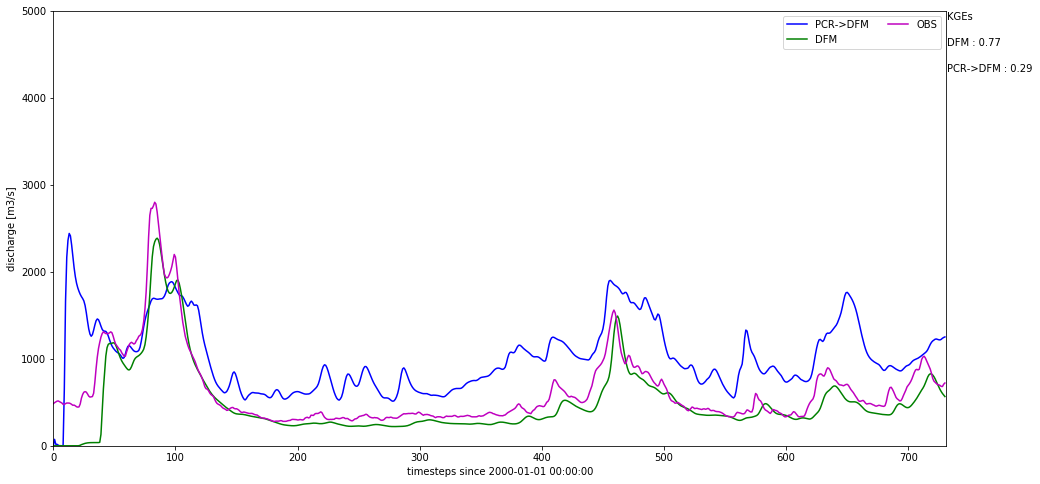

In [15]:
#- load DFM output file (from this model run)
fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
no = Dataset(fo, 'r')
#- extract simulated discharge from nc-file (for this run)
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])

#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
no_stA = Dataset(fo_stA, 'r')
#- extract simulated discharge from nc-file for DFM standalone
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- limit to list with least entries
minLength = min(len(qobs_ND), len(qsim_ND), len(qsim_ND_stA))
if len(qobs_ND) > len(qsim_ND):
    qsim_ND = qsim_ND[:minLength]
    qobs_ND = qobs_ND[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    
#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)

#- plot
plt.figure(figsize=(16,8))
plt.plot(qsim_ND, 'b', label = 'PCR->DFM')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(len(qsim_ND)+1,4900, 'KGEs') 
plt.text(len(qsim_ND)+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(len(qsim_ND)+1,4300, 'PCR->DFM : '+str(KGE_ND))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(cwd, 'compareAndvalidate_Qsim_PCR2DFM.png'), dpi=300)